## TODO
- потом преобразовать тексты в одну строку, как было, когда влучайно ошибся и сделать триграммы

## Download hh feeds

In [2]:
import requests
import pickledb 


db = pickledb.load('/home/shurik2533/Yandex.Disk/vk_hh.db', False) 

start_from = None
while True:
    r = requests.get(
        url='https://api.vk.com/method/newsfeed.search?v=5.52',
        params={
            'access_token': '91ddf3463201e27ee7832605e1f351e49a29f76d5cf47173c920f747158e8eaeb13de02378b9a27d4de08',
            'count': 200, #max200
            'q': 'HeadHunter',
            'start_from': start_from

        },
        stream=True
    )

    news = r.json()['response'] 

    for item in news['items']:
        db.set(str(item['id']), item)

    db.dump()
    if 'next_from' in news:
        start_from = news['next_from']
        print 'new stast_from', start_from
    else:
        print 'Finish'
        break
    

KeyError: 'response'

In [3]:
len(db.getall())

920

## Prepare text

In [136]:
import re 


def cleantext(raw):
    txt = re.sub('<[^>]*>', '', raw.lower())
    txt = re.sub('&quot;', '', txt)
    txt = re.sub(ur'[^a-zа-я]+', ' ', txt)
    txt = ' '.join(word for word in txt.split() if len(word)>2)
    return txt

In [166]:
# -*- coding: utf-8 -*-
def ngrams(word, n):
    res = []
    for i in range(0, len(word)-(n-1)):
        res.append(word[i:i+n])
    return res

In [167]:
# -*- coding: utf-8 -*-
from pymystem3 import Mystem
from collections import OrderedDict


result = ''
cnt = 0
m = Mystem()
for nid in db.getall():
    text = cleantext(db.get(nid)['text'])
    lemmas = [l for l in m.lemmatize(text) if len(l) > 2]
    joined_lemmas = ''.join(lemmas).strip()
    tri_lemmas = ngrams(joined_lemmas, 2) + ngrams(joined_lemmas, 3) + ngrams(joined_lemmas, 4)
    if len(lemmas) < 10:
        continue
    data = OrderedDict([
        ('text', (' '.join(tri_lemmas).encode('utf-8'))),
    ])
    
    line = '{} '.format(nid)
    for key, val in data.iteritems():
        line += '|{key} {val} '.format(key=key, val=val)
    result += (line + '\r\n')
    cnt += 1
#     if cnt == 5:
#         break
    
print 'cnt', cnt
text_file = open("/home/shurik2533/feeds.txt", "w")
text_file.write(result)
text_file.close()
    

cnt 805


## Playing with bigARTM

In [168]:
import artm
from matplotlib import pyplot as plt
import seaborn
import numpy as np
import pandas as pd
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})


In [169]:
batch_vectorizer = artm.BatchVectorizer(data_path="/home/shurik2533/feeds.txt", data_format="vowpal_wabbit", target_folder="lectures_batches", 
                                       batch_size=100)

In [182]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
model_artm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=1)

dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))

model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SmoothPhi', tau=1e5, dictionary=dictionary, class_ids={"text":1}, topic_names={"bcg"}
    )
)

In [183]:
model_artm.initialize('dictionary')
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

In [184]:
model_artm.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SparsePhi', tau=-1e5, dictionary=dictionary, class_ids={"text":1}, topic_names=topic_names[:-1]
    )
)
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [185]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words_text"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  гр иг упп ппа рупп груп гру пп уппа йг руп игр уп инк рад
sbj1:  сс ес рес стре есс стр тре ресс ский трес ыйс обл та обла сп
sbj2:  ат ть ьс ать то тьс он атьс ться та аз да ся ит ват
sbj3:  жь лож ожь ложь ож ело ьл век овек чело лове чел елов тьл ьло
sbj4:  парт бр пар арт ау учас тя брь нау ябр ябрь яб рал тяб club
sbj5:  кл оже кать жени ож иск лож аш ложе ожен пои поис лю тьин ныйп
sbj6:  крас расн нода асн асно снод одар нод кра сно дар bi bit pb tpb
sbj7:  ый ка ль ов ел ак ве за ро ор ру ек ци ров ьк
sbj8:  er te nt dh ter nte nter ad hu un unt hun ead hea hunt
sbj9:  er re in es an or th st he te on al at en ar
sbj10:  но нос ност жн ру ость льно за жно ьно ад кл ара би ла
sbj11:  ат бот ьны ить ход ван аль ьв альн да лж дол хо ходи долж
sbj12:  ал ла ар те та аль гр альн пл ьны гра ад ог фо ир
sbj13:  az azy zy eazy eaz эп рэ рэп th ice реж ic ub ьбом альб
sbj14:  ат ал ис то да ли ас ец спе али иа иал циа циал ате
sbj15:  ский ки кий ски ий ык яз ск йски нск нски зык

In [194]:
sbj_topic_labels = [
    "Про группы лиц, объединенных каким-то интересом", 
    "Питер", 
    "Болтовня какая-то",
    "30 коротких поразительных фактов о лжи и не знаю, как остальное связать",
    "Что-то федеральное/межрегиональное",
    "Мобильное приложение по поиску работы HeadHunter",
    "Списки вакансий",
    "ХЗ",
    "Короткие фразочки про самые/наиболее",
    "Трек-листы",
    "Про Верх/низ, больше/меншье, плюс/минус",
    "Работодатель/Работа/Резюме", 
    "Упоминание школы/акадении/вуза",
    "Кино/музыка/творчество",
    "Про работу и количество",
    "Иностранные языки и здравоохранение",
    "Пенсии",
    "Петербург занял 3-е место",
    "Коммуникации/мобильные приложения",
    "Право",
    "Устал. Попробуй сама определить тему)",
    "Устал. Попробуй сама определить тему)", 
    "Устал. Попробуй сама определить тему)",
    "Устал. Попробуй сама определить тему)",
    "Устал. Попробуй сама определить тему)",
    "Устал. Попробуй сама определить тему)",
    "Устал. Попробуй сама определить тему)",
    "Устал. Попробуй сама определить тему)",
    "Устал. Попробуй сама определить тему)",
    "Устал. Попробуй сама определить тему)",
]
# sbj_topic_labels = range(0, 30)
topic_labels = sbj_topic_labels + ["Фоновая тема"]

In [187]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
theta = model_artm.get_theta() 

In [188]:
print theta.shape
theta

(30, 805)


,3954,1931,547736,17736,39727,1939,58164,7372,340313,3506,...,6501,13330,15036,85186,2106,640,89486,21748,438,1246
sbj0,2.164792e-02,1.405841e-10,2.673872e-02,8.053006e-12,0.000000e+00,0.011223,1.132158e-01,0.000000,0.084602,1.356707e-03,...,0.000000e+00,3.490945e-12,2.927304e-13,8.429671e-04,1.210579e-03,0.000000e+00,1.557666e-10,4.261700e-08,1.203633e-08,0.075112
sbj1,5.907141e-03,3.054626e-01,5.146009e-03,1.639033e-01,9.502755e-11,0.005947,9.654506e-06,0.000000,0.006008,3.105817e-03,...,4.738255e-06,8.099994e-04,2.902301e-04,3.304143e-03,2.638671e-02,3.735989e-01,3.108786e-01,1.985266e-02,1.003657e-02,0.001950
sbj2,2.407503e-01,5.240494e-02,3.868953e-01,2.608440e-02,9.919375e-05,0.082796,1.445474e-02,0.000000,0.159251,9.076058e-02,...,3.378309e-02,5.365948e-02,1.024169e-03,1.060060e-01,6.306468e-02,1.758593e-02,5.895723e-02,1.354066e-02,4.039518e-02,0.062166
sbj3,5.744776e-10,5.296961e-06,3.136559e-03,1.195447e-06,2.150079e-11,0.001329,3.158755e-06,0.000000,0.008700,3.345477e-04,...,0.000000e+00,3.311790e-08,1.186149e-14,3.072073e-03,3.160580e-03,1.376554e-12,9.478335e-06,4.071455e-12,1.328635e-05,0.000272
sbj4,6.364562e-03,2.831171e-09,1.960540e-03,1.436532e-03,4.019821e-05,0.127780,8.538619e-02,0.000000,0.004687,8.605979e-04,...,5.629527e-14,1.454242e-02,4.245189e-05,1.198454e-01,2.303413e-04,4.428730e-06,1.426455e-08,1.787300e-05,9.061398e-15,0.001263
sbj5,1.918561e-03,3.154400e-06,7.899414e-03,1.594576e-02,1.588568e-02,0.002963,3.071163e-04,0.064210,0.000235,3.712327e-03,...,5.340847e-01,3.382847e-04,1.688594e-11,3.529555e-03,1.994936e-03,5.997485e-10,5.934250e-05,4.903661e-04,8.941836e-04,0.000025
sbj6,1.036011e-02,2.105661e-10,3.041524e-03,0.000000e+00,3.255218e-09,0.000276,4.160980e-11,0.000000,0.000073,1.873359e-03,...,0.000000e+00,0.000000e+00,7.349658e-16,8.549648e-06,1.852300e-02,0.000000e+00,1.506535e-11,1.066650e-02,4.850704e-10,0.000002
sbj7,6.771039e-02,9.035782e-02,4.210943e-02,1.926887e-02,1.243509e-05,0.045801,7.053796e-02,0.000000,0.056520,9.437026e-02,...,2.068164e-02,3.549764e-02,1.594954e-02,6.358032e-02,5.559821e-02,1.725319e-02,9.431542e-02,4.976133e-02,5.342884e-02,0.052312
sbj8,4.067621e-02,2.905318e-02,5.803444e-09,2.505281e-01,1.331411e-01,0.010355,1.064017e-03,0.087959,0.002438,1.096806e-02,...,3.887929e-02,9.184903e-03,1.417375e-04,3.643613e-03,1.560789e-02,1.165129e-02,1.250369e-02,3.340560e-01,1.357340e-02,0.033165
sbj9,0.000000e+00,1.123861e-02,0.000000e+00,7.108983e-02,0.000000e+00,0.081870,6.158960e-03,0.011943,0.011720,1.179878e-02,...,0.000000e+00,0.000000e+00,2.282479e-02,2.562881e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.801988e-03,0.038580


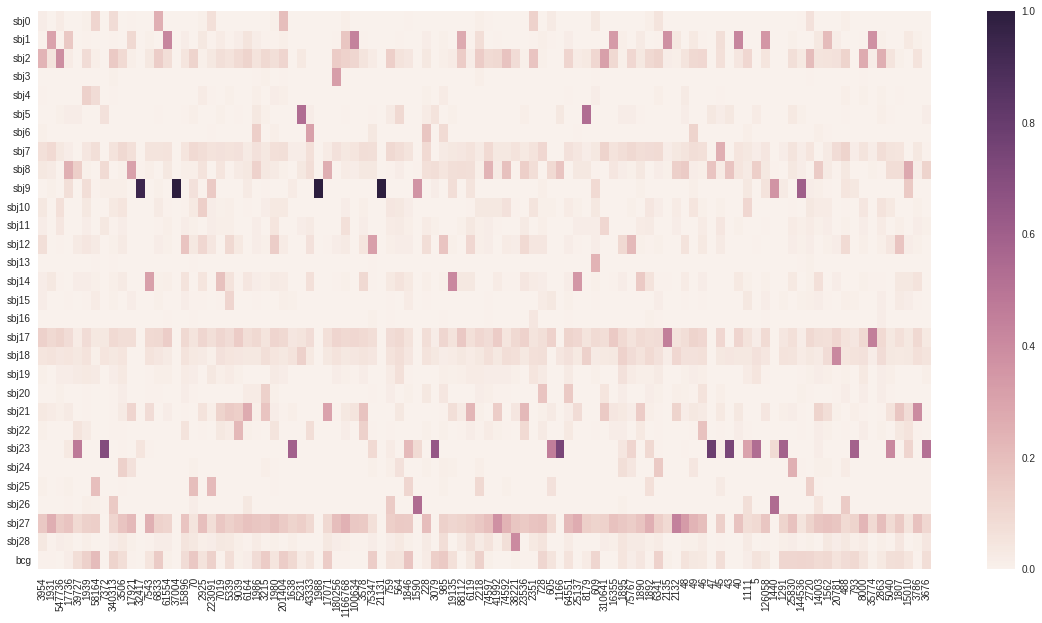

In [189]:
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.iloc[:,:100])

In [190]:
pt = theta.sum(axis=1)/theta.sum(axis=1).sum()
print pt

sbj0     0.005133
sbj1     0.058622
sbj2     0.065115
sbj3     0.003803
sbj4     0.007663
sbj5     0.027317
sbj6     0.010194
sbj7     0.048048
sbj8     0.056609
sbj9     0.065613
sbj10    0.015272
sbj11    0.015495
sbj12    0.023137
sbj13    0.004672
sbj14    0.033368
sbj15    0.009317
sbj16    0.006704
sbj17    0.098662
sbj18    0.049717
sbj19    0.016151
sbj20    0.010716
sbj21    0.042158
sbj22    0.018494
sbj23    0.072679
sbj24    0.011092
sbj25    0.004557
sbj26    0.012524
sbj27    0.139442
sbj28    0.021345
bcg      0.046381
dtype: float32


In [191]:
print pt.nlargest(2)
print pt.nsmallest(2)

sbj27    0.139442
sbj17    0.098662
dtype: float32
sbj3     0.003803
sbj25    0.004557
dtype: float32


In [192]:
p_dt = theta.transpose()/theta.sum(axis=1)

In [195]:
from IPython.core.display import display, HTML


for idx, topic_name in enumerate(model_artm.topic_names):
    display(HTML("<h1>{} ({})</h1>".format(topic_name, topic_labels[idx])))
    tokens = model_artm.score_tracker["top_words_text"].last_tokens
    weights = model_artm.score_tracker["top_words_text"].last_weights
    display(HTML(', '.join([u'{}({:.3f})'.format(x[0], x[1]) for x in zip(tokens[topic_name], weights[topic_name])])))
    for doc in p_dt[topic_name].sort_values(ascending=False)[0:10].index:
        display(HTML("<b>Документ: {}</b><br>".format(doc)))
        print db.get(doc)['text']
        print '--------------'
    print '//////////////////////////////////////////////////////////////////////////////////'

Альбом (#album@rockparty_neverknow) 

MC5

Kick Out The Jams 
1969

Kick Out the Jams - дебютный альбом детройтской рок-группы предтечей панк-рока MC5, вышедший на Elektra Records в феврале 1969 года. Альбом записан живьем на двух концертах, имевших место в Хеллоуин 1968 года в детройтском зале Grande Ballroom. Kick Out the Jams считается одним из лучших концертных альбомов рок-музыки и давно обрел культовый статус как предтеча панк-рока. 
 
ИСТОРИЯ 
 
Начало группе MC5 положила дружба гитаристов Уэйна Крамера и Фреда Смита по прозвищу Sonic (Звуковой). Они дружили с детства, оба были любителями R&B, блюза, Чака Берри, Дика Дейла, группы Ventures и того стиля, что позже назовут "гаражный рок". Им нравилась любая музыка, полная скорости, энергии и мятежного духа. Оба друга создали группы, где были лидерами: Смит - Vibratones, Крамер - Bounty Hunters. Но пришло время, и большинство участников обоих групп ушли - кто учиться, кто работать, а самые заядлые объединилиь в одну группу под лиде

Рубрика "За стадионом". 
Flint`s Crew. 
Второго марта 1994 года, родилась старейшая группировка фанатов Спартака - Flint`s Crew! 
В рядах состава "Флинтов", собранного в 1994 году, не было ни одного представителя спартаковского движения восьмидесятых. Таким образом, это была молодая банда, но банда единомышленников, целью которых было возродить былой славный спартаковский фанатизм. 
Фирма представляла собой молодую группу бравых людей, главной целью которых было поднять на самый высокий уровень спартаковский фанатизм в целом. В то же время московский Спартак переживал довольно сложные времена и футболисты команды обратились к своим суппортерам не прекращать поддерживать команду. Тогда и зародилась такая славная традиция между болельщиками и командой, как подход игроков после финального свистка к сектору фанатов, где футболисты громкими аплодисментами благодарили своих фанов за поддержку. Контингент фирмы составляли люди от 18 до 35 лет и разного социального уровня. Фирма довольно часто

Друзья-товарищи, есть у кого-нибудь регистрация на HeadHunter в качестве работодателя? А у ваших близких/знакомых/коллег? Нужно одну анкету со стороны оценить. Кто может - отзовитесь, буду признателен!
--------------


15 сентября 1964 года родился Дойл Вольфганг фон Франкенштейн (наст. имя Пол Кайафа) — американский музыкант, наиболее известен как гитарист группы Misfits и участник сольного проекта Doyle.
--------------


Рубрика "За стадионом". 
Headhunters.
После спада популярности "Челси" в 1967 году группа скинхэдов объявила себя поклонниками клуба. Группа ультраправого футбольного террора, превративших трибуны в ад. 
После регулярных беспорядков на стадионах тогдашний владелец "Челси" Брайан Мирс поставил на "Стэмфорд Бридж" решетки, для сдерживания агрессии хантэрсов. Но это не помогло и запертым членам фирмы теперь мало кто мешал устраивать дебош и беспорядки. 
Когда владельцем "Челси" стал Кен Бэйтс, он решил изменить имидж клуба, вернув ему аристократический лоск и искоренить хулиганство пустив по решетке ток. Но суду не очень понравилась эта идея и Кена заставили убрать генераторы с трибун. 
В фильме "Хулиганы Грин Стрит" есть момент, где герою фильма рассекают рот кредитной карточкой. Фирменная штука фанатов "пенсионеров", которая называется "улыбкой Челси". В рядах Headhunters выступали даже рекруты Национального Фронта и Британской Национальной Партии, так что вероятно без политики тут не о

✅done! Я познакомилась наконец-то с Ниной Осовицкой из HeadHunter, которая является известнейшим экспертом по HR-брендингу, организатором аналогичной конференции и автором книги "HR брендинг", которую она мне еще и подписала )) ‼️

#яжHR #hrlife
--------------


Друзья и знакомые, кто недавно выпустился, или, может быть, обучение закончил давно - но так и не нашёл своё дело в этой жизни.
Для вас, 14 сентября, в следующую среду, в 18.30, моя знакомая приглашает выпускников ВУЗов и молодых специалистов, ищущих работу, на встречу "Карьерный диалог". Далее - информация о предстоящем событии от лица Светланы:
Мы - компания экспертов рынка труда, готовых ответить на ваши вопросы и рассказать о возможностях рынка труда и их применении. У нас нет цели продать вам работу в каких-то компаниях.
Встреча с кем вас ждет?
Елана Таращук (Elana Taraschuk), руководитель PR-службы HH.ru поделится полезной аналитикой "Кому нужны молодые специалисты и сколько им готовы платить?"
Со Светланой Войтенко, консультантом по карьере и HR, проект «Карьера в радость», т.е. со мной мы обсудим, как составить правдивое продающее резюме, если опыта еще совсем нет. И вы составите или откорректируете свое резюме.
Ольга Исаева (Olga Isaeva), директор кадрового агентства «Brainpow

Стиль: #heavy_metal #thrash_metal 
Группа: #Headhunter 
Альбом: Parody Of Life 
Год: 1990 
Страна: Германия

трек под обложкой
--------------


[club11809|Зарождение вечеринок в Гоа ]

Первым из хиппи, прибывших в Гоа в середине 60-х, был Eight-Finger Eddie, который вместе со своими друзьями начал устраивать первые “Гоа-пати”, главными атрибутами которых были костер на пляже, акустические гитары и танцы под воздействием галлюциногенных веществ. В рождество Гоа становился точкой сбора всех хиппи, путешествовавших по Востоку. Они встречались на пляжах Анжуны, Вагатора, Калангута, чтобы рассказать друг другу об их увлекательных путешествиях. Поначалу они просто арендовали домики на месяц или два, но вскоре те из них, кто почувствовал себя на берегах Гоа как дома, начали селиться там на неопределённые сроки. 

На протяжении семидесятых годов главным репертуаром первых Ди-Джеев в Гоа была рок-музыка таких групп как Led Zeppelin, The Who (обе эти группы приезжали в Гоа), Jimi Hendrix, The Grateful Dead, The Doors, Neil Young, The Eagles, Pink Floyd а также Боб Марли, Parliament и др. 

В 1979 году на вечеринках можно было услышать о

Друзья, мы представляем вам нашу новую рубрику #чёрная_пятница
Для этой рубрики мы будем просить музыкантов и прочих интересных людей составить нам плей-лист по теме нашего паблика, и очень постараемся сделать рубрику еженедельной.

Наш первый гость - [id7931931|Антон Бурмакин], гитарист групп Sierpien, Breathing Of Bones, Carnival. Ему и слово:

Думаю о Bauhaus, Killing Joke и The Sisters Of Mercy было уже столько всего сказано, что даже не стоит тратить на них время. Ниже девять чуть менее известных групп, которые так или иначе повлияли на мои музыкальные предпочтения и игру на гитаре:

Каштановый кризис – Капитан Немо 
Наикрутейший брянский пост-панк бэнд. Будучи подростком удалось побывать на парочке их концертов. Наверное, именно Каштаны стали отправной точкой для меня в пост-панке. Я понял, что хочу шуметь нечто похожее. Очень зажигательный и качественный музон. Жаль, что группа давно уже не функционирует и разбежалась по своим взрослым делам.

Югендштиль – Варвар
Моя любимая рус

Вестник Петербурга 

Петербург занял третье место в рейтинге самых стрессовых регионов России 
Согласно исследованию, проведенному рекрутинговой компанией HeadHunter, почти каждый четвертый работающий петербуржец находится в состоянии стресса. 
Первое место досталось Орловской области (35% респондентов заявили о постоянном перенапряжении на работе). На втором месте оказались Тамбовская и Ярославская области (25%), а «бронзу» разделили Петербург и Ленинградская и Нижегородская области (23%). 
Петербуржцы жалуются на большой объем работы (49% опрошенных), несоблюдение сроков (40%) и конфликты с начальством (32% респондентов упомянули об этом). Также недовольство работников вызывает качество выполненных задач и высокий темп работы
--------------


#НОВОТЕКА на [club135485877|Новом]!

Нелегко приходится петербуржцам на работе! 
Служба исследований HeadHunter выяснила, что каждый 4-й работающий петербуржец фактически живет в состоянии стресса. 

23% заявили, что испытывают стресс на работе каждый день. Таким образом, Петербург вошел в тройку наиболее "стрессовых" регионов страны. В основном, петербуржцы испытывают стресс от слишком большого объема работы. Чуть меньше жители города на Неве страдают от несоблюдения сроков выполнения поставленных задач. На 3 месте – ссоры с начальством. 
 
Борются со стрессом петербуржцы с помощью хобби, общения с друзьями и коллегами, а 16% работников топят стресс в алкоголе.
--------------


Петербург занял третье место в рейтинге самых стрессовых регионов России 
 
Согласно исследованию, проведенному рекрутинговой компанией HeadHunter, почти каждый четвертый работающий петербуржец находится в состоянии стресса. 
 
Первое место досталось Орловской области (35% респондентов заявили о постоянном перенапряжении на работе). На втором месте оказались Тамбовская и Ярославская области (25%), а «бронзу» разделили Петербург и Ленинградская и Нижегородская области (23%). 
 
Петербуржцы жалуются на большой объем работы (49% опрошенных), несоблюдение сроков (40%) и конфликты с начальством (32% респондентов упомянули об этом). Также недовольство работников вызывает качество выполненных задач и высокий темп работы. 
 
46% опрошенных борются с напряжением, общаясь с друзьями (еще 24% — с коллегами). 16% употребляют алкоголь, а каждый пятый принимает успокоительное. Психолога посещают 3% работников.
--------------


Петербург занял третье место в рейтинге самых стрессовых регионов России

Согласно исследованию, проведенному рекрутинговой компанией HeadHunter, почти каждый четвертый работающий петербуржец находится в состоянии стресса.

Первое место досталось Орловской области (35% респондентов заявили о постоянном перенапряжении на работе). На втором месте оказались Тамбовская и Ярославская области (25%), а «бронзу» разделили Петербург и Ленинградская и Нижегородская области (23%).

Петербуржцы жалуются на большой объем работы (49% опрошенных), несоблюдение сроков (40%) и конфликты с начальством (32% респондентов упомянули об этом). Также недовольство работников вызывает качество выполненных задач и высокий темп работы.

46% опрошенных борются с напряжением, общаясь с друзьями (еще 24% — с коллегами). 16% употребляют алкоголь, а каждый пятый принимает успокоительное. Психолога посещают 3% работников.
--------------


Петербург занял третье место в рейтинге самых стрессовых регионов России 
Согласно исследованию, проведенному рекрутинговой компанией HeadHunter, почти каждый четвертый работающий петербуржец находится в состоянии стресса. 
Первое место досталось Орловской области (35% респондентов заявили о постоянном перенапряжении на работе). На втором месте оказались Тамбовская и Ярославская области (25%), а «бронзу» разделили Петербург и Ленинградская и Нижегородская области (23%). 
Петербуржцы жалуются на большой объем работы (49% опрошенных), несоблюдение сроков (40%) и конфликты с начальством (32% респондентов упомянули об этом). Также недовольство работников вызывает качество выполненных задач и высокий темп работы. 
46% опрошенных борются с напряжением, общаясь с друзьями (еще 24% — с коллегами). 16% употребляют алкоголь, а каждый пятый принимает успокоительное. Психолога посещают 3% работников.
--------------


Петербург занял третье место в рейтинге самых стрессовых регионов России

Согласно исследованию, проведенному рекрутинговой компанией HeadHunter, почти каждый четвертый работающий петербуржец находится в состоянии стресса.

Первое место досталось Орловской области (35% респондентов заявили о постоянном перенапряжении на работе). На втором месте оказались Тамбовская и Ярославская области (25%), а «бронзу» разделили Петербург и Ленинградская и Нижегородская области (23%).

Петербуржцы жалуются на большой объем работы (49% опрошенных), несоблюдение сроков (40%) и конфликты с начальством (32% респондентов упомянули об этом). Также недовольство работников вызывает качество выполненных задач и высокий темп работы.

46% опрошенных борются с напряжением, общаясь с друзьями (еще 24% — с коллегами). 16% употребляют алкоголь, а каждый пятый принимает успокоительное. Психолога посещают 3% работников.
--------------


Петербург занял третье место в рейтинге самых стрессовых регионов России

Согласно исследованию, проведенному рекрутинговой компанией HeadHunter, почти каждый четвертый работающий петербуржец находится в состоянии стресса.

В составленном рейтинге первое место досталось Орловской области (35% респондентов заявили о постоянном перенапряжении на работе). На втором месте оказались Тамбовская и Ярославская области (25%), а "бронзу" разделили Петербург и Ленинградская и Нижегородская области (23%).

Петербуржцы жалуются на большой объем работы (49% опрошенных), несоблюдение сроков (40%) и конфликты с начальством (32% респондентов упомянули об этом). Также недовольство работников вызывает качество выполненных задач и высокий темп работы.

46% опрошенных борются с напряжением, общаясь с друзьями (еще 24% - с коллегами). 16% употребляют алкоголь, а каждый пятый принимает успокоительное. Психолога посещают 3% работников.
--------------


Петербург занял третье место в рейтинге самых стрессовых регионов России

Согласно исследованию, проведенному рекрутинговой компанией HeadHunter, почти каждый четвертый работающий петербуржец находится в состоянии стресса.

В составленном рейтинге первое место досталось Орловской области (35% респондентов заявили о постоянном перенапряжении на работе). На втором месте оказались Тамбовская и Ярославская области (25%), а "бронзу" разделили Петербург и Ленинградская и Нижегородская области (23%).

Петербуржцы жалуются на большой объем работы (49% опрошенных), несоблюдение сроков (40%) и конфликты с начальством (32% респондентов упомянули об этом). Также недовольство работников вызывает качество выполненных задач и высокий темп работы.

46% опрошенных борются с напряжением, общаясь с друзьями (еще 24% - с коллегами). 16% употребляют алкоголь, а каждый пятый принимает успокоительное. Психолога посещают 3% работников.
--------------


Петербург занял третье место в рейтинге самых стрессовых регионов России.

Согласно исследованию, проведенному рекрутинговой компанией HeadHunter, почти каждый четвертый работающий петербуржец находится в состоянии стресса.

В составленном рейтинге первое место досталось Орловской области (35% респондентов заявили о постоянном перенапряжении на работе). На втором месте оказались Тамбовская и Ярославская области (25%), а "бронзу" разделили Петербург и Ленинградская и Нижегородская области (23%).

Петербуржцы жалуются на большой объем работы (49% опрошенных), несоблюдение сроков (40%) и конфликты с начальством (32% респондентов упомянули об этом). Также недовольство работников вызывает качество выполненных задач и высокий темп работы.

46% опрошенных борются с напряжением, общаясь с друзьями (ещё 24% - с коллегами). 16% употребляют алкоголь, а каждый пятый принимает успокоительное. Психолога посещают 3% работников.
--------------


Петербург занял третье место в рейтинге самых стрессовых регионов России

Согласно исследованию, проведенному рекрутинговой компанией HeadHunter, почти каждый четвертый работающий петербуржец находится в состоянии стресса.

В составленном рейтинге первое место досталось Орловской области (35% респондентов заявили о постоянном перенапряжении на работе). На втором месте оказались Тамбовская и Ярославская области (25%), а "бронзу" разделили Петербург и Ленинградская и Нижегородская области (23%).

Петербуржцы жалуются на большой объем работы (49% опрошенных), несоблюдение сроков (40%) и конфликты с начальством (32% респондентов упомянули об этом). Также недовольство работников вызывает качество выполненных задач и высокий темп работы.

46% опрошенных борются с напряжением, общаясь с друзьями (еще 24% - с коллегами). 16% употребляют алкоголь, а каждый пятый принимает успокоительное. Психолога посещают 3% работников.

Изображение: Вася Ложкин
--------------
/////////////////////////////////

А что если взглянуть на мир иначе? С детским любопытством и наивнастью, спросить себя, что для тебя важно? Попробовать жить в стиле "а почему бы и нет?" Делать все что ты захочешь не оглядываясь на всякие рамки, которые вы придумали или вам их навязали?
--------------


— Надо купить виски, — рабочий день закончился, и по пути домой мне пришла гениальная мысль. Не знаю, были ли последние три бессонные ночи, абсолютная неудовлетворённность жизнью или просто желание напиться причинами ее возникновения, но я уже шел в спиртной отдел престижного магазина, мимо которого проходил ежедневно, но в котором ни разу не был из-за опасений за полноту своего кошелька. 
 
С полок на меня смотрели ряды бутылок с янтарной жидкостью внутри. Глаза пробежались по ценникам, и, найдя равный моей месячной зарплате, я потянулся к товару над ним. Я направил свое заспанное лицо на кассиршу, раздался писк, моя рука протянула карту. К слову, работа у меня неплохая, платят хорошо, атмосфера… так, о ней — уже когда выпью. Начальник даже не особо мудак. Я беру покупку и иду к выходу. Открываю ее. Глоток. 
 
Да, все-таки, грех жаловаться на мою жизнь. Есть дом, постоянный доход, позволяющий особо не волноваться о первичных надобностях. Семья? Любовь? Не, не для меня. Треть бутылки у

Не убегай, дорогая, ибо я всегда буду рядом, чтобы ни случилось. Здесь и сейчас.Но если ты попробуешь уйти, то мне придётся вскрыть твоё тело, заставив его и твои внутренности принадлежать мне навсегда до скончания моей собственной жизни.
--------------


Последний охотник на ведьм (2015) 
Жанр: фэнтези, боевик, приключения 
 
Современный мир скрывает множество секретов, но самым удивительным из них является то, что ведьмы до сих пор живут среди нас. Это злобные сверхъестественные существа, чья цель — наслать на мир смертоносную чуму. Армии охотников на ведьм сражались с ними на протяжении многих веков.
--------------


Последний охотник на ведьм (2015) 
Жанр: фэнтези, боевик, приключения 
 
Современный мир скрывает множество секретов, но самым удивительным из них является то, что ведьмы до сих пор живут среди нас. Это злобные сверхъестественные существа, чья цель — наслать на мир смертоносную чуму. Армии охотников на ведьм сражались с ними на протяжении многих веков.
--------------


Последний охотник на ведьм (2015) 
Жанр: фэнтези, боевик, приключения 
 
Современный мир скрывает множество секретов, но самым удивительным из них является то, что ведьмы до сих пор живут среди нас. Это злобные сверхъестественные существа, чья цель — наслать на мир смертоносную чуму. Армии охотников на ведьм сражались с ними на протяжении многих веков.
--------------


❗❗❗ ВЗГЛЯД НА SMM ❗ ❗ ❗
___________________________

Наверное никто не будет отрицать, что социальные медиа – это мощнейший канал для привлечения клиентов. Но сейчас достаточно сложно найти толкового SMM-щика. Человека, который будет вдохновлять и давать работающие, проверенные инструменты продвижения 📈.

На своем пути я встречала разных специалистов по социальным сетям.
Но большинство из них не были профессионалами своего дела. 😒

Со стороны кажется, что это легкая профессия, поэтому очень многие (чаще даже школьники) считаются себя гуру SMM. О чем тут говорить, если средний возраст кандидатов на HeadHunter всего 19 лет!☝

Сейчас очень много информации по продвижению в соц.сетях, однако более 90% этой информации не выполняет основного своего назначения – привлечения клиентов, т.е. попусту не работает.📉

Кстати, я, как преподаватель ВУЗа, отметила тот факт, что SMM начали обучать гос. ВУЗы (ГУУ, РУДН, РЭА им. Г.В. Плеханова и др.)💥

Это стремительно развивающееся направление. Может пол

После недавнего поста "обо мне и моей работе" было очень много личных сообщений с вопросами про саму идею,зарождение ростовых цветов,совмещения этого с многодетной жизнью и т.д.Очень приятно такое количество откликов,особенно от незнакомых людей🤗Что решилась на написание ещё одного рассказа о себе😊#ХотьИСтесняюсьОчень

*******************************

Уволилась я с престижной,высокооплачиваемой,стабильной и интересной работы не потому что там возникли проблемы. Наоборот,там все было хорошо и даже очень хорошо👍HeadHunter-крутая компания😎До сих пор вспоминаю с теплотой в душе❤️Но я почувствовала,что работая весь день,очень мало времени и внимания уделяю своей старшей дочке (на тот момент она была у меня одна).Это основной аргумент.Ну а деньги-здесь амбиции и вера в себя🙌🏻. Да и вытаскивание себя из зоны комфорта-это всегда развитие📈

 Я была в поисках деятельности,которая отвечала бы всем моим пунктикам про понедельники/начальники/будильники и время для своего ребёнка.Но самое главное,чт

❗❗❗ ВЗГЛЯД НА SMM ❗ ❗ ❗
___________________________

Наверное никто не будет отрицать, социальные медиа – это мощнейший канал для привлечения клиентов. Но сейчас достаточно сложно найти толкового SMM-щика. Человека, который будет вдохновлять и давать работающие, проверенные инструменты продвижения 📈.

На своем пути я встречала разных специалистов по социальным сетям.
Но большинство из них не были профессионалами своего дела. 😒

Со стороны кажется, что это легкая профессия, поэтому очень многие (чаще даже школьники) считают себя гуру SMM. О чем тут говорить, если средний возраст кандидатов на HeadHunter всего 19 лет!☝

Сейчас очень много информации по продвижению в соц.сетях, однако более 90% этой информации не выполняет основного своего назначения – привлечения клиентов, т.е. попусту не работает.📉

Кстати, я, как преподаватель ВУЗа, отметила тот факт, что SMM начали обучать гос. ВУЗы (ГУУ, РУДН, РЭА им. Г.В. Плеханова и др.)💥

Это стремительно развивающееся направление сейчас. А теорет

🔶 Подборка потрясающих комплексов для тренировок в домашних условиях

 ‼ Забирай себе на стену,чтобы не потерять! 📌📌
--------------
//////////////////////////////////////////////////////////////////////////////////


30 коротких поразительных фактов о лжи, которых мы не знали

Помните незабвенного доктора Хауса и его неизменное «Все лгут»? Печально, но очень похоже, что так оно и есть. Взрослый человек врёт несколько раз в сутки, причём даже самые честные, нет-нет, да и приврут невольно.

Начнём с определения. Ложь — это утверждение, заведомо не соответствующее истине.

Ложь фигурирует в легендах, мифах и сказках. В западной традиции ложь является пороком, который наказывают или исправляют. В восточных сказках чаще бывает ложь и плутовство во спасение.

Мифомания, или комплекс Мюнхгаузена — это болезнь, из-за которой человек ощущает постоянную тягу искажать правду. С помощью лжи он создает альтернативную реальность и, зачастую, искренне верит в свои слова.

Детектор лжи или полиграф не дает полной гарантии распознавания лжи. Показания прибора основываются на измерении давления и пульса человека, но среди лжецов встречается немало людей, которые способны обмануть детектор. Тем не менее, исследование

30 коротких поразительных фактов о лжи, которых мы не знали

Помните незабвенного доктора Хауса и его неизменное «Все лгут»? Печально, но очень похоже, что так оно и есть. Взрослый человек врёт несколько раз в сутки, причём даже самые честные, нет-нет, да и приврут невольно.

Начнём с определения. Ложь — это утверждение, заведомо не соответствующее истине.

Ложь фигурирует в легендах, мифах и сказках. В западной традиции ложь является пороком, который наказывают или исправляют. В восточных сказках чаще бывает ложь и плутовство во спасение.

Мифомания, или комплекс Мюнхгаузена — это болезнь, из-за которой человек ощущает постоянную тягу искажать правду. С помощью лжи он создает альтернативную реальность и, зачастую, искренне верит в свои слова.

Детектор лжи или полиграф не дает полной гарантии распознавания лжи. Показания прибора основываются на измерении давления и пульса человека, но среди лжецов встречается немало людей, которые способны обмануть детектор. Тем не менее, исследование

30 коротких поразительных фактов о лжи, которых мы не знали

Помните незабвенного доктора Хауса и его неизменное «Все лгут»? Печально, но очень похоже, что так оно и есть. Взрослый человек врёт несколько раз в сутки, причём даже самые честные, нет-нет, да и приврут невольно.

Начнём с определения. Ложь — это утверждение, заведомо не соответствующее истине.

Ложь фигурирует в легендах, мифах и сказках. В западной традиции ложь является пороком, который наказывают или исправляют. В восточных сказках чаще бывает ложь и плутовство во спасение.

Мифомания, или комплекс Мюнхгаузена — это болезнь, из-за которой человек ощущает постоянную тягу искажать правду. С помощью лжи он создает альтернативную реальность и, зачастую, искренне верит в свои слова.

Детектор лжи или полиграф не дает полной гарантии распознавания лжи. Показания прибора основываются на измерении давления и пульса человека, но среди лжецов встречается немало людей, которые способны обмануть детектор. Тем не менее, исследование

30 коротких поразительных фактов о лжи, которых мы не знали

Помните незабвенного доктора Хауса и его неизменное «Все лгут»? Печально, но очень похоже, что так оно и есть. Взрослый человек врёт несколько раз в сутки, причём даже самые честные, нет-нет, да и приврут невольно.

Начнём с определения. Ложь — это утверждение, заведомо не соответствующее истине.

Ложь фигурирует в легендах, мифах и сказках. В западной традиции ложь является пороком, который наказывают или исправляют. В восточных сказках чаще бывает ложь и плутовство во спасение.

Мифомания, или комплекс Мюнхгаузена — это болезнь, из-за которой человек ощущает постоянную тягу искажать правду. С помощью лжи он создает альтернативную реальность и, зачастую, искренне верит в свои слова.

Детектор лжи или полиграф не дает полной гарантии распознавания лжи. Показания прибора основываются на измерении давления и пульса человека, но среди лжецов встречается немало людей, которые способны обмануть детектор. Тем не менее, исследование

30 коротких поразительных фактов о лжи, которых мы не знали

Помните незабвенного доктора Хауса и его неизменное «Все лгут»? Печально, но очень похоже, что так оно и есть. Взрослый человек врёт несколько раз в сутки, причём даже самые честные, нет-нет, да и приврут невольно.

Начнём с определения. Ложь — это утверждение, заведомо не соответствующее истине.

Ложь фигурирует в легендах, мифах и сказках. В западной традиции ложь является пороком, который наказывают или исправляют. В восточных сказках чаще бывает ложь и плутовство во спасение.

Мифомания, или комплекс Мюнхгаузена — это болезнь, из-за которой человек ощущает постоянную тягу искажать правду. С помощью лжи он создает альтернативную реальность и, зачастую, искренне верит в свои слова.

Детектор лжи или полиграф не дает полной гарантии распознавания лжи. Показания прибора основываются на измерении давления и пульса человека, но среди лжецов встречается немало людей, которые способны обмануть детектор. Тем не менее, исследование

30 коротких поразительных фактов о лжи, которых мы не знали
( ИЗ ИНТЕРНЕТА)
Помните незабвенного доктора Хауса и его неизменное «Все лгут»? Печально, но очень похоже, что так оно и есть. Взрослый человек врёт несколько раз в сутки, причём даже самые честные, нет-нет, да и приврут невольно.

Начнём с определения. Ложь — это утверждение, заведомо не соответствующее истине.

Ложь фигурирует в легендах, мифах и сказках. В западной традиции ложь является пороком, который наказывают или исправляют. В восточных сказках чаще бывает ложь и плутовство во спасение.

Мифомания, или комплекс Мюнхгаузена — это болезнь, из-за которой человек ощущает постоянную тягу искажать правду. С помощью лжи он создает альтернативную реальность и, зачастую, искренне верит в свои слова.

Детектор лжи или полиграф не дает полной гарантии распознавания лжи. Показания прибора основываются на измерении давления и пульса человека, но среди лжецов встречается немало людей, которые способны обмануть детектор. Тем не мене

«Все лгут», — утверждает доктор Грегори Хаус. И он совершенно прав. По статистике, каждый человек лжет два или три раза в сутки. 
 
1. Ложь – это утверждение, заведомо не соответствующее истине. 
 
2. Ложь фигурирует в легендах, мифах и сказках. Во западной традиции ложь является пороком, который наказывают или исправляют. В восточных сказках чаще бывает ложь и плутовство во спасение. 
 
3. Мифомания, или комплекс Мюнхгаузена — это болезнь, из-за которой человек ощущает постоянную тягу искажать правду. С помощью лжи он создает альтернативную реальность и, зачастую, искренне верит в свои слова. 
 
4. Детектор лжи или полиграф не дает полной гарантии распознавания лжи. Показания прибора основываются на измерении давления и пульса человека, но среди лжецов встречается немало людей, которые способны обмануть детектор. Тем не менее, исследование Федеральной Системы Национальной Безопасности показало, что современные полиграфы правдивы на 96%. 
 
5. Когда человек лжет, в его крови повышается

"К сожалению, день рождения только раз в году" - это не про нас)) Сегодня еще один День Рождения HeadHunter в Краснодаре! Ровно 11 лет впервые открылся наш офис. Спасибо за подарок от Ростовских коллег!!! 😍😍😍 Невероятно крутой автобус! #hhru #hhkrasnodar #геленджик #слетюга2017  
--------------


Невероятное приключение в моей жизни.
Назвать "Зеркало" тренингом - язык не поворачивается. Ему тесно в этом слове, как участникам в прежней одежде. По традиции надо все переварить, и осмысленный текст будет позже. Ощущение, что вручили "Оскар", и хочется поблагодарить, а речь не заготовлена:)) 
[id57754105|Татьяна Мужицкая], спасибо тебе за воздух, за дыхание. За "Я есть", так восторженно произнесенное участницей в кругу. 
Максим Дранко, спасибо за классные примеры, чувство юмора и отменные шутки. 
Спасибо вам обоим за "играющих тренеров". За сообщения в Telegram, за вопросы на прощание даже в 4 утра. В этих "деталях" - огромная любовь к делу, к людям, самоотдача и труд. Вы столько вложили себя, что не взять это - было бы стыдно.
P.S. [id57754105|Татьяна Мужицкая] - ведущая и автор программ на телеканале "Успех", тренер в HeadHunter, Школе игры В. Демчог, Московском центре НЛП...
"Зеркалу" уже около 18 лет. Почти никаких концепций, только тело и внутренние состояния. Приключение, не п

А что если взглянуть на мир иначе? С детским любопытством и наивнастью, спросить себя, что для тебя важно? Попробовать жить в стиле "а почему бы и нет?" Делать все что ты захочешь не оглядываясь на всякие рамки, которые вы придумали или вам их навязали?
--------------
//////////////////////////////////////////////////////////////////////////////////


Дорогие участники, члены жюри и гости финального этапа Федерального Студенческого Турнира Трёх Наук! 
 
Рады сообщить Вам, что Вашим домом на период пребывания в городе Воронеж станет 4-звёздочный [club60094562| бизнес-отель "Дегас"]! 
 
Гостиничный комплекс "Дегас" предлагает своим гостям развитую инфраструктуру, в которую конечно же входят конференц-залы, в которых уже 14 сентября будут проходить мастерклассы от наших партнеров [club142785860|Стажировки.ру ] и [club354372|HeadHunter]!
 
Желаем Вам приятного пребывания в городе Воронеж!
#iturnir #ТТН
--------------


Финал [club49696909|Федерального Студенческого Турнира Трёх Наук 2017] пройдет в Воронеже 14-18 сентября!

14 сентября участники из разных уголков страны соберутся на базе #ВГУ на финальном этапе Федерального Студенческого Турнира Трёх Наук. На протяжении пяти дней за звание сильнейшей будет бороться 21 команда из 6 федеральных округов России.

Турнир Трёх Наук – это ежегодное командное состязание между студентами российских вузов, которое проводит Воронежский государственный университет с 2013 года. Это соревнование между студенческими командами по решению научных задач. Решение заданий требует знаний преимущественно в области физики, химии и биологии. Уникальность Турнира Трёх Наук состоит в том, что часть задач для состязания предлагают промышленные компании, выступающие партнёрами проекта. Некоторые компании имеют статус «Федерального партнёра». Такими компаниями уже стали ПАО «СИБУР Холдинг», Группа Компаний «ЭФКО», Фонд инфраструктурных и образовательных программ РОСНАНО, ООО «ЛУ

Финал [club49696909|Федерального Студенческого Турнира Трёх Наук 2017] пройдет в Воронеже 14-18 сентября!

14 сентября участники из разных уголков страны соберутся на базе #ВГУ на финальном этапе Федерального Студенческого Турнира Трёх Наук. На протяжении пяти дней за звание сильнейшей будет бороться 21 команда из 6 федеральных округов России.

Турнир Трёх Наук – это ежегодное командное состязание между студентами российских вузов, которое проводит Воронежский государственный университет с 2013 года. Это соревнование между студенческими командами по решению научных задач. Решение заданий требует знаний преимущественно в области физики, химии и биологии. Уникальность Турнира Трёх Наук состоит в том, что часть задач для состязания предлагают промышленные компании, выступающие партнёрами проекта. Некоторые компании имеют статус «Федерального партнёра». Такими компаниями уже стали ПАО «СИБУР Холдинг», Группа Компаний «ЭФКО», Фонд инфраструктурных и образовательных программ РОСНАНО, ООО «ЛУ

И если Турнир Трёх Волшебников из вселенной Гарри Поттера событие вымышленное, то Турнир Трёх Наук, очень даже реальный. И пройдет в ВГУ уже в юбилейный пятый раз.

На финале, который состоится уже на этой неделе, а именно с 14 по 18 сентября, схлестнутся участники из самых разных уголков России. В этом году за чемпионство поборются лучшие представители из 8 федеральных округов.

Кратко расскажем о программе каждого дня Турнира.

✔ В четверг 14 сентября участников ждёт мастер-класс по правильному написанию резюме и проведению собеседования от интернет-сервиса HeadHunter. После этого участники опробуют полученные навыки на «реальном» собеседовании. Его проведут представители компаний-партнёров Турнира. Завершится первый день квестом от интернет-проекта Стажировка.ру.

✔ В пятницу 15 и субботу 16 сентября пройдут сами поединки или, как их принято называть, научные бои.

✔ В воскресенье 17 сентября гости столицы Черноземья смогут познакомиться с главными достопримечательностями не только 

💥Мы дождались!💥

 В стенах #ВГУ 14 сентября был дан старт финальному этапу Федерального Студенческого Турнира Трёх Наук! 

 На Торжественном открытии Финала с приветственной речью выступил ректор Воронежского государственного университета Дмитрий Александрович Ендовицкий. Он пожелал участникам удачи, амбициозности и сплоченности. 
Также на церемонии выступили: Сергей Михайлович Афанасьев - начальник отдела проектно-программной деятельности в молодёжной среде департамента образования науки и молодёжной политики Воронежской области, Гришаев Олег Викторович - Проректор по воспитательной и социальной работе ВГУ, Игорь Владимирович Линдевинов - исполнительный директор гражданского собрания "Лидер", Дмитрий Черенков - Доктор биологических наук, заместитель генерального директора по биотехнологическим проектам в Инновационном центре "Бирюч-НТ" (ГК ЭФКО). 

Образовательная программа также была включена в первый день Финала Турнира. В конференц-зале отеля "Дегас" состоялись сразу два мастер-кла

ИА IrkutskMedia совместно с HeadHunter составило рейтинг неожиданных профессий
#irkutskmedia #news #иркутскаяобласть
--------------


На правах генерального партнера мы рады представить вам главное HR-событие этой осени – межрегиональный форум «HR без границ. Технологии будущего», который организует компания HeadHunter. 
Форум состоится 19 октября в Вологде, при поддержке информационных партнеров: Опора России; Бизнес и Власть; Вологодская торгово-промышленная палата и др. 

#hh_ru #cprofi #форум2017 ✈
19 октября состоится самое ожидаемое HR-событие осени 🍁🍂для городов северо-центрального округа - Межрегиональный Форум «HR без границ. Технологии будущего», который организует компания HeadHunter при поддержке КА «Центр-профи». 
 
 Форум соберет на одной площадке гостей из Ярославля, Вологды, Череповца, Костромы, Иваново, Владимира и Твери. 
Мероприятие пройдет в гостинице «Спасская» по адресу: г. Вологда, ул. Октябрьская, 25. Для участников из соседних регионов будет организован трансфер. 
 
🌟🤓Гвоздем программы станет выступление Василия Андреевича Ключарёва, известного российского нейробиолога, профессора #ВШЭ, ведущ

Сегодня мы завтракали в прекрасной компании вологодских журналистов, блогеров, партнеров. Повод обсудить предстоящее событие, которое HeadHunter организует совместно с Центр-профи.

19 октября, впервые в Вологде, состоится главное HR-мероприятие осени - форум "HR без границ. Технологии будущего". Для всех - это возможность послушать и пообщаться лично с известным нейробиологом Василием Ключаревым, который расскажет про искусственный интеллект и мозг человека.А для HR-ов - познакомиться с практиками и инструментами сферы рекрутмента от российских экспертов.

Подробнее о форуме здесь: https://kireyko-marina.timepad.ru/event/561081/

Мы рады сотрудничать с нашими партнерами и планируем организовать форум так, чтобы у каждого была возможность не только обучаться, но и отдыхать. Поэтому мы готовим для гостей приятные сюрпризы и подарки.

Те, кто знают HeadHunter, вряд ли в этом усомнятся. Вот и сегодня завтрак закончился веселым приготовлением утреннего печенья по рецепту шеф-повара кофейни

Открываем новый сезон программы Успех ресторана с Еленой Власовой!🍂🍁🍂🍁
Завтра в 14.00 в гостях Nina  Osovitskaya, эксперт по HR-брендингу компании HeadHunter, идеолог и консультант "Премии HR-бренд".
Тема: Может ли быть сильный HR бренд у компании со слабым продуктом, и наоборот.
Что такое HR бренд, как его выстраивать поэтапно, вовлекая руководителей, HR, сотрудников, целевую аудиторию компании. Каких ошибок избегать, с кого брать пример. О бренде отрасли, профессии.
Присоединяйтесь к прямому видеоэфиру в 14.05 заходя на сайт радио медиаметрикс
http://radio.mediametrics.ru/yspeh_restorana/52225/
 #mediametrics #успехресторана #hr #hrбренд #брендинг #ресторан #horeca #horecatalents
--------------


✈#hh_ru #cprofi_новости #форум2017 
☕🍪7 сентября состоялся пресс-завтрак, посвященный межрегиональному форуму «HR без границ. Технологии будущего». 
Организаторы встречи: 
Сайт по поиску работы и подбору персонала HeadHunter и Консалтинговое агентство "Центр-Профи". 
На встрече вместе с журналистами, блогерами, информационными партнерами была представлена программа форума, а также участники обсуждали особенности подбора сотрудников в Вологодской области. Требуется высококвалифицированный персонал, но существуют трудности в его поиске, подборе, мотивации. 
Одна из главных целей HR-форума - помочь узнать региональным HR- 
специалистам о тех практиках, которые используют другие города/регионы для решения таких же кадровых задач. 
 
Закончился пресс-завтрак развлекательным мастер-классом: гости приготовили утреннее печенье по рецепту талантливого шеф-повара «Кофейни на глинках». 
✏🎨Отдельное спасибо блогеру Татьяне Колобовой за очаровательные рисунки.
--------------
///////////////////////

Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------
//////////////////////////////////////////////////////////////////////////////////


Портал HeadHunter подобрал актуальные вакансии для жителей Лодейного Поля: 
Продавец-консультант (Лодейное поле) - http://bit.ly/2svwQwn (от 35 000 руб.) 
Директор магазина - http://bit.ly/2ey9ujJ (от 32 800 до 55 000 руб.) 
Геодезист - http://bit.ly/2wyxRYr (от 60 000 руб.) 
Больше вакансий ищите на сайте hh.ru
--------------


Портал HeadHunter подобрал 5 актуальных вакансий для жителей Карелии: 

Врач стоматолог (хирург-имплантолог) - http://bit.ly/2twS7F9 
Бухгалтер по учету реализации - http://bit.ly/2gVb5EC (от 20 000 до 25 000 руб.) 
Инженер-энергетик - http://bit.ly/2xfJ2Wv (от 40 000 до 50 000 руб.) 
Юрист - http://bit.ly/2eYyKDN 
Веб-разработчик – http://bit.ly/2gVcuem (от 35 000 руб.) 
На сайте hh.ru вы можете найти еще 1 605 вакансий для специалистов различных сфер в Республике Карелия.
--------------


Портал HeadHunter подобрал 5 вакансий для специалистов сферы «Управление персоналом, тренинги» в Архангельской области: 
Рекрутер – http://bit.ly/2gukVgK (от 20 000 до 30 000 руб.) 
Менеджер по подбору персонала - http://bit.ly/2w20N7w (от 25 000 руб.) 
Старший тренер - http://bit.ly/2vPBBkH 
Бизнес-тренер - http://bit.ly/2tTTjCM 
Инспектор отдела кадров - http://bit.ly/2wXeKZi (от 20 000 руб.) 
 
На сайте hh.ru вы можете найти ещё 2 462 вакансии для специалистов различных сфер в Архангельской области.
--------------


Портал HeadHunter подобрал 5 свежих вакансий для специалистов сферы «Административный персонал» в Новгородской области: 
Помощник руководителя - http://bit.ly/2jhI3jh 
Администратор объектов - http://bit.ly/2gXFj6q (от 28 000 до 32 000 руб.) 
Секретарь - http://bit.ly/2eZ6n8a (от 20 000 руб.) 
Оператор ПК - http://bit.ly/2xVC1r2 (от 18 000 до 25 000 руб.) 
Менеджер клиентского отдела - http://bit.ly/2vZQjKX 
На сайте hh.ru вы можете найти еще 1 719 вакансий для специалистов различных сфер в Новгородской области.
--------------


Не лежим на печи! портал HeadHunter подобрал 5 вакансий для специалистов сферы «Административный персонал» в Коми:
Администратор ЦИТУ – http://bit.ly/2xeUHF4
Заведующий хозяйственной частью – http://bit.ly/2eQfIvp (от 9 000 до 14 000 руб.)
Офис-менеджер - http://bit.ly/2fcUWXA (от 20 000 до 25 000 руб.)
Оператор информационной базы - http://bit.ly/2wUx1FH
Специалист информационного центра - http://bit.ly/2xqp78b (от 16 000 руб.)

На сайте hh.ru вы можете найти еще 1 290 вакансий для специалистов различных сфер в Коми.
--------------


Работа, работа, перейди на ... портал HeadHunter, где есть 5 вакансий для специалистов сферы «Управление персоналом, тренинги» в Республике Коми:
Директор по персоналу (г. Ухта) – http://bit.ly/2euUs1R
Специалист по кадрам – http://bit.ly/2uwCxux (от 15 000 руб.)

Бригадир - http://bit.ly/2woLucy (до 24 131 руб.)
Администратор клининга - http://bit.ly/2xCDR0C (от 30 000 до 50 000 руб.)
Специалист по учету - http://bit.ly/2w6DKJi (от 50 000 руб.)

На сайте hh.ru вы можете найти еще 1 403 вакансии для специалистов различных сфер в Коми.
--------------


Портал HeadHunter подобрал 5 вакансий для специалистов сферы «Административный персонал» в Архангельской области: 
Помощник директора / Ассистент директора – http://bit.ly/2wkvNQs (от 35 000 руб.) 
Специалист по оформлению документов - http://bit.ly/2wUt2Hm (от 32 000 до 34 000 руб.) 
Документовед - http://bit.ly/2xpWrfE (от 16 000 до 17 000 руб.) 
Секретарь-референт/ референт-кассир/ офис-менеджер 
- http://bit.ly/2xfDbAv 
Водитель-курьер - http://bit.ly/2jgQprv (от 15 000 до 25 000 руб.) 
 
На сайте hh.ru вы можете найти ещё 2 450 вакансий для специалистов различных сфер в Архангельской области.
--------------


Кому работу ?) Налетай! 
Портал HeadHunter подобрал актуальные вакансии для жителей Ненецкого автономного округа: 
Начальник офиса продаж - 
http://bit.ly/2eDx7ez (от 45 000 до 87 000 руб.) 
Менеджер по обслуживанию - http://bit.ly/2gFeOGo 
Врач-эпидемиолог (Нарьян-Мар) - http://bit.ly/2fQnCZs (от 21 060 руб.) 
Больше вакансий ищите на сайте hh.ru
--------------


Портал HeadHunter подобрал 5 вакансий для специалистов сферы «Административный персонал» в Мурманской области:

Специалист АХО – bit.ly/2wRTlk3
Кладовщик-комендант - bit.ly/2eQZ8f8 (от 25 000 до 30 000 руб.)
Секретарь - bit.ly/2gWOdB1 (от 27 900 до 27 900 руб.)
Менеджер сервисного отдела – bit.ly/2xZnU4V
Диспетчер на телефон - bit.ly/2gXn5BY (от 18 000 руб.)

На сайте hh.ru вы можете найти еще 2 487 вакансий для специалистов различных сфер в Мурманской области.
--------------


Портал HeadHunter подобрал 5 актуальных вакансий для студентов и выпускников Петрозаводского Государственного университета: 
 
Визуальный мерчендайзер (ТЦ Лотос Плаза) - http://bit.ly/2wsJDlw 
 
Супервайзер – http://bit.ly/2wt5FV8 (от 22 000 до 30 000 руб.) 
 
Менеджер маркетингового агентства - http://bit.ly/2eKZLac (от 21 000 до 24 500 руб.) 
 
Воспитатель детей дошкольного возраста - http://bit.ly/2gvAapy 
 
Продавец женской одежды (ТРЦ "Макси") - http://bit.ly/2wXdaqu (от 22 500 до 24 000 руб.) 
 
На сайте hh.ru вы можете найти еще 1 624 вакансии для специалистов различных сфер в Республике Карелия.
--------------
//////////////////////////////////////////////////////////////////////////////////


Вот и закончилось лето, все лето мы рейтинг не делали поскольку и особых движений на колонках тоже не было; из относительно заметных событий только INFINITI сделали 2000 понижаек. Тихо у нас тут и мирно — колонки остались либо напрочь бетонные, либо никому не нужные… Сдается нам что основная движуха перемещается на «мордокнигу» (по-буржуйски именуемой «фейсбук») и поэтому картинка специально вся такая фейсбучешная и с намёком. 
 
Данные на 3 сентября 2017 года, 00:00 по МСК. Если кого забыли или вы видите ошибки – пишите в комментариях, исправим. 
1. Борей.......................2 500к—>2 500к (700 —>700 уровней) 
2. Golden Swords..........2500к—>2 500к (697 —>699 уровня) 
3. HeadHunters ...........2 068к—>2 079к (676—>677 уровней) 
 
4. Альянс (ПКМ)...........1 777к—>1 804к (2000—>2000 уровня) 
5. BMP ElCodes .........1 562к—>1 565к (630—>640 уровней) 
6. K.O.S……………………1 359к—>1 496к (854—>1259 уровней) 
7. Black Гипербореи.......1 318к—>1 318к (591—>592 уровня) 
8. FARO................

Охотник за головами (Headhunter, 2009), режиссер Румле Хаммерих 🔎 
 
Друзья! Мы продолжаем делиться с вами интересными и полезными видео. Посмотрите, что мы нашли на этот раз! 
 
🎬 Триллер про работу рекрутера, подбирающего топ-персонал для крупных корпораций. 
 
Что полезного ☝ можно узнать много интересного о качествах хорошего хедхантера, пример проведения переговоров и убеждения клиента. 
 
Видео 📹 пример переманивания генерального директора. 
 
#полезности_из_фильмов@magnezis_tmb #магнезистамбов #работавтамбове #работатамбов #вакансиитамбов #тамбовработа #вакансиивтамбове #тамбов #втамбове #сегоднявтамбове
--------------


Agile-методология

Традиционный проектный менеджмент терпит фиаско, когда нет никакого чёткого рабочего алгоритма «как сделать что-либо правильно», а заказчик хочет конкретных сроков и плана работы, прописанного в контракте: вы придумали инновационный проект и рассчитываете, что его получится воплотить за 3 месяца. Однако в процессе работы одна гипотеза срабатывает, другая – нет, сама разработка растягивается на неопределённый срок, а заказчик начинает злиться. Кажется, пришла пора применить методологию Agile.

Давайте разберёмся, что такое Agile-методология и как она поможет решить эту проблему.

Agile-методология – несколько подходов к управлению проектами, которые чаще всего используются в разработке программного обеспечения. При этом принципы, на которых она базируется, пригодятся и в организации работы стартапа или другой команды людей, работающей над продуктом.

Рассмотрим ситуацию, когда вам нужно сделать сайт магазина одежды. Вы уже точно знаете, что обязательно должно быть на 

В детском городе профессий "Чадоград" работает Центр труда
официальным партнером которого стал [club354372|HeadHunter] - сайт №1 в России по поиску работы! 
В Центре труда ребятам расскажут о новых вакансиях города и помогут 
определиться с выбором профессии. 
Ждём вас ежедневно с 10:00 до 22:00.
📝Наш адрес. ул. Красноармейская, 131, ТРК Гудок, 3 этаж. 
📝Наш сайт smr.chadograd.ru 
📝Контакты. тел. +7 (846) 951-11-11
--------------


Uber. 
Как мы увеличили число заявок в 30 раз и в 18 раз окупили вложения в маркетинг. 
 
Клиент: 
Сергей. Его компания ищет новых водителей для “Uber”. Зарабатывает на проценте с ежемесячных оплат водителей за пользование сервисом. 
 
 
Цель: 
Увеличить число водителей в сервисе. Замотивировать их работать дольше. Также Сергей хотел получить систему, которая бы приносила стабильный доход без его активного участия в операционных процессах. Это позволит ему полностью заниматься развитием нового направления. 
 
Результат: 
300 заявок в день. Цена за привлечение 1 активного водителя составила 3000 рублей. Среднее время работы в сервисе каждого водителя - 11 месяцев, за которые он приносит Uber 55 000 рублей. 
 
Что сделали: 
Много общались с аудиторией, выявили ключевую потребность. В итоге: не только настроили рекламу, но и улучшили продукт. Создали оффер, который отвечает ключевому запросу клиента. Запустили контекстную рекламу с оффером, разместились на площадках вакансий и привлекли н

Работодатели испытывают дефицит в хороших кадрах

Старение трудовых ресурсов приводит к нехватке специалистов.   В нашей стране увеличилось число вакансий. Эксперты зафиксировали, что предприятия и организации стали чаще искать сотрудников. 399 тысяч объявлений разместили представители бизнеса этим летом. Хотя прирост новых вакансий замедлился на 10%. По прогнозам агентства HeadHunter, количество вакансий увеличится в октябре до 425 тысяч. В то же время россиян трудоспособного … Читать далее «Работодатели испытывают дефицит в хороших кадрах»Запись Работодатели испытывают дефицит в хороших кадрах впервые появилась В курсе Новости Воронежа и области. #Воронеж #Врн #Vrn #voronezh #новости #Происшествия #Воронежский #события
--------------


#спикеры_ssd17

Как вызвать интерес у инвестора и правильно использовать его ресурсы. Кейс Stafory

История про знакомство проекта с венчурной индустрией на Spb Startup Day, три отказа, упорство, пивот, а затем взрывной рост, крупные клиенты и инвестиции.
Об этом более подробно сооснователь Stafory, Александр Ураксин, расскажет на конференции в эту субботу. 

Но будет не лишним прочитать полезнейшую статью о том, почему ребят все-таки взяли в Акселератор ФРИИ, в чём польза от работы на площадке, и как их компания — сервис по подбору персонала — развивается после участия в программе.

Без плана, без денег, три отказа 
 
«Наше знакомство с ФРИИ началось на первом Spb Startup Day в 2014 году. Это единственное масштабное событие в городе, которое проводится ФРИИ каждый год и объединяет классные стартапы и представителей петербургской инфраструктуры — «Первый городской инкубатор», iDealMachine, Ингрия. Мы тогда уже работали над Stafory — но ещё не были так хорошо знакомы с методологией lean

Работодатели испытывают дефицит в хороших кадрах
Старение трудовых ресурсов приводит к нехватке специалистов.   В нашей стране увеличилось число вакансий. Эксперты зафиксировали, что предприятия и организации стали чаще искать сотрудников. 399 тысяч объявлений разместили представители бизнеса этим летом. Хотя прирост новых вакансий замедлился на 10%. По прогнозам агентства HeadHunter, количество вакансий увеличится в октябре до 425 тысяч. В то же время россиян трудоспособного … Читать далее «Работодатели испытывают дефицит в хороших кадрах»
Запись Работодатели испытывают дефицит в хороших кадрах впервые появилась В курсе Новости Воронежа и области.
--------------


Завтра вас будет принимать на работу HR-робот

Боты научились выполнять HR-задачи, работодателям это пришлось по вкусу.
Российским рестораторам и ритейлерам всегда нужен персонал. Рестораторы и торговые сети находятся в условиях кадрового дефицита, несмотря на стагнацию, они по-прежнему нуждаются в кадрах. При этом, несмотря на то, что рынок труда перенасыщен соискателями, крупные работодатели не могут закрыть огромное количество вакантных позиций. Подбор персонала вручную занимает много времени и требует много трудовых затрат, поэтому в условиях текучки кадров рекрутеры никак не успевают закрывать вакансии. Использование HR-роботов или чат-ботов дает шанс решить эту проблему.

«Здравствуйте, я – бот!»
Первый в России чат-бот «Хэди» был разработан и внедрен на ресурсе Headhunter.Ru еще в 2013 году. «Хэди» просто помогал пользователям сайта находить вакансии и отвечал на их вопросы, тогда как боты современного поколения способны самостоятельно провести с кандидатами первый этап собеседо

Завтра вас будет принимать на работу HR-робот

Боты научились выполнять HR-задачи, работодателям это пришлось по вкусу.
Российским рестораторам и ритейлерам всегда нужен персонал. Рестораторы и торговые сети находятся в условиях кадрового дефицита, несмотря на стагнацию, они по-прежнему нуждаются в кадрах. При этом, несмотря на то, что рынок труда перенасыщен соискателями, крупные работодатели не могут закрыть огромное количество вакантных позиций. Подбор персонала вручную занимает много времени и требует много трудовых затрат, поэтому в условиях текучки кадров рекрутеры никак не успевают закрывать вакансии. Использование HR-роботов или чат-ботов дает шанс решить эту проблему.

«Здравствуйте, я – бот!»
Первый в России чат-бот «Хэди» был разработан и внедрен на ресурсе Headhunter.Ru еще в 2013 году. «Хэди» просто помогал пользователям сайта находить вакансии и отвечал на их вопросы, тогда как боты современного поколения способны самостоятельно провести с кандидатами первый этап собеседо

Наиболее высокооплачиваемые ИТ-вакансии в городах России на начало сентября

По версии рекрутингового сервиса HeadHunter.  http://amp.gs/p4UZ
--------------


Наиболее высокооплачиваемые ИТ-вакансии в городах России на начало сентября
По версии рекрутингового сервиса HeadHunter.
--------------


Наиболее высокооплачиваемые ИТ-вакансии в городах России на начало сентября
По версии рекрутингового сервиса HeadHunter.
--------------


А вот свежий топ самых высокооплачиваемых вакансий в Калининграде:
https://www.kaliningrad.kp.ru/online/news/2858739/
--------------


Согласно данным HeadHunter, среди них лепщик пельменей, няня для собак и тусовщик.
--------------


Названы самые "нервные" регионы России

Компания HeadHunter составила по результатам соцопроса рейтинг регионов, где люди ежедневно испытывают стресс на работе  
http://odnastroka.ru/society/75575-nazvany-samye-nervnye-regiony-rossii.html
--------------


Названы самые "нервные" регионы России

Компания HeadHunter составила по результатам соцопроса рейтинг регионов, где люди ежедневно испытывают стресс на работе  
http://odnastroka.ru/society/75575-nazvany-samye-nervnye-regiony-rossii.html
--------------


Эксперты назвали самую дорогую вакансию лета в Кузбассе

Эксперты HeadHunter проанализировали рынок труда на территории Кемеровской области и нашли самую дорогую вакансию лета.
--------------


Модель для инстаграма и крупье в казино – HeadHunter предлагает обзор самых интересных уральских вакансий на эту осень

#вакансии
--------------


И снова обзор лучших вакансий в Нижнем Новгороде. На этот раз от HeadHunter http://nn.dk.ru/news/237088589
--------------
//////////////////////////////////////////////////////////////////////////////////


#WNM_Podcast

Kölsch - BBC Radio1 Residency (14.09.2017)
 
Tracklist

Steely Dan – Peg [ABC Records]
Kid Crème – Boy In The Picture (Henrik Schwarz Remix) (Kölsch Edit) (feat. Sian Evans) [Virgin]
Pale Blue – Comes Home (Pional Remix) [Comes Home]
Florian Kruse – Homeless Hearts (Ruede Hagelstein Remix) [Audiomatique Recordings]
Isolée – Beau Mot Plage [Pampa]
Teser – Corda
Kauf – Let Slide (Speaking In Tongues Remix)
The/Das – Nano Spacio
Front 242 – Headhunter [Wax Trax! Records]
Altern 8 – Infiltrate 202 [Network Records]
Aphex Twin – Polynomial C [R&S Records]
J. Bernardt – Wicked Streets (Henrik Schwarz Remix) [Play It Again Sam]
Sasha – Trigonometry [Watergate Records]
Eversines – Pyramids [Depth Over Distance]
Amberoom – Minoo
John Tejada – Ailing [Kompakt]
μ-Ziq – Iesope
Alex Dimou – Tot [Rebelion]
Frankey – Solaris [Sum Over Histories]
Dio S – The Bridge [Get Weird]
Talk Talk – It’s My Life [EMI]
--------------


#мз_kolsch
Steely Dan – Peg [ABC Records] 
Kid Crème – Boy In The Picture (Henrik Schwarz Remix) (Kölsch Edit) (feat. Sian Evans) [Virgin] 
Pale Blue – Comes Home (Pional Remix) [Comes Home] 
Florian Kruse – Homeless Hearts (Ruede Hagelstein Remix) [Audiomatique Recordings] 
Isolée – Beau Mot Plage [Pampa] 
Teser – Corda 
Kauf – Let Slide (Speaking In Tongues Remix) 
The/Das – Nano Spacio 
Front 242 – Headhunter [Wax Trax! Records] 
Altern 8 – Infiltrate 202 [Network Records] 
Aphex Twin – Polynomial C [R&S Records] 
J. Bernardt – Wicked Streets (Henrik Schwarz Remix) [Play It Again Sam] 
Sasha – Trigonometry [Watergate Records] 
Eversines – Pyramids [Depth Over Distance] 
Amberoom – Minoo 
John Tejada – Ailing [Kompakt] 
μ-Ziq – Iesope 
Alex Dimou – Tot [Rebelion] 
Frankey – Solaris [Sum Over Histories] 
Dio S – The Bridge [Get Weird] 
Talk Talk – It’s My Life [EMI]
--------------


Kölsch - BBC Radio1 Residency (14.09.2017)
 
Tracklist

Steely Dan – Peg [ABC Records]
Kid Crème – Boy In The Picture (Henrik Schwarz Remix) (Kölsch Edit) (feat. Sian Evans) [Virgin]
Pale Blue – Comes Home (Pional Remix) [Comes Home]
Florian Kruse – Homeless Hearts (Ruede Hagelstein Remix) [Audiomatique Recordings]
Isolée – Beau Mot Plage [Pampa]
Teser – Corda
Kauf – Let Slide (Speaking In Tongues Remix)
The/Das – Nano Spacio
Front 242 – Headhunter [Wax Trax! Records]
Altern 8 – Infiltrate 202 [Network Records]
Aphex Twin – Polynomial C [R&S Records]
J. Bernardt – Wicked Streets (Henrik Schwarz Remix) [Play It Again Sam]
Sasha – Trigonometry [Watergate Records]
Eversines – Pyramids [Depth Over Distance]
Amberoom – Minoo
John Tejada – Ailing [Kompakt]
μ-Ziq – Iesope
Alex Dimou – Tot [Rebelion]
Frankey – Solaris [Sum Over Histories]
Dio S – The Bridge [Get Weird]
Talk Talk – It’s My Life [EMI]
--------------


Kolsch - BBC Radio 1's Residency (2017.09.14) (with Tiga)

Steely Dan – Peg [ABC Records] 
Kid Crème – Boy In The Picture (Henrik Schwarz Remix) (Kölsch Edit) (feat. Sian Evans) [Virgin] 
Pale Blue – Comes Home (Pional Remix) [Comes Home] 
Florian Kruse – Homeless Hearts (Ruede Hagelstein Remix) [Audiomatique Recordings] 
Isolée – Beau Mot Plage [Pampa] 
Teser – Corda 
Kauf – Let Slide (Speaking In Tongues Remix) 
The/Das – Nano Spacio 
Front 242 – Headhunter [Wax Trax! Records] 
Altern 8 – Infiltrate 202 [Network Records] 
Aphex Twin – Polynomial C [R&S Records] 
J. Bernardt – Wicked Streets (Henrik Schwarz Remix) [Play It Again Sam] 
Sasha – Trigonometry [Watergate Records] 
Eversines – Pyramids [Depth Over Distance] 
Amberoom – Minoo 
John Tejada – Ailing [Kompakt] 
μ-Ziq – Iesope 
Alex Dimou – Tot [Rebelion] 
Frankey – Solaris [Sum Over Histories] 
Dio S – The Bridge [Get Weird] 
Talk Talk – It’s My Life [EMI]
--------------


TL:
Steely Dan – Peg [ABC Records] 
Kid Crème – Boy In The Picture (Henrik Schwarz Remix) (Kölsch Edit) (feat. Sian Evans) [Virgin] 
Pale Blue – Comes Home (Pional Remix) [Comes Home] 
Florian Kruse – Homeless Hearts (Ruede Hagelstein Remix) [Audiomatique Recordings] 
Isolée – Beau Mot Plage [Pampa] 
Teser – Corda 
Kauf – Let Slide (Speaking In Tongues Remix) 
The/Das – Nano Spacio 
Front 242 – Headhunter [Wax Trax! Records] 
Altern 8 – Infiltrate 202 [Network Records] 
Aphex Twin – Polynomial C [R&S Records] 
J. Bernardt – Wicked Streets (Henrik Schwarz Remix) [Play It Again Sam] 
Sasha – Trigonometry [Watergate Records] 
Eversines – Pyramids [Depth Over Distance] 
Amberoom – Minoo 
John Tejada – Ailing [Kompakt] 
μ-Ziq – Iesope 
Alex Dimou – Tot [Rebelion] 
Frankey – Solaris [Sum Over Histories] 
Dio S – The Bridge [Get Weird] 
Talk Talk – It’s My Life [EMI]
--------------


#Kölsh1Residency
Tracklist:

01. Steely Dan – Peg [ABC Records]
02. Kid Crème – Boy In The Picture (Henrik Schwarz Remix) (Kölsch Edit) (feat. Sian Evans) [Virgin]
03. Pale Blue – Comes Home (Pional Remix) [Comes Home]
04. Florian Kruse – Homeless Hearts (Ruede Hagelstein Remix) 05. [Audiomatique Recordings]
06. Isolée – Beau Mot Plage [Pampa]
07. Teser – Corda
08. Kauf – Let Slide (Speaking In Tongues Remix)
09. The/Das – Nano Spacio
10. Front 242 – Headhunter [Wax Trax! Records]
11. Altern 8 – Infiltrate 202 [Network Records]
12. Aphex Twin – Polynomial C [R&S Records]
13 J. Bernardt – Wicked Streets (Henrik Schwarz Remix) [Play It Again Sam]
14. Sasha – Trigonometry [Watergate Records]
15. Eversines – Pyramids [Depth Over Distance]
16. Amberoom – Minoo
17. John Tejada – Ailing [Kompakt]
18. μ-Ziq – Iesope
19. Alex Dimou – Tot [Rebelion]
20. Frankey – Solaris [Sum Over Histories]
21. Dio S – The Bridge [Get Weird]
22. Talk Talk – It’s My Life [EMI]
--------------


#WNMFEST_Podcast

Kölsch - BBC Radio1 Residency (14.09.2017)

Tracklist
 
Steely Dan – Peg [ABC Records]
Kid Crème – Boy In The Picture (Henrik Schwarz Remix) (Kölsch Edit) (feat. Sian Evans) [Virgin]
Pale Blue – Comes Home (Pional Remix) [Comes Home]
Florian Kruse – Homeless Hearts (Ruede Hagelstein Remix) [Audiomatique Recordings]
Isolée – Beau Mot Plage [Pampa]
Teser – Corda
Kauf – Let Slide (Speaking In Tongues Remix)
The/Das – Nano Spacio
Front 242 – Headhunter [Wax Trax! Records]
Altern 8 – Infiltrate 202 [Network Records]
Aphex Twin – Polynomial C [R&S Records]
J. Bernardt – Wicked Streets (Henrik Schwarz Remix) [Play It Again Sam]
Sasha – Trigonometry [Watergate Records]
Eversines – Pyramids [Depth Over Distance]
Amberoom – Minoo
John Tejada – Ailing [Kompakt]
μ-Ziq – Iesope
Alex Dimou – Tot [Rebelion]
Frankey – Solaris [Sum Over Histories]
Dio S – The Bridge [Get Weird]
Talk Talk – It’s My Life [EMI]
--------------


Will Sessions “Kindred” ft. Wendell Harrison + “Polyester People” ft. Jeremy Ellis [audio]
--------------


Today hi has no name, hi's alone anonimous
But deep inside his files I've got marks of a Genius
I'm looking for this man to sell him to other man,
To sell him to other man, to make us rich and famous
--------------


#Residency@bbcradio1 

Kölsch explores melodic dance and intimate electronica on Radio 1's Residency. Canadian musician, DJ and record producer Tiga joins Kölsch for his Inspiration Series, discussing the records that inspired him to make music. 

Tracklist: 

Steely Dan – Peg [ABC Records] 
Kid Crème – Boy In The Picture (Henrik Schwarz Remix) (Kölsch Edit) (feat. Sian Evans) [Virgin] 
Pale Blue – Comes Home (Pional Remix) [Comes Home] 
Florian Kruse – Homeless Hearts (Ruede Hagelstein Remix) [Audiomatique Recordings] 
Isolée – Beau Mot Plage [Pampa] 
Teser – Corda 
Kauf – Let Slide (Speaking In Tongues Remix) 
The/Das – Nano Spacio 
Front 242 – Headhunter [Wax Trax! Records] 
Altern 8 – Infiltrate 202 [Network Records] 
Aphex Twin – Polynomial C [R&S Records] 
J. Bernardt – Wicked Streets (Henrik Schwarz Remix) [Play It Again Sam] 
Sasha – Trigonometry [Watergate Records] 
Eversines – Pyramids [Depth Over Distance] 
Amberoom – Minoo 
John Tejada – Ailing [Kompakt] 
μ-Ziq – Iesope 
Al

Острое и, что важно, взаимное неуважение между «верхами» и «низами» в частном бизнесе существенно снижает его эффективность. Предприниматели и их сотрудники живут в разных мирах, причем первые не делают никаких попыток это исправить. И это путь в никуда. Пока это не изменится, бизнесу в России будет очень сложно.

Некоторое время назад я модерировал очень статусное мероприятие. Стоимость участия была настолько высокой, что присутствие случайных людей в зале полностью исключалось – все собравшиеся представляли крупные компании, которыми владели (или управляли).

Один из спикеров заговорил об управлении по ценностям, то есть, о миссии и ценностях, причем не только для клиентов, но и для сотрудников. Но ему не дали даже толком начать. «О каких ценностях сотрудников вы тут говорите?», возмущался крупный мужчина, директор сети заводов с общей численностью персонала в 60.000 душ. «Да все, что их интересует – это отсидеть свои восемь часов и получить зарплату. И это в лучшем случае, если им н

Острое и, что важно, взаимное неуважение между «верхами» и «низами» в частном бизнесе существенно снижает его эффективность. Предприниматели и их сотрудники живут в разных мирах, причем первые не делают никаких попыток это исправить. И это путь в никуда. Пока это не изменится, бизнесу в России будет очень сложно.

Некоторое время назад я модерировал очень статусное мероприятие. Стоимость участия была настолько высокой, что присутствие случайных людей в зале полностью исключалось – все собравшиеся представляли крупные компании, которыми владели (или управляли).

Один из спикеров заговорил об управлении по ценностям, то есть, о миссии и ценностях, причем не только для клиентов, но и для сотрудников. Но ему не дали даже толком начать. «О каких ценностях сотрудников вы тут говорите?», возмущался крупный мужчина, директор сети заводов с общей численностью персонала в 60.000 душ. «Да все, что их интересует – это отсидеть свои восемь часов и получить зарплату. И это в лучшем случае, если им н

Острое и, что важно, взаимное неуважение между «верхами» и «низами» в частном бизнесе существенно снижает его эффективность. Предприниматели и их сотрудники живут в разных мирах, причем первые не делают никаких попыток это исправить. И это путь в никуда. Пока это не изменится, бизнесу в России будет очень сложно. 
 
Некоторое время назад я модерировал очень статусное мероприятие. Стоимость участия была настолько высокой, что присутствие случайных людей в зале полностью исключалось – все собравшиеся представляли крупные компании, которыми владели (или управляли). 
 
Один из спикеров заговорил об управлении по ценностям, то есть, о миссии и ценностях, причем не только для клиентов, но и для сотрудников. Но ему не дали даже толком начать. «О каких ценностях сотрудников вы тут говорите?», возмущался крупный мужчина, директор сети заводов с общей численностью персонала в 60.000 душ. «Да все, что их интересует – это отсидеть свои восемь часов и получить зарплату. И это в лучшем случае, если 

Острое и, что важно, взаимное неуважение между «верхами» и «низами» в частном бизнесе существенно снижает его эффективность. Предприниматели и их сотрудники живут в разных мирах, причем первые не делают никаких попыток это исправить. И это путь в никуда. Пока это не изменится, бизнесу в России будет очень сложно.

Некоторое время назад я модерировал очень статусное мероприятие. Стоимость участия была настолько высокой, что присутствие случайных людей в зале полностью исключалось – все собравшиеся представляли крупные компании, которыми владели (или управляли).

Один из спикеров заговорил об управлении по ценностям, то есть, о миссии и ценностях, причем не только для клиентов, но и для сотрудников. Но ему не дали даже толком начать. «О каких ценностях сотрудников вы тут говорите?», возмущался крупный мужчина, директор сети заводов с общей численностью персонала в 60.000 душ. «Да все, что их интересует – это отсидеть свои восемь часов и получить зарплату. И это в лучшем случае, если им н

Волгоград лидирует среди городов-миллионников по "белым" зарплатам

Компания HeadHunter назвала Волгоград лидером по так называемым "белым" зарплатам. Как сообщает ИА "Высота 102", свой вывод эксперты компании сделали на основании данных опроса, участие в котором приняли более 1,6 тысячи респондентов со всей страны. Среди крупных городов–миллионников лидером по официальным заработным платам стал Волгоград. Как минимум 61% волгоградцев заявили, что на последнем месте работы получали белую зарплату.
--------------


Поехали.День 3. 
На год ставлю себе цель публично делиться достояниями, прогрессом,а также  неудачах в поиске себя и бизнеса.
...
[Сейчас 3 сентября,я в поезде,никому не посоветую свою ситуацию,хочу успеть сделать все сегодня,ведь завтра не существует #ясмогу 

Моя ошибка  вывела меня на новый инсайт.
Произошёл фейл с билетами  до дома,я пулей начала искать возможности добраться до Казани к 4 сентября ,автостопом чуть не поехала,фух нашла решение. 
…
В общем в этом году  я прям  страдаю из-за того, что долго не могу начать бизнес.Мне уже стыдно,что на каждой встрече мне говорят,Дарин,когда уже,я хочу купить 😱
…
🆘Сегодня  я напишу 50 друзьям о своей идее и узнаю захотят ли ее купить
🆘Проведу 3 встречи ( если повезёт найду инвесторов)
🆘На headhunter ищу  команду
…
Я не могу терять и минуты на то ,что я мне не нравится. 16 сентября  беру и выкладываюсь на максимум ,участвую в курсе "Долина"  и делаю  результат за 6 недель.Каждый день отчёт!
…
Ты дочитал до конца👏🏻 и я хочу подарить тебе б

Компания HeadHunter назвала Волгоград лидером по так называемым "белым" зарплатам. Как сообщает ИА "Высота 102", свой вывод эксперты компании сделали на основании данных опроса, участие в котором приняли более 1,6 тысячи респондентов со всей страны. Среди крупных городов–миллионников лидером по официальным заработным платам стал Волгоград. Как минимум 61% волгоградцев заявили, что на последнем месте работы получали белую зарплату. 
Подробнее: http://v102.ru/econom/67049.html 
#Волгоград #v102 #Высота102 #ВолгоградскаяОбласть
--------------


Прощай, офис: плюсы и минусы работы на фрилансе 
 
HeadHunter 
 
Компаниям удобно работать с внештатными сотрудниками на удаленке. Для них не нужны рабочие места, у них нет отпусков, они не опаздывают на работу и не жалуются, что не остается времени на личную жизнь. Кроме того, на дорогах оказывается меньше машин, а тем, кому сложно каждый день добираться до офиса из-за особенностей здоровья, гораздо проще устроиться на работу. 
 
В общем, картина складывается приятная: фрилансеры не просто сами удобно работают, но и делают окружающий мир лучше. Со стороны их жизнь кажется радужной, но у нее есть свои особенности. Для тех, кто мечтает распрощаться с офисной стабильностью, мы выяснили, как влияет фриланс на разные аспекты работы. 
 
Заработок 
Плюсы. 
 
Согласно исследованию русскоязычного рынка удаленной работы Высшей школы экономики, если сравнивать самозанятых работников и офисных, то первые выглядят более успешными по уровню дохода. Даже несмотря на то, что заработок фрилансера може

Из жизни в Иннополисе:

"Средняя зарплата в Иннополисе — около 60 тыс. руб., говорит представитель мэрии. В Казани IT-специалисты получают в среднем 38 тыс. руб. (данные HeadHunter). Каждый из приезжающих в город технарей арендует квартиру у Госжилфонда по льготной ставке: 7 тыс. руб. за однушку и 10 тыс. руб. за двушку, называет цифры министр информатизации республики Роман Шайхутдинов. В соседней Казани сопоставимое жилье обойдется в 13,7 тыс. и почти 20 тыс. руб. соответственно (статистика Domfond.ru). Купить квартиры в многоэтажках Иннополиса нельзя: было решено строить исключительно арендное жилье, чтобы люди быстрее заселяли город. 
 
 
 
Тратить деньги особо негде: коммерческая инфраструктура города сейчас больше напоминает жизнь в военном городке. Супермаркет, книжный магазин, салон красоты, аптека, недавно открылся первый ресторан. Из развлечений — пейнтбол-клуб и спортивный центр (абонемент — 14 тыс. руб. в год). «Поскольку живем мы в большой пустыне посреди Татарстана, основ

Николай Овчинников 
«Не постите то, за что будет стыдно»: интервью с основателем компании, которая занимается анализом соцсетей

Артур Хачуян руководит компанией SocialDataHub, занимающейся анализом данных из соцсетей, блогов и медиа. Именно благодаря SocialDataHub стало известно, что у террориста, совершившего теракт в метро в Санкт-Петербурге, с 2014 года было пять аккаунтов во «ВКонтакте», а последний был удален за неделю до теракта.

Почему ты вообще заинтересовался историей петербургского террориста? 
 
У меня есть клиент — одно СМИ. Не буду говорить, какое, но оно любит чернуху всякую и считает себя федеральным СМИ. Посреди ночи мне [оттуда] позвонили и сказали: «Артур, мы прислали вам голову. Надо найти!» Я говорю: «Что? О чём речь?» А время — три часа ночи. Они говорят, что прислали своему менеджеру фотографию оторванной головы и что его [террориста — прим. ред.] нужно найти в социальных сетях. 
 
К четырём утра мы нашли его профиль по фотографии этой головы. А потом мне самому

Поясни, как правильно написать резюме (в рамках хэштега) 
 
Ага, пиздюшата, теперича, возможно, вы стали столь взрослыми, что идёте на работу - и вам позарез нужно написать хорошее резюме. Ну да, залог хорошего рабства у левого дяди - это умение описать свои ТТХ и умения, чтобы тебя приняли на работу за твои несчастные 15/20/25 тысяч рублей в месяц. Ну ладно, развалю вам легонько. 
 
Из чего состоит правильное резюме - так это из набора пунктов: 
 
1. Личные данные (ФИО, адрес, контакты, дата рождения); 
2. Цель поиска (на какую должность претендуешь, уровень желаемой зарплаты); 
3. Приобретенное образование (учебное заведение, годы обучения, приобретённая специальность, а также различные пройденные курсы); 
4. Наличие опыта работы (где работал, сколько, какая должность, обязанности, каких показателей или достижений удалось добиться для организации во время работы); 
5. Дополнительные сведения (различные полезные на должности умения, уровень владения ПК, иностранные языки, права, налич

[id313607248|Поясни, как правильно написать резюме] (в рамках хэштега #дляспирина)

Ага, пиздюшата, теперича, возможно, вы стали столь взрослыми, что идёте на работу - и вам позарез нужно написать хорошее резюме. Ну да, залог хорошего рабства у левого дяди - это умение описать свои ТТХ и умения, чтобы тебя приняли на работу за твои несчастные 15/20/25 тысяч рублей в месяц. Ну ладно, развалю вам легонько.

Из чего состоит правильное резюме - так это из набора пунктов:

1. Личные данные (ФИО, адрес, контакты, дата рождения); 
2. Цель поиска (на какую должность претендуешь, уровень желаемой зарплаты);
3. Приобретенное образование (учебное заведение, годы обучения, приобретённая специальность, а также различные пройденные курсы); 
4. Наличие опыта работы (где работал, сколько, какая должность, обязанности, каких показателей или достижений удалось добиться для организации во время работы);
5. Дополнительные сведения (различные полезные на должности умения, уровень владения ПК, иностранные я

Завтра вас будет принимать на работу HR-робот

Боты научились выполнять HR-задачи, работодателям это пришлось по вкусу.
Российским рестораторам и ритейлерам всегда нужен персонал. Рестораторы и торговые сети находятся в условиях кадрового дефицита, несмотря на стагнацию, они по-прежнему нуждаются в кадрах. При этом, несмотря на то, что рынок труда перенасыщен соискателями, крупные работодатели не могут закрыть огромное количество вакантных позиций. Подбор персонала вручную занимает много времени и требует много трудовых затрат, поэтому в условиях текучки кадров рекрутеры никак не успевают закрывать вакансии. Использование HR-роботов или чат-ботов дает шанс решить эту проблему.

«Здравствуйте, я – бот!»
Первый в России чат-бот «Хэди» был разработан и внедрен на ресурсе Headhunter.Ru еще в 2013 году. «Хэди» просто помогал пользователям сайта находить вакансии и отвечал на их вопросы, тогда как боты современного поколения способны самостоятельно провести с кандидатами первый этап собеседо

Завтра вас будет принимать на работу HR-робот

Боты научились выполнять HR-задачи, работодателям это пришлось по вкусу.
Российским рестораторам и ритейлерам всегда нужен персонал. Рестораторы и торговые сети находятся в условиях кадрового дефицита, несмотря на стагнацию, они по-прежнему нуждаются в кадрах. При этом, несмотря на то, что рынок труда перенасыщен соискателями, крупные работодатели не могут закрыть огромное количество вакантных позиций. Подбор персонала вручную занимает много времени и требует много трудовых затрат, поэтому в условиях текучки кадров рекрутеры никак не успевают закрывать вакансии. Использование HR-роботов или чат-ботов дает шанс решить эту проблему.

«Здравствуйте, я – бот!»
Первый в России чат-бот «Хэди» был разработан и внедрен на ресурсе Headhunter.Ru еще в 2013 году. «Хэди» просто помогал пользователям сайта находить вакансии и отвечал на их вопросы, тогда как боты современного поколения способны самостоятельно провести с кандидатами первый этап собеседо

Завтра сотрудников на работу будет принимать HR-робот 
 
Боты научились выполнять HR-задачи, работодателям это пришлось по вкусу. 
Российским рестораторам и ритейлерам всегда нужен персонал. Рестораторы и торговые сети находятся в условиях кадрового дефицита, несмотря на стагнацию, они по-прежнему нуждаются в кадрах. При этом, несмотря на то, что рынок труда перенасыщен соискателями, крупные работодатели не могут закрыть огромное количество вакантных позиций. Подбор персонала вручную занимает много времени и требует много трудовых затрат, поэтому в условиях текучки кадров рекрутеры никак не успевают закрывать вакансии. Использование HR-роботов или чат-ботов дает шанс решить эту проблему. 
 
«Здравствуйте, я – бот!» 
Первый в России чат-бот «Хэди» был разработан и внедрен на ресурсе Headhunter.Ru еще в 2013 году. «Хэди» просто помогал пользователям сайта находить вакансии и отвечал на их вопросы, тогда как боты современного поколения способны самостоятельно провести с кандидатами первый

Завтра вас будет принимать на работу HR-робот

Боты научились выполнять HR-задачи, работодателям это пришлось по вкусу.
Российским рестораторам и ритейлерам всегда нужен персонал. Рестораторы и торговые сети находятся в условиях кадрового дефицита, несмотря на стагнацию, они по-прежнему нуждаются в кадрах. При этом, несмотря на то, что рынок труда перенасыщен соискателями, крупные работодатели не могут закрыть огромное количество вакантных позиций. Подбор персонала вручную занимает много времени и требует много трудовых затрат, поэтому в условиях текучки кадров рекрутеры никак не успевают закрывать вакансии. Использование HR-роботов или чат-ботов дает шанс решить эту проблему.

«Здравствуйте, я – бот!»
Первый в России чат-бот «Хэди» был разработан и внедрен на ресурсе Headhunter.Ru еще в 2013 году. «Хэди» просто помогал пользователям сайта находить вакансии и отвечал на их вопросы, тогда как боты современного поколения способны самостоятельно провести с кандидатами первый этап собеседо

Менеджер по продажам рассказала о том, как уже два месяца безрезультатно ищет работу и как к ней относятся потенциальные работодатели

#полезное_чтиво #собеседование #поиск_работы #работа #hr

По данным Росстата, уровень безработицы в Москве и Петербурге остаётся самым низким по стране и составляет 1,8 %. Этой весной общее число вакансий в столице выросло на 20 % по сравнению с тем же периодом прошлого года, сообщает сервис HeadHunter. Но число претендентов на одну вакансию намного выше, чем раньше — сейчас на каждую приходится более десяти соискателей. И хотя в продажах ситуация традиционно лучше (здесь на вакансию приходится 3,8 кандидата), занять должность сейлз-менеджера оказывается не так просто. Москвичка Юлия за последние два месяца безрезультатно сходила на десятки собеседований. Она рассказала The Village о том, чего от неё хотели работодатели и почему отказывались брать на работу.

МЕНЯ ЗОВУТ ЮЛЯ, Я СПЕЦИАЛИСТ ПО ПРОДАЖАМ, МНЕ 28 ЛЕТ — и за последние пару месяцев я прошла бол

Менеджер по продажам рассказала о том, как уже два месяца безрезультатно ищет работу и как к ней относятся потенциальные работодатели

#полезное_чтиво #собеседование #поиск_работы #работа #hr

По данным Росстата, уровень безработицы в Москве и Петербурге остаётся самым низким по стране и составляет 1,8 %. Этой весной общее число вакансий в столице выросло на 20 % по сравнению с тем же периодом прошлого года, сообщает сервис HeadHunter. Но число претендентов на одну вакансию намного выше, чем раньше — сейчас на каждую приходится более десяти соискателей. И хотя в продажах ситуация традиционно лучше (здесь на вакансию приходится 3,8 кандидата), занять должность сейлз-менеджера оказывается не так просто. Москвичка Юлия за последние два месяца безрезультатно сходила на десятки собеседований. Она рассказала The Village о том, чего от неё хотели работодатели и почему отказывались брать на работу.

МЕНЯ ЗОВУТ ЮЛЯ, Я СПЕЦИАЛИСТ ПО ПРОДАЖАМ, МНЕ 28 ЛЕТ — и за последние пару месяцев я прошла бол

- Аня, куда ты пойдёшь работать с таким дипломом?
- Я хочу быть принцессой.
- Что-то я не припомню такой вакансии на HeadHunter. 

© Привет от Кена Кизи 

 #квн #юмор #ВКонтакте
--------------


Когда, наконец, тернии самоопределения позади, и вы знаете, куда вы хотите двигаться в профессиональном плане, возникает закономерный вопрос – как туда попасть? Мы рассмотрим ситуацию, что ваша «работа мечты» условно обозначается «работой по найму», то есть локализуется в некой компании, представленной на рынке труда. И начнем мы с резюме, поскольку именно это и будет являться первым шагом в трудоустройстве. 
Казалось бы, сегодня о том, как пишется этот документ, знает даже выпускник ВУЗа. И, набившие руку, специалисты, изучая рекомендации по составлению подобных анкет, многие пункты могут посчитать само собой разумеющимися. Однако не будь прецедентов в совершении описываемых ошибок, подобные статьи бы не писались. Итак…. 

ПИШЕМ РЕЗЮМЕ НА ВАКАНСИЮ МЕЧТЫ 

Давайте подумаем вместе, зачем вообще мы пишем эту депешу? Главная задача вашего резюме — обеспечить Вам приглашение на собеседование. Идеальное резюме — это ваш пропуск! Если вы претендуете хоть на сколько-нибудь интересную высокооп

Для знатоков машинного обучения и специалистов по анализу данных есть несколько интересных предложений на рынке труда.

1. Специалист по анализу данных и машинному обучению: http://pos.li/2752ug
Ульяновск, зарплата от 140 000 рублей;

2. Специалист по машинному обучению: http://pos.li/2752ui
Москва, зарплата от 120 000 рублей;

3. Разработчик алгоритмов и машинного обучения: http://pos.li/2752uh
Санкт-Петербург, зарплата от 100 000 рублей;

4. Разработчик в команду Data Science: http://pos.li/2752uj
Барнаул, зарплата от 80 000 рублей;

5. Ведущий разработчик машинного обучения: http://pos.li/2752uk
Ирландия, зарплата до 6500 EUR;

6. Data scientist: http://pos.li/2752ul
Уфа, зарплата до 120 000 рублей;

7. Инженер по анализу данных: http://pos.li/2752um
Нижний Новгород, зарплата от 70 000 до 100 000 рублей.

А мы напоминаем, в нашу Школу программистов HeadHunter уже открыт набор : https://school.hh.ru/
--------------


В первый раз в первый класс! 

Собрали курсы нашей «Академии HeadHunter» с основами основ. Учитесь на карьерное здоровье. 

1. Основы контекстной рекламы: http://pos.li/275k4u

2. Основы поисковой оптимизации (SEO): http://pos.li/275k4v

3. Основы маркетинга в социальных сетях (SMM): http://pos.li/275k4w

4. Основы скетчинга и прототипирования: http://pos.li/275k4x

5. Основы веб-аналитики: http://pos.li/275k4y

6. Основы бережливого стартапа, метод lean startup: http://pos.li/275k4z

7. Основы интернет-маркетинга: http://pos.li/275k50

8. Основы управления проектами: http://pos.li/275k51

9. Основы деловой переписки: http://pos.li/275k52

10. Основы композиции и света в веб-дизайне: http://pos.li/275k53
--------------


‼7 самых прибыльных рабочих специальностей по версии WorldSkills Russia‼ 
 
Не все собираются поступать в ВУЗ, однако каждый из будущих выпускников мечтает хорошо зарабатывать. 
 
Сегодня мы подготовили для Вас список самых высокооплачиваемых профессий, которые можно получить в колледже! 
 
‼1. Радиотехник. Радиотехник может наладить связь с космосом и легко читает электронные схемы. Такие специалисты нужны в кораблестроении и авиации, в научных институтах и на телевидении. Они собирают, настраивают и ремонтируют радиоэлектронную технику — от простых телефонов и радиоприёмников до спутников, дронов и воздушных радиолокаторов. По данным Росстата за 2016 год, средняя зарплата специалиста в области электросвязи — 53 948 рублей. Примерно столько может зарабатывать выпускник колледжа после года работы. 

‼2. Токарь. Хорошего токаря сейчас днем с огнем не сыщешь. А ведь почти на любом производстве это очень востребованная специальность. Компетентные специалисты этой области могут получать от

Открытие расчетного счета в Альфа-банке - БЕСПЛАТНО.
ПОДРОБНАЯ ИНФОРМАЦИЯ ПО ТЕЛЕФОНУ 812-227-74-44.

Для открытия расчетного счета в Альфа-банке, Вам необходимо передать документы для проверки к нам в офис по адресу: СПб, ул. Большая Пороховская д. 24, оф. 40. или заказать посещение менеджера к вам в офис (домой). 

✏Список документов: СМ. НИЖЕ 

Чтобы открыть счет в Альфа-банке, стоит заранее изучить тарифы, которые предлагает учреждение. 

✏Варианты:
1. Для начинающего бизнеса: 
1.1. СтартАп — выгодный пакет для новичков. Стоимость обслуживания составляет 1090 р./месяц. Лимит по внесению наличных составляет до 30 тысяч рублей. Открытие расчетного счета в Альфа-банке — 0 р. 

1.2. Электронный — пакет для предпринимателей, которые проводят большое число платежей. Расходы при открытии р/с составляют 0 рублей, а затраты на обслуживание (в месяц) — 1290 р. 

1.3. Успех — расчетный счет в Альфа-банке, который удобен для частого внесения выручки. Оформление р/с здесь бесплатно, а месячный 

7 самых прибыльных рабочих профессий. 
На кого пойти учиться в колледж, чтобы утереть всем нос своей зарплатой.

Обладателям вузовских дипломов пора перестать свысока смотреть на тех, кто окончил колледж. Во-первых, некоторым вещам в университетах просто не учат. А во-вторых, после колледжа вполне можно зарабатывать больше, чем после МГУ. «Мел» и WorldSkills Russia собрали семь рабочих специальностей, за зарплату которых точно не стыдно.

✈ Пилот

Что делает. Пилот должен не только знать, как выпустить шасси и включить автопилот, но и уметь быстро принимать решения и брать на себя ответственность даже в самой стрессовой ситуации. Например, как в 2016 году, когда в пассажирском «Боинге», летевшем из Доминиканы в Москву, началось задымление. Командир судна Константин Парикожа принял решение отключить неисправный двигатель и посадил самолёт в доминиканском аэропорту. Все 355 пассажиров выжили, а пилота наградили орденом Мужества. 
 
Сколько получает. Зарплата пилота напрямую зависит от ко

Своё дело заставляет задуматься о создании сайта или мобильного приложения, чтобы показать результат своей работы людям или продавать услуги онлайн. 

Делимся с вами курсами по программированию и мобильной разработке. 

1. Адаптивный дизайн и разработка сайтов: http://pos.li/278j09

2. Юзабилити в электронной коммерции: http://pos.li/278j0c

3. Модульные сетки в веб-дизайне: http://pos.li/278j0a

4. Аналитика мобильных приложений: http://pos.li/278j0d

5. Монетизация мобильных приложений: http://pos.li/278j0b

6. Разработка мобильных приложений для крупных заказчиков: http://pos.li/278j0e

7. Основы объектно-ориентированного программирования: http://pos.li/278j0f

А для тех, кто всерьёз хочет заняться программированием, открыт набор в Школу программирования HeadHunter: http://pos.li/275whb
--------------


УЖЕ СЕГОДНЯ!!!
9 сентября 23.00 
СВОБОДА, пер. Центральный рынок 6 
 
[club150307032|Открытие Метал Сезона] 
 
Грандиозное открытие сезона метал концертов в СВОБОДА концерт холле. 
На сцене: 
 
ARBITRATOR 
Old school thrash metal 
Гости из Кирова с более чем 20 летней историей! Концерты ARBITRATOR отличаются безумной энергетикой и неподдельной искренностью, которые характерны для металла восьмидесятых – начала девяностых и в наше время являются большой редкостью. 
 
ASMODEY 
Ural black metal 
Адепты "черного металла" из Златоуста, вляются одной из наиболее заслуживающих внимания российских блэковых групп, и их славная история и колоссальный опыт только добавляют солидности и убедительности трекам, в которых музыка на самом деле говорит сама за себя" 
 
WARSHALL 
Thrash metal 
Отчаянные трэш рубаки из Екб всегда готовые дать огня! 
Stay Thrash!!! 
 
Revoid Of Existence 
Death metal 
Мелодичный, драйвовый и в то же время достаточно брутальный Death Metal со множеством интересных ходов, и

Стажер отдела маркетинга (PR)

Вакансия компании: HeadHunter::Департамент маркетингаСоздана: 05.09.2017Регион: Санкт-ПетербургПредполагаемый уровень месячного дохода: не указан
--------------


Агентство Кадровой Рекламы «Бета Пресс» 20 лет формирует рынок кадровой рекламы России. 
Наша команда - это сплоченный коллектив профессионалов. 
Наша стратегия - активное развитие всех новых направлений кадровой рекламы. 
Наши партнеры - Rabota.ru, Avito.ru, HeadHunter.ru, Яндекс, Indeed и многие другие СМИ в Москве и регионах. 
Наши достижения - это наши клиенты. 
Если Вы хотите построить свою карьеру в компании, занимающей лидирующие позиции на рынке кадровой рекламы, присоединяйтесь! 
Ассистент отдела размещения рекламы.

Что предстоит делать: 
Помогать менеджеру в размещении интернет-рекламы клиентов (баннеры, спец.предложения, премиум-объявления и т.п.) на job-порталах: avito.ru, rabota.ru, hh.ru и т.д.; 
Своевременно предоставлять информации о размещении (ценах, сроках) сотрудникам отдела продаж; 
Проверять размещаемые материалы на предмет соответствия требованиям сайта; 
Работать с базой данных (отслеживать актуальность информации, вносить корректировки т.д.); 
Вести отчетную д

[club147068138|В Башкирии самая дорогая вакансия августа – директор птицеводческой компании]

В Башкирии самой дорогой вакансией августа, по данным портала HeadHunter, оказалась должность генерального директора стерлитамакской производственной компании. За вознаграждение от 300 тысяч рублей в месяц топ-менеджер должен организовывать производство мяса птицы и продуктов переработки. 
 
Другие «заманчивые» вакансии с зарплатой около 200 тысяч рублей появлялись в рейтингах неоднократно. Это работа технолога мебельной компании и IT-специалиста, владеющего языком программирования javascript. Зарплату в 100 тысяч рублей обещает крупная офтальмологическая сеть за работу главврача уфимского филиала. 
 
В Топ-5 наиболее востребованных сфер у работодателей Башкирии вошли: «Продажи» (38% от общего рынка вакансий), «Банки, инвестиции и лизинг» (18%), «Начало карьеры» (12%), «Рабочий персонал» (12%) и «Производство» (12%). 

Источник: ИА «Башинформ»

#новости #башкортостан #уфа #bashnovost #новости@

#кинотерапия

Тема: выбор 

Адвокат дьявола (The Devil’s Advocate), реж. Тейлор Хэкфорд, 1997. 
Апокалипсис. Откровения Иоанна Богослова (San Giovanni — L’apocalisse), реж. Раффаэле Мертес, 2000. 
Бруклин (Brooklyn), реж. Джон Краули, 2015. 
Вердикт за деньги (Runaway Jury), реж. Г.Фледер, 2003. 
Выбор (The Choice), реж. Росс Кац, 2016. 
Выбор игры (Searching for Bobby Fischer), реж. Стивен Зеллиан, 1993. 
Выбор Софи (Sophie’s Choice), Алан Дж.Пакула, 1982. 
Двадцатый век (Novecento), реж. Бернардо Бертолуччи, 1976. 
Джон Кью (John Q), реж. Ник Кассаветис, 2002. 
Донни Браско (Donnie Brasco), реж. Майк Ньюэлл, 1997. 
Дориан Грей (Dorian Gray), реж. Оливер Паркер, 2009. 
Жизнь Дэвида Гейла (The Life of David Gale), реж. Алан Паркер, 2003. 
Запах женщины (Scent of a Woman), реж. Мартин Брест, 1992. 
Интерстеллар (Interstellar), реж. Кристофер Нолан, 2014. 
Исходный код (Source Code), реж. Дункан Джонс, 2011. 
Львы для ягнят (Lions for Lambs), реж. Роберт Редфорд, 2007. 
Майкл Клейтон (Mi

#hiphophistory@hiphoptemple

В этот день Eazy-E могло бы исполнится 54 года. 

Rest in Peace, Eazy-E!

Задолго до того, как Шуг Найт стал рэп-версией Майка Тайсона, а белый рэппер с Восьмой Мили нагнул черную индустрию, в хип-хопе появился человек, который поступал вопреки всем правилам и полностью поменял атмосферу в рэпе. Это был Eriс "Eazy-E" Wright, тот кто вывел весткост на вершину и на века прославил родной Комптон, южный пригород Лос-Анджелеса. 
 
В те годы западный берег не имел веса на рэп-карте Америки. В то время как восток поставлял на сцену героев одного за другим – от попсового MC Hummer до криминально-социальных Public Enemy, Eric B & Rakim и KRS-One & Boogie Down Productions. Окончив высшую школу и вволю поторговав наркотиками, Eazy-E задумался о расширении бизнеса и увидел перспективу в рэп-музыке. Вместе с продюсером Джерри Хеллером, хитрым лисом, знающим все пути-дорожки музыкального бизнеса, они основали лейбл Ruthless Records и быстро подписали самых талантливых па

Сегодня Eazy-E мог бы отпраздновать свой 54-ый день рождения. 

#todayinhiphophistory@hiphopchamber

Rest in Peace, Eazy-E!

Задолго до того, как Шуг Найт стал рэп-версией Майка Тайсона, а белый рэппер с Восьмой Мили нагнул черную индустрию, в хип-хопе появился человек, который поступал вопреки всем правилам и полностью поменял атмосферу в рэпе. Это был Eriс "Eazy-E" Wright, тот кто вывел весткост на вершину и на века прославил родной Комптон, южный пригород Лос-Анджелеса. 
 
В те годы западный берег не имел веса на рэп-карте Америки. В то время как восток поставлял на сцену героев одного за другим – от попсового MC Hummer до криминально-социальных Public Enemy, Eric B & Rakim и KRS-One & Boogie Down Productions. Окончив высшую школу и вволю поторговав наркотиками, Eazy-E задумался о расширении бизнеса и увидел перспективу в рэп-музыке. Вместе с продюсером Джерри Хеллером, хитрым лисом, знающим все пути-дорожки музыкального бизнеса, они основали лейбл Ruthless Records и быстро подписал

54 года назад, родился Eazy-E. 
 
Задолго до того, как Шуг Найт стал рэп-версией Майка Тайсона, а белый рэппер с Восьмой Мили нагнул черную индустрию, в хип-хопе появился человек, который поступал вопреки всем правилам и полностью поменял атмосферу в рэпе. Это был Eriс "Eazy-E" Wright, тот кто вывел весткост на вершину и на века прославил родной Комптон, южный пригород Лос-Анджелеса. 
 
В те годы западный берег не имел веса на рэп-карте Америки. В то время как восток поставлял на сцену героев одного за другим – от попсового MC Hummer до криминально-социальных Public Enemy, Eric B & Rakim и KRS-One & Boogie Down Productions. Окончив высшую школу и вволю поторговав наркотиками, Eazy-E задумался о расширении бизнеса и увидел перспективу в рэп-музыке. Вместе с продюсером Джерри Хеллером, хитрым лисом, знающим все пути-дорожки музыкального бизнеса, они основали лейбл Ruthless Records и быстро подписали самых талантливых парней западного побережья. В состав будущей супергруппы были завербова

Сегодня Eazy-E мог бы отпраздновать свой 54-ый день рождения. 

Rest in Peace, Eazy-E!

Задолго до того, как Шуг Найт стал рэп-версией Майка Тайсона, а белый рэппер с Восьмой Мили нагнул черную индустрию, в хип-хопе появился человек, который поступал вопреки всем правилам и полностью поменял атмосферу в рэпе. Это был Eriс "Eazy-E" Wright, тот кто вывел весткост на вершину и на века прославил родной Комптон, южный пригород Лос-Анджелеса. 
 
В те годы западный берег не имел веса на рэп-карте Америки. В то время как восток поставлял на сцену героев одного за другим – от попсового MC Hummer до криминально-социальных Public Enemy, Eric B &amp; Rakim и KRS-One &amp; Boogie Down Productions. Окончив высшую школу и вволю поторговав наркотиками, Eazy-E задумался о расширении бизнеса и увидел перспективу в рэп-музыке. Вместе с продюсером Джерри Хеллером, хитрым лисом, знающим все пути-дорожки музыкального бизнеса, они основали лейбл Ruthless Records и быстро подписали самых талантливых парней за

В этот день, 54 года назад, родился Eazy-E.

Задолго до того, как Шуг Найт стал рэп-версией Майка Тайсона, а белый рэппер с Восьмой Мили нагнул черную индустрию, в хип-хопе появился человек, который поступал вопреки всем правилам и полностью поменял атмосферу в рэпе. Это был Eriс "Eazy-E" Wright, тот кто вывел весткост на вершину и на века прославил родной Комптон, южный пригород Лос-Анджелеса. 
 
В те годы западный берег не имел веса на рэп-карте Америки. В то время как восток поставлял на сцену героев одного за другим – от попсового MC Hummer до криминально-социальных Public Enemy, Eric B & Rakim и KRS-One & Boogie Down Productions. Окончив высшую школу и вволю поторговав наркотиками, Eazy-E задумался о расширении бизнеса и увидел перспективу в рэп-музыке. Вместе с продюсером Джерри Хеллером, хитрым лисом, знающим все пути-дорожки музыкального бизнеса, они основали лейбл Ruthless Records и быстро подписали самых талантливых парней западного побережья. В состав будущей супергруппы был

Addison Groove — Transistor Rhythm (2012, 50Weapons)
[club62271339|bass] | [club104515819|foootwork] | [club119425878|grime] | [club101522128|electro]

Сложно спорить с тем фактом, что Тони Уильямс, некогда известный под псевдонимом Headhunter, а ныне выступающий как Addsion Groove, оказал неоценимое влияние на UK Bass сцену — его трек "Footcrab" напрочь перевернул восприятие электронной музыки по обе стороны атлантики. 

Раннее творчество Тони органично сочетало в себе juke, footwork и ghetto house. Но в дальнейшем, с ростом популярности футворка и его форм среди молодых продюсеров, проект Уиллиамса Addsion Groove начал включать и замешивать разные стили — например, олдскульное электро (обратите внимание на его релиз "Work It") и прочие необычные вкрапления (как в "This Is It"). 

И хотя со времен "Footcrab" утекло довольно много воды, но все это время Тони не стоял на месте. Повторяющиеся слова эволюционировали до полноценных фраз, а джуковые перестуки слегка съехали в сторону традиц

Исполнитель: The Headhunters 
Страна: USA
Альбом: Survival Of The Fittest 
Год: 1975
Жанр: Jazz-Funk, Jazz Fusion

На притягательном пересечении фанка и джаза расположилась признанная на международном уровне группа The Headhunters. За 40 лет в музыкальной индустрии ее звучание приобрело характер энергичной гонки от самых основ музыкального искусства, через ритмы древних перкуссионных инструментов к электронных вибрациям будущего. Знаковые песни God Made me Funky и Watermelon Man с первых же нот заставляют слушателей пританцовавывать, с головой погружаясь в заразительные ритмы. Концерты группы Headhunters – это синергия отточенных рутин и импровизаций, призванных остановить мгновение, и синтез хорошо знакомых и неожиданных нот, которые одновременно успокаивают и будоражат слушателя. В шоу-программах группы мотивы современной музыки в стиле R&B органично вплетаются в бодрое звучание спейс-джаза. Сайт BET.com назвал God Make Me Funky одним из самых влиятельных сэмплов хип- хопа. 


Генеральные партнеры 4 этапа DBS 2017: 
[club93040138|Компания SUPROTEC] 
[club34912755|Радиостанция DFM] 
 
Партнеры юбилейного сезона: 

Творческое Объединение КОНЬ – независимое от обстоятельств креативное агентство. 
Сайт: токонь.рф 
Instagram: www.instagram.com/konskieistorii

Компания NGK ведущий в мире производитель свечей зажигания, свечей накаливания, лямбда-зондов и прочих компонентов для двигателей внутреннего сгорания.
Сайт: ngk.ru 

Drift Battle Series выступает против организации несанкционированных гонок и только за безопасный автоспорт! В этом нас поддерживает управление ГИБДД! 
 
HeadHunter — это качественная база резюме и вакансий и современные сервисы для поиска работы и персонала. 
Сайт: hh.ru 

«Наше радио» — это первая в стране радиостанция, полностью посвященная отечественной рок-музыке. «Наше Радио. Краснодар» транслируется на частоте 104.7 Fm 
Сайт: www.nashe.ru 
 
Наш главный информационный партнер — ЮГА.ру. 
Сайт: auto.yuga.ru 
 
Автопортал «За рулем Кубань» 

#jazz_funk #jazz_fusion

Наши коллеги из сообщества [club53831823|Dusty Vinyl] регулярно знакомят своих подписчиков с большим количеством раритетных музыкальных релизов, среди которых присутствуют и весьма любопытные джазовые работы.

Хотим поделиться одной из них. В 1975 году американский коллектив с устрашающим названием The Headhunters подарил жизнь альбому Survival Of The Fittest , записанному на границе таких ритмичных джазовых направлений как джаз-фьюжн и джаз-фанк. 

За 40 лет в музыкальной индустрии звучание группы приобрело характер энергичной гонки от самых основ музыкального искусства, через ритмы древних перкуссионных инструментов к электронным вибрациям будущего. 

Знаковые песни God Made me Funky и Watermelon Man с первых же нот заставляют слушателей пританцовавывать, с головой погружаясь в заразительные ритмы. Концерты группы Headhunters – это синергия отточенных рутин и импровизаций, призванных остановить мгновение, и синтез хорошо знакомых и неожиданных нот, котор

Число вакансий в России достигло четырехлетнего максимума — об этом свидетельствуют данные нового отчета HeadHunter. По данным рекрутингового сервиса, число открытых для соискателей мест в июне-августе достигло почти 399 тысяч — по сравнению с летом 2013 года оно выросло в полтора раза. Кто сейчас больше всего востребован на рынке труда и кому больше платят — в материале РИА Новости.
--------------


Число вакансий в России достигло четырехлетнего максимума — об этом свидетельствуют данные нового отчета HeadHunter.
--------------


Рынок труда оживляется: у кого растут зарплаты и кто может сменить работу

 Число вакансий в России достигло четырехлетнего максимума — об этом свидетельствуют данные нового отчета HeadHunter. По данным рекрутингового сервиса, число открытых для соискателей мест в июне-августе достигло почти 399 тысяч — по сравнению с летом 2013 года оно выросло в…
Подробнее: http://npit.ru/economy/ryinok-truda-ozhivlyaetsya-u-kogo-rastut-zarplatyi-i-kto-mozhet-smenit-rabotu/
--------------


Компании Барнаула стали меньше интересоваться молодыми специалистами. Аналитики сайта HeadHunter и портал для молодых специалистов Career.ru решили выяснить, нанимают ли молодых специалистов компании города.
--------------


Рынок труда оживляется: у кого растут зарплаты и кто может сменить работу.
Число вакансий в России достигло четырехлетнего максимума — об этом свидетельствуют данные нового отчета HeadHunter.
Чаще всего, по данным аналитиков, работников ищут в продажах: за последний месяц число вакансий здесь выросло более чем на треть (37%). Почти на 20% больше стали искать банковских специалистов. Начинающие специалисты и студенты сегодня также востребованы — по росту числа запросов (12%) эта область находится на третьем месте. 
#Россия #Риановости
--------------


Работодатели Тольятти: молодые специалисты хотят денег, которых не стоят 
 
Опрос, проведенный HeadHunter, показал, что более трети работодателей отмечают завышенные зарплатные требования молодежи при недостаточных навыках. 
 
Служба исследований сайта по поиску работы и персонала HeadHunter и портал для молодых специалистов Career выяснили, что компании Тольятти стали меньше интересоваться молодыми специалистами по сравнению с данными 2015 года. Интерес к молодым упал на 15 процентов за это время. 
 
Многие из работодателей, отвечая на вопрос о причинах снижения такого интереса, заявили, что молодые специалисты слишком амбициозны и обладают завышенными зарплатными ожиданиями при недостаточных навыках и опыте. Этот пункт отметили 36% участников опроса. При этом 27% считают, что таким кандидатам необходимо обучение, а у компании времени на него просто нет. Каждая десятая организация боится серьезных ошибок со стороны таких работников. 
 
Не все молодые специалисты подходят под это опред

Работодатели Тольятти: молодые специалисты хотят денег, которых не стоят 
 
Опрос, проведенный HeadHunter, показал, что более трети работодателей отмечают завышенные зарплатные требования молодежи при недостаточных навыках. 
 
Служба исследований сайта по поиску работы и персонала HeadHunter и портал для молодых специалистов Career выяснили, что компании Тольятти стали меньше интересоваться молодыми специалистами по сравнению с данными 2015 года. Интерес к молодым упал на 15 процентов за это время. 
 
Многие из работодателей, отвечая на вопрос о причинах снижения такого интереса, заявили, что молодые специалисты слишком амбициозны и обладают завышенными зарплатными ожиданиями при недостаточных навыках и опыте. Этот пункт отметили 36% участников опроса. При этом 27% считают, что таким кандидатам необходимо обучение, а у компании времени на него просто нет. Каждая десятая организация боится серьезных ошибок со стороны таких работников. 
 
Не все молодые специалисты подходят под это опред

Молодых специалистов стали реже брать на работу в Барнауле. К такому выводу пришли аналитики портала HeadHunter. Согласно данным опроса, в последние два года доля компаний, которые нанимают молодых специалистов, сократилась с 89 до 74 процентов. Аналитики отмечают, что работодатели считают молодых специалистов слишком амбициозными. Кроме того, у них завышенные зарплатные ожидания при недостаточных навыках и опыте.
--------------


Работодатели Тольятти: молодые специалисты хотят денег, которых не стоят

Опрос, проведенный HeadHunter, показал, что более трети работодателей отмечают завышенные зарплатные требования молодежи при недостаточных навыках. 
 
Служба исследований сайта по поиску работы и персонала HeadHunter и портал для молодых специалистов Career.ru выяснили, что компании Тольятти стали меньше интересоваться молодыми специалистами по сравнению с данными 2015 года. Интерес к молодым упал на 15 процентов за это время. 
 
Многие из работодателей, отвечая на вопрос о причинах снижения такого интереса, заявили, что молодые специалисты слишком амбициозны и обладают завышенными зарплатными ожиданиями при недостаточных навыках и опыте. Этот пункт отметили 36% участников опроса. При этом 27% считают, что таким кандидатам необходимо обучение, а у компании времени на него просто нет. Каждая десятая организация боится серьезных ошибок со стороны таких работников. 
 
Не все молодые специалисты подходят под это опре

Работодатели Тольятти: молодые специалисты хотят денег, которых не стоят

Опрос, проведенный HeadHunter, показал, что более трети работодателей отмечают завышенные зарплатные требования молодежи при недостаточных навыках. 
 
Служба исследований сайта по поиску работы и персонала HeadHunter и портал для молодых специалистов Career.ru выяснили, что компании Тольятти стали меньше интересоваться молодыми специалистами по сравнению с данными 2015 года. Интерес к молодым упал на 15 процентов за это время. 
 
Многие из работодателей, отвечая на вопрос о причинах снижения такого интереса, заявили, что молодые специалисты слишком амбициозны и обладают завышенными зарплатными ожиданиями при недостаточных навыках и опыте. Этот пункт отметили 36% участников опроса. При этом 27% считают, что таким кандидатам необходимо обучение, а у компании времени на него просто нет. Каждая десятая организация боится серьезных ошибок со стороны таких работников. 
 
Не все молодые специалисты подходят под это опре

Это интересно!
По данным исследования Headhunter наиболее высокие зарплатные ожидания — у кандидатов, владеющих кроме английского еще и турецким или китайским языками. Такие претенденты на высокие управляющие позиции рассчитывают на среднюю заработную плату в 177 тыс. руб. в месяц — это на 48% больше, чем у кандидата, владеющего только английским, который в среднем рассчитывает, по данным исследования, на зарплату в 120 тыс. руб. в месяц. 
Третье и четвертое места по зарплатным ожиданиям занимают лица, выучившие в дополнение к английскому еще французский или португальский языки (по 150 тыс. руб.), затем идут знатоки немецкого (139 тыс. руб.), японского и арабского (по 130 тыс. руб. в месяц). Интересно, что те, кто помимо английского владеют еще и итальянским, испанским или польским, не считают это знание большим преимуществом. Средние ожидания по зарплате у них не отличаются от зарплатных требований соискателя, который говорит только по-английски. Самые же низкие запросы у кандидатов, 

А вы знали, что владение дополнительным иностранным языком помимо английского может увеличить зарплату соискателя на 8–48%? Такие статистические данные предоставляет Headhunter.
Знание иностранного языка на высоком уровне позволяет соискателю повысить свои зарплатные ожидания при поиске работы. Об этом свидетельствуют результаты исследования, проведенного интернет-рекрутером HeadHunter.ru по просьбе РБК. Эксперты компании проанализировали 70 704 резюме кандидатов, готовых проходить собеседование на том или ином иностранном языке в профессиональной области «Высший менеджмент». В выборку вошли 13 языков: девять, входящих в список самых влиятельных мировых языков Power Language Index (английский, китайский, французский, испанский, арабский, немецкий, японский, португальский и хинди), а также четыре языка из десятки самых распространенных среди соискателей, разместивших свои резюме на сайте HeadHunter (итальянский, турецкий, польский, армянский).
Отрывок из статьи "Золотые слова:как знание

Золотые слова: как знание иностранного языка влияет на уровень доходов 
Владение дополнительным иностранным языком помимо английского может увеличить зарплату соискателя на 8–48%, следует из данных HeadHunter. Какой язык нужно учить, чтобы зарабатывать больше и во сколько это обойдется? 

Знание иностранного языка на высоком уровне позволяет соискателю повысить свои зарплатные ожидания при поиске работы. Об этом свидетельствуют результаты ​исследования, проведенного интернет-рекрутером HeadHunter.ru по просьбе РБК. Эксперты компании проанализировали 70 704 резюме кандидатов, готовых проходить собеседование на том или ином иностранном языке в профессиональной области «Высший менеджмент». 
 
В выборку вошли 13 языков: девять, входящих в список самых влиятельных мировых языков Power Language Index (английский, китайский, французский, испанский, арабский, немецкий, японский, португальский и хинди), а также четыре языка из десятки самых распространенных среди соискателей, разместивших свои 

Владеете английским языком? Если да, то у вас уже очень хорошие шансы получать высокую зарплату. А владение дополнительным иностранным языком помимо английского может увеличить зарплату на 8–48%, следует из данных HeadHunter. Какой язык нужно учить, чтобы зарабатывать больше и во сколько это обойдется? Читайте подробнее здесь:

http://www.rbc.ru/money/30/08/2017/59a68bb19a79477a71d114fc?from=center_34
--------------


Любопытный лонгрид от РБК про то, как знание языков может отразиться на доходе, про расценки на репетиторов и языковые курсы:

Знание иностранного языка на высоком уровне позволяет соискателю повысить свои зарплатные ожидания при поиске работы. Об этом свидетельствуют результаты исследования, проведенного интернет-рекрутером HeadHunter.ru по просьбе РБК. Эксперты компании проанализировали 70 704 резюме кандидатов, готовых проходить собеседование на том или ином иностранном языке в профессиональной области «Высший менеджмент».

В выборку вошли 13 языков: девять, входящих в список самых влиятельных мировых языков Power Language Index (английский, китайский, французский, испанский, арабский, немецкий, японский, португальский и хинди), а также четыре языка из десятки самых распространенных среди соискателей, разместивших свои резюме на сайте HeadHunter (итальянский, турецкий, польский, армянский).

Оказалось, что наиболее высокие зарплатные ожидания — у кандидатов, владеющих кроме английск

ЗНАНИЕ АРМЯНСКОГО УВЕЛИЧИВАЕТ ЗАРПЛАТУ В РОССИИ: HEADHUNTERS
-
Крупнейший российский интернет-рекрутмент HeadHunter составил выборку дополнительных языков, помимо английского, владение которым поможет соискателям в России увеличить свою зарплату на 8–48%. 

Эксперты компании проанализировали 70 тысяч 704 резюме кандидатов, готовых проходить собеседование на том или ином иностранном языке в профессиональной области «Высший менеджмент». 

На основании этого анализа был составлен рейтинг тринадцати языков, знание которых влияет на размер зарплаты в России. В список, наряду с турецким, китайским и французским, вошел и #АрмянскийЯзык. 
По данным исследования, средняя ожидаемая зарплата соискателей работы в России, дополнительно владеющих армянским языком, составляет 100 тысяч рублей. 

Владеющие турецким рассчитывают на зарплату в 177 тысяч рублей, а франкоговорящие – в размере 150 тысяч рублей. 

В рейтинг языков вошли также испанский, арабский, немецкий, хинди, португальский, японский, ит

Какие иностранные языки помогают больше зарабатывать?
https://www.exocur.ru/kakie-inostrannyie-yazyiki-pomogayut-bolshe-zarabatyivat/?utm_source=vk

Согласно исследованию компании HeadHunter, второй иностранный язык кроме английского дает возможность зарабатывать на 8–48% больше. Такой результат был получен в результате анализа 70,7 тыс. резюме кандидатов, претендующих на должности топ-менеджеров и готовых проходить собеседование на иностранном языке.

Наибольшие зарплатные ожидания у соискателей, владеющих вдобавок к английскому китайским или турецким языком. Такие претенденты рассчитывают получать в среднем 177 тыс. рублей ежемесячно. У кандидатов, владеющих только английским, аппетиты на 48% скромнее: они претендуют на оплату труда в размере 120 тысяч.
На 3 и 4 местах граждане, знающие помимо английского французский или португальский (по 150 тыс. рублей), за ними следуют знатоки немецкого (139 тыс.), арабского и японского (по 130 тыс.).
Знание языков – большой плюс для соискателя
За

🔴 ТРЕБУЕТСЯ: Охранник в учреждение здравоохранения
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
💰 ОПЛАТА: от 14 000 до 30 000 руб.

✔ ГРАФИК РАБОТЫ: 1/2, 1/3 и 2/2

✔ ОБЯЗАННОСТИ:
Охрана имущества собственника, 
осуществление контрольно-пропускного режима и 
поддержание порядка на охраняемой территории.

📌 РАБОТОДАТЕЛЬ: ООО "Ассоциация" ОП и СБ СПб

🚗 АДРЕС Объекта: 
Учреждение здравоохранения (Большой пр. ВО, ст.м. Приморская/Адмиралтейская/Спортивная).

☎ 8(812)983-49-01. Наумов Александр Васильевич

🌀 headhunter-security.spb@inbox.ru

#Охранник@job_in_piter
--------------


Какой язык нужно учить, чтобы зарабатывать сейчас больше

Конечно же все знают, что сотрудники практически любой компании хорошо владеющие иностранными языками и ценятся начальством больше, да и заработать могут поболее своих коллег - это не секрет. В связи с этим холдинг РБК недавно заказал популярному рекрутинг-ресурсу HeadHunter.ru провести исследование о том как знание иностранных языков повышает зарплатные ожидания у соискателей и ниже для читателей будут даны наиболее важная информация по этой теме.

В представленном от hh.ru вошло тринадцать языков и исследование проводилось на основании почти 71 000 резюме. И согласно ему, самые высокие ожидания зарплат имеются у соискателей на управляющие должности в компаниях, владеющих одновременно английским, китайским и турецким: - в среднем такие "полиглоты" они хотят получать 177 000 руб. в месяц. А те кто хочет быть "высоким боссом", но владеет только английским рассчитывают в среднем на 120 000 руб. в месяц. Лица владеющие английским и

В Брянской области реализуется комплекс мер по обеспечению системы здравоохранения области медицинскими кадрами 
 
 http://www.bryanskobl.ru/news/2017/09/07/6957
 
На заседании комиссии по мониторингу исполнения майских Указов Президента Российской Федерации при Губернаторе Александре Богомазе обсудили реализацию комплекса мер по обеспечению системы здравоохранения области медицинскими кадрами. 
 
На очередном заседании межведомственной комиссии при Губернаторе Брянской области по мониторингу исполнения Указов Президента Российской Федерации от 7 мая 2012 года № 596–606 об основных направлениях развития Российской Федерации на ближайшую и среднесрочную перспективу присутствовали председатель Брянской областной Думы Владимир Попков, главный федеральный инспектор по Брянской области Афанасий Киселев, заместители Губернатора, руководители исполнительных органов власти региона, руководители города Брянска. 
 
О ходе исполнения Указа Президента Российской Федерации от 7 мая 2012 года № 598 

Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год) 
По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам. 
Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter).
--------------


Ёшкин Крот 

Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год) 
По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам. 
Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter)
--------------


Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год) По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам. Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter). А вы на что рассчитываете в старости?
--------------


Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год)

По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам.

Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter). 

А вы на что рассчитываете в старости?
--------------


Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год) 
По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам. 
Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter). 
А вы на что рассчитываете в старости?
--------------


Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год) 
По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам. 
Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter). 
А вы на что рассчитываете в старости?
--------------


Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год) 
 
По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам. 
 
Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter). 
 
А вы на что рассчитываете в старости?
--------------


Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год) 
 
По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам. 
 
Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter). 
 
А вы на что рассчитываете в старости?
--------------


Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год)

По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам.

Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter). 

А вы на что рассчитываете в старости?
--------------


Реальные пенсии россиян будут сокращаться в ближайшие 3 года (на 0,6-0,7% в год) 
По прогнозу Минэкономразвития, это произойдёт из-за отказа от индексации пенсий работающим пенсионерам. 
Впрочем, 80% россиян и так не рассчитывают на государственную пенсию (опрос HeadHunter). 
А вы на что рассчитываете в старости?

https://www.facebook.com/eshkinkrot/photos/a.382280092109058.1073741828.382211928782541/522865248050541/?type=3
--------------
//////////////////////////////////////////////////////////////////////////////////


Петербург занял 3-е место в списке самых стрессовых регионов России 
 
Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам. Петербург вошёл в топ-3. 

Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисные собратья. При этом к специалистам у нас по-прежнему нет очередей — всего 3 % респондентов готовы обратиться за подобной помощью.
--------------


Петербург занял 3-е место в списке самых стрессовых регионов России

Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам.

На первом месте расположилась Орловская область — результатом стали целых 35 %. Серебро поделили между собой Ярославская и Тамбовская области, где стрессу ежедневно подвергается четверть работающего населения. А вот третья строчка досталась сразу троим «победителям» — Нижегородской и Ленинградской областям и непосредственно самому Петербургу. 
 
Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисные собратья. При этом к спе

Петербург занял 3-е место в списке самых стрессовых регионов России 
 
Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам. 
 
На первом месте расположилась Орловская область — результатом стали целых 35 %. Серебро поделили между собой Ярославская и Тамбовская области, где стрессу ежедневно подвергается четверть работающего населения. А вот третья строчка досталась сразу троим «победителям» — Нижегородской и Ленинградской областям и непосредственно самому Петербургу. 
 
Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисные собратья. При этом к

Петербург занял 3-е место в списке самых стрессовых регионов России

Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам. Петербург вошёл в топ-3. 

На первом месте расположилась Орловская область — результатом стали целых 35 %. Серебро поделили между собой Ярославская и Тамбовская области, где стрессу ежедневно подвергается четверть работающего населения. А вот третья строчка досталась сразу троим «победителям» — Нижегородской и Ленинградской областям и непосредственно самому Петербургу. 

Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисные

Петербург занял 3-е место в списке самых стрессовых регионов России 

Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам. Петербург вошёл в топ-3.
На первом месте расположилась Орловская область — результатом стали целых 35 %. Серебро поделили между собой Ярославская и Тамбовская области, где стрессу ежедневно подвергается четверть работающего населения. А вот третья строчка досталась сразу троим «победителям» — Нижегородской и Ленинградской областям и непосредственно самому Петербургу. 

Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисные 

Петербург занял 3-е место в списке самых стрессовых регионов России

Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам. Петербург вошёл в топ-3. 

На первом месте расположилась Орловская область — результатом стали целых 35 %. Серебро поделили между собой Ярославская и Тамбовская области, где стрессу ежедневно подвергается четверть работающего населения. А вот третья строчка досталась сразу троим «победителям» — Нижегородской и Ленинградской областям и непосредственно самому Петербургу. 

Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисные

Петербург занял 3-е место в списке самых стрессовых регионов России

Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам. Петербург вошёл в топ-3. 

На первом месте расположилась Орловская область — результатом стали целых 35 %. Серебро поделили между собой Ярославская и Тамбовская области, где стрессу ежедневно подвергается четверть работающего населения. А вот третья строчка досталась сразу троим «победителям» — Нижегородской и Ленинградской областям и непосредственно самому Петербургу. 

Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисные

Петербург занял 3-е место в списке самых стрессовых регионов России

Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам. Петербург вошёл в топ-3. 

На первом месте расположилась Орловская область — результатом стали целых 35 %. Серебро поделили между собой Ярославская и Тамбовская области, где стрессу ежедневно подвергается четверть работающего населения. А вот третья строчка досталась сразу троим «победителям» — Нижегородской и Ленинградской областям и непосредственно самому Петербургу. 

Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисные

Петербург занял 3-е место в списке самых стрессовых регионов России 
Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам. Петербург вошёл в топ-3. 

На первом месте расположилась Орловская область — результатом стали целых 35 %. Серебро поделили между собой Ярославская и Тамбовская области, где стрессу ежедневно подвергается четверть работающего населения. А вот третья строчка досталась сразу троим «победителям» — Нижегородской и Ленинградской областям и непосредственно самому Петербургу. 
 
Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисны

Петербург занял 3-е место в списке самых стрессовых регионов России

Служба исследований популярного портала по поиску работы HeadHunter этим летом выявила, в каких регионах нашей страны люди больше всего подвержены стрессу и по каким причинам. Петербург вошёл в топ-3. 

На первом месте расположилась Орловская область — результатом стали целых 35 %. Серебро поделили между собой Ярославская и Тамбовская области, где стрессу ежедневно подвергается четверть работающего населения. А вот третья строчка досталась сразу троим «победителям» — Нижегородской и Ленинградской областям и непосредственно самому Петербургу. 

Причины стресса в Северной столице следующие: больше всего петербуржцев угнетают большой объём работы и несоблюдение сроков — 49 и 40 % соответственно. Если же смотреть общие данные по стране, то больше всего переживают, что неудивительно, страховщики. Женщины подвержены стрессу больше, чем мужчины, а те, кто занимаются физическим трудом и спортом, более спокойны, чем их офисные

Украинские офисы активно переходят на мессенджеры 
 
Опрос показал, какими средствами цифровой коммуникации пользуются украинцы на работе 
 
Общение – важная составляющая рабочего процесса. Сотрудники осуществляют коммуникацию с клиентами, коллегами, партнерами и пр. Современные технические средства и программное обеспечение предлагают множество вариантов того, в каком формате это можно реализовать. Например, деловая переписка, общение в мессенджерах, онлайн-совещания и т. д. В своем новом опросе специалисты Международного кадрового портала HeadHunter Украина узнали, какие именно современные инструменты общения используют в своей работе украинцы. 
 
Сегодня большая часть рабочего общения осуществляется с помощью различных онлайн-инструментов. Компании создают для сотрудников и официальную почту. С одной стороны, это делают, чтобы защитить деловую переписку, а с другой – чтобы оптимизировать процесс интеграции в коммуникационные потоки организации, ведь таким образом коллеги получают до

Украинские офисы активно переходят на мессенджеры 
 
Опрос показал, какими средствами цифровой коммуникации пользуются украинцы на работе 

Общение – важная составляющая рабочего процесса. Сотрудники осуществляют коммуникацию с клиентами, коллегами, партнерами и пр. Современные технические средства и программное обеспечение предлагают множество вариантов того, в каком формате это можно реализовать. Например, деловая переписка, общение в мессенджерах, онлайн-совещания и т. д. В своем новом опросе специалисты Международного кадрового портала HeadHunter Украина узнали, какие именно современные инструменты общения используют в своей работе украинцы. 

Сегодня большая часть рабочего общения осуществляется с помощью различных онлайн-инструментов. Компании создают для сотрудников и официальную почту. С одной стороны, это делают, чтобы защитить деловую переписку, а с другой – чтобы оптимизировать процесс интеграции в коммуникационные потоки организации, ведь таким образом коллеги получают дост

Украинские офисы активно переходят на мессенджеры 
 
Опрос показал, какими средствами цифровой коммуникации пользуются украинцы на работе 
 
Общение – важная составляющая рабочего процесса. Сотрудники осуществляют коммуникацию с клиентами, коллегами, партнерами и пр. Современные технические средства и программное обеспечение предлагают множество вариантов того, в каком формате это можно реализовать. Например, деловая переписка, общение в мессенджерах, онлайн-совещания и т. д. В своем новом опросе специалисты Международного кадрового портала HeadHunter Украина узнали, какие именно современные инструменты общения используют в своей работе украинцы. 
 
Сегодня большая часть рабочего общения осуществляется с помощью различных онлайн-инструментов. Компании создают для сотрудников и официальную почту. С одной стороны, это делают, чтобы защитить деловую переписку, а с другой – чтобы оптимизировать процесс интеграции в коммуникационные потоки организации, ведь таким образом коллеги получают до

"К сожалению, день рождения только раз в году" - это не про нас)) Сегодня еще один День Рождения HeadHunter в Краснодаре! Ровно 11 лет впервые открылся наш офис. Спасибо за подарок от Ростовских коллег!!! 😍😍😍 Невероятно крутой автобус! #hhru #hhkrasnodar #геленджик #слетюга2017  
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------


Мобильное приложение по поиску работы HeadHunter подберет подходящие вакансии по параметрам вашего резюме. Останется только откликаться и получать приглашения! 

Но и это еще не все. С помощью приложения вы сможете: 

— создавать, обновлять и редактировать ваше резюме в любое время и в любом месте; 
— просматривать информацию о компаниях и открытых в них вакансиях; 
— искать интересные предложения с помощью удобного поиска по любым параметрам; 
— откликаться на вакансии и оперативно получать приглашения на собеседования 

Скачать на Android - https://vk.cc/6VX1Ak
--------------
//////////////////////////////////////////////////////////////////////////////////


В Украине мужчин хотят лишить командировок 
 
Трудовые права мужчин и женщин решили расширить с помощью нового законопроекта. Так, подготовленным Конфедерацией работодателей документом предлагается ряд нововведений, которые позволят обеспечить равные социальные гарантии для сотрудников обоих полов 

Авторы хотят избавить украинцев от половой дискриминации. Эта инициатива может стать еще одной составляющей Трудового кодекса, проект которого планируют рассмотреть в Раде в ближайшее время, — сообщают vesti-ukr.com.

Неполный день 
 
Авторы законопроекта предлагают обеспечить отцов правом на декретный отпуск, а отцов двух и более малолетних детей — правом на дополнительный отпуск. Кроме того, отцов малолетних детей наделят правом работать неполный рабочий день (неделю), привлекать их к работе во внеурочное время и отправлять в командировки их можно будет, только предварительно заручившись согласием. 
 
«Этот законопроект предусматривает уравнивание гендерных прав мужчин и женщин в рамках т

Украинцам хотят дать дополнительный отпуск 

Трудовые права мужчин и женщин в Украине решили расширить с помощью нового законопроекта

Конфедерация работодателей подготовила документ, в котором предлагается ряд нововведений, позволяющих обеспечить равные социальные гарантии для сотрудников обоих полов. Авторы хотят избавить украинцев от половой дискриминации, – пишет UBR.ua . 
 
Эта инициатива может стать еще одной составляющей той законодательной платформы (КЗоТ), на базе которой будут вести диалог сотрудник с работодателем, говорят эксперты. 
 
Мужчины уйдут в декрет 
 
В частности, авторы законопроекта предлагают обеспечить отцов правом на декретный отпуск, а отцов двух и более малолетних детей — правом на дополнительный отпуск. 
 
Кроме того, отцов малолетних детей наделят правом работать неполный рабочий день (неделю). А привлекать их к работе во внеурочное время и отправлять в командировки можно будет только предварительно заручившись согласием. 
 
«Этот законопроект предусматрив

Экономика: Женщинам еще долго догонять мужчин по зарплате
    
   
   Российские женщины зарабатывают почти на треть меньше, чем мужчины, заявляют в правительстве. Правда, разрыв зарплат по гендерному признаку постепенно тает. С чем связаны подобные изменения, почему женщины готовы трудиться за меньшие деньги и в какой степени российская практика сравнима с ситуацией в странах Запада? Заработная плата российских женщин на 28% ниже, чем у мужчин, заявила вице-премьер Ольга Голодец на совещании по реализации Национальной стратегии действий в интересах женщин на 2017-2022 годы. «Однако если посмотреть на десятилетний срок, то в 2005 году женская зарплата составляла лишь 60% от мужской, а сегодня - 72%»,  - как бы успокоила она. 
Средняя зарплата по итогам 2015 года у мужчин составляла 38,6 тыс. рублей, а у женщин - 28 тыс. рублей. «Сравнения с показателями ряда стран здесь также зачастую не в пользу России», - говорит вице-премьер. 
«Если посмотреть на зарплатные ожидания соискателей рабо

Экономика: Женщинам еще долго догонять мужчин по зарплате
    
   
   Российские женщины зарабатывают почти на треть меньше, чем мужчины, заявляют в правительстве. Правда, разрыв зарплат по гендерному признаку постепенно тает. С чем связаны подобные изменения, почему женщины готовы трудиться за меньшие деньги и в какой степени российская практика сравнима с ситуацией в странах Запада? Заработная плата российских женщин на 28% ниже, чем у мужчин, заявила вице-премьер Ольга Голодец на совещании по реализации Национальной стратегии действий в интересах женщин на 2017-2022 годы. «Однако если посмотреть на десятилетний срок, то в 2005 году женская зарплата составляла лишь 60% от мужской, а сегодня - 72%»,  - как бы успокоила она. 
Средняя зарплата по итогам 2015 года у мужчин составляла 38,6 тыс. рублей, а у женщин - 28 тыс. рублей. «Сравнения с показателями ряда стран здесь также зачастую не в пользу России», - говорит вице-премьер. 
«Если посмотреть на зарплатные ожидания соискателей рабо

Службы занятости обяжут оказывать индивидуальную помощь инвалидам.

Минтруд разработал законопроект, благодаря которому будет изменен механизм трудоустройства людей с инвалидностью, сообщается на сайте правительства РФ. Если раньше они сами обращались в органы службы занятости, то теперь, согласно проекту закона, инициатива будет принадлежать службам занятости. Изменения в законодательстве, по мнению экспертов, позволит ежегодно трудоустраивать 23 тысячи инвалидов. 
 
Как показала практика работы государственных органов службы занятости, их эффективность в трудоустройстве людей с инвалидностью невелика. В настоящее время трудоустроены лишь 32% инвалидов трудоспособного возраста. При этом при содействии органов службы занятости трудоустроено всего 15% инвалидов, ищущих работу. Эксперты Минтруда считают, что это происходит из-за того, что одни и те же принципы в походе к трудоустройству используются и для обычных людей, и для людей с инвалидностью. 
 
Разработанный Минтрудом законопроект

Отрицание, гнев, принятие: что делать с негативными отзывами о работодателе.

Компании тщательно охраняют свою репутацию. Но проконтролировать все невозможно, и в сети в любой момент может появиться негативный отзыв о работодателе.

К сожалению, от негативных отзывов не защищен ни один работодатель. Сотрудникам и соискателям редко приходит идея оставить отзыв с благодарностями и хорошими пожеланиями. Гораздо чаще комментарии оставляют после неприятного опыта, поэтому количество негативных отзывов не говорит напрямую о том, что у компании серьезные проблемы.

Однако оно точно влияет на мнение соискателей. Если верить зарубежным исследованиям, 94% работников считают, что негативные комментарии о работодателе в интернете наносят ущерб HR-бренду. Выходит, просто закрыть глаза на это явление нельзя: все усилия и деньги, вложенные в развитие бренда работодателя, оказываются под угрозой неконтролируемых анонимных комментариев.

Отзывы о работодателе на форумах и антиджоб-ресурсах можно раздел

Профильное образование - ключевое требование в большинстве вакансий для медицинских представителей. 
 
По данным службы исследований рекрутингового портала HeadHunter, 78% вакансий для медицинских представителей содержат требования к наличию у кандидатов профильного образования. При этом в 8% предложений о найме строго указано, что сотрудник должен иметь именно медицинское образование, в 70% вакансий работодатели готовы рассматривать кандидатов с дипломами фармацевтических или медицинских вузов. 
 
Как показали результаты исследования, подавляющее большинство медицинских представителей (86%) имеют высшее образование, со средним образованием в отрасли трудится 14% медпредставителей. 
 
Знание английского языка среди категории медицинских представителей оставляет желать лучшего. Лишь 2% владеют иностранным свободно, 60% имеют только базовые знания, не знают английского языка 28% медпредставителей. 
 
По словам партнера кадрового агентства Flex Татьяны Сосновской, хотя профильное образова

Собеседование: как одеться, чтобы получить работу 
Вы специалист, который ищет работу: опытный, знающий, с хорошим стажем, — одним словом, профессионал. Ваше резюме идеально, и работодатель позвал вас на собеседование. На эту вакансию будут рассматривать еще нескольких кандидатов, данные которых ничуть не хуже, но возьмут лишь одного. Имидж-консультант Вера Коршунова по просьбе HeadHunter рассказала, как правильно подобранный гардероб может повлиять на мнение работодателя. 
3 марта 2016 
Собеседование: как одеться, чтобы получить работу 
Мы считываем информацию друг о друге, еще не начав вербальное общение. За 30 секунд то первое впечатление, которое потом так трудно изменить, уже составлено. Конечно, кандидата будут «провожать по уму». Но пока на руках у рекрутера только резюме, хорошее впечатление, которое оно произвело на работодателя, можно усилить. 
 
Правильно подобранная одежда — первый и самый простой шаг в этом направлении. 
 
Ищите фото 
По статистике HeadHunter, 82% соискате

Профиль «ГОСУДАРСТВЕННО-ПРАВОВОЙ» 
#МИЭП_шпаргалка 

Встречаются два юриста🎓 ➕ 🎓
- Здравствуйте, как я рад с вами познакомиться, я столько слышал о вас! 
- Мало ли что болтают люди. А вы попробуйте доказать! 😆
 
В зависимости от места работы и занимаемой должности специалисты по государственно-правовому направлению ⚠ СМОГУТ: 
✔ выступать экспертами-консультантами в разных видах юридической деятельности в общественных и коммерческих организациях,
✔ участвовать в разработке нормативно-правовых актов, юридических документов, 
✔ служить в правоохранительных органах, органах государственной власти и местного самоуправления,
✔ работать в адвокатуре, кадастровой и миграционной службе,
✔ представлять интересы физических и юридических лиц в суде,
✔ преподавать юридические дисциплины.
 
⚠ Смогут, ЕСЛИ: 
➡ будут компетентны в муниципальном, конституционном, бюджетном, гражданском, финансовом, налоговом, административном, избирательном, предпринимательском, таможенном праве, 
➡ будут знать права и

Компания HeadHunter, занимающаяся продажей разного рода данных, провела исследование, посвящённое уровню нервозности наёмных работников в России.

Согласно исследованию, около одной пятой всех работников пребывают в состоянии постоянного стресса. Причём в столицах показатель намного выше, чем в остальных городах. Главной причиной такого состояния являются слишком короткие сроки выполнения работы, которые работодатели устанавливают для подчинённых.

Вопреки популярному среди либералов мнению, степень эксплуатации наёмных работников капиталистами не уменьшилась, а, возможно, и увеличилась. 

#капитализм #эксплуатация #работодатель #работник
--------------
//////////////////////////////////////////////////////////////////////////////////


http://robot.litres.ru/static/bookimages/11/03/40/11034079.bin.dir/11034079.cover.jpg
Ольга Бруковская, Нина Осовицкая «HR-Бренд. 5 шагов к успеху вашей компании»
http://dspider.ru/litres_583315/

Читать фрагмент | Купить книгу
Эта книга знакомит читателей с новыми тенденциями и лучшими практиками HR-брендинга, развивая тему предыдущей книги из этой серии «Как построить HR-бренд вашей компании. 53 способа повысить привлекательность компании-работодателя». Ее смысловым ядром стали проекты, представленные на Премию «HR-БРЕНД 2009» и специально подобранные для этого издания компанией HeadHunter.На страницах книги приводятся результаты наиболее авторитетных исследований в области построения имиджа компании как работодателя, обобщается лучший российский опыт создания и продвижения HR-бренда таких известных компаний, как ООО «Майкрософт Рус», DHL International, Adidas Group, Intel Corporation и других.Являясь практическим руководством по HR-брендингу, это издание, помимо теоретических знаний

http://robot.litres.ru/static/bookimages/26/86/96/26869693.bin.dir/26869693.cover.jpg
Нина Осовицкая «HR-брендинг: Работа с поколением Y, новые инструменты для коммуникации, развитие корпоративной культуры и еще 9 эффективных практик»
http://dspider.ru/litres_22967610/

Читать фрагмент | Купить книгу
Новая книга об HR-брендинге основана на проектах победителей и номинантов «Премии HR-бренд 2013». Помимо лучших практик от лучших работодателей России, а также результатов российских и международных исследований в книгу вошли уникальные материалы – интервью с наиболее профессиональными и эффективными HR-командами, подробно рассказывающими о собственных разработках, которые удостоились Премии, и роли HR в современном бизнесе.Как определить свои целевые аудитории на рынке труда? Как мотивировать рядовых сотрудников на достижение амбициозных целей компании? Как удержать лучших специалистов? Каким образом средний бизнес может выиграть в конкурентной борьбе с крупными компаниями за перспективну

⚡⚡⚡ Рабочих моментов пост. 

В связи с расширением штата ищем еще одного гуру PHP и джедая кода! 😍 Задачи интересные, оплата достойная, команда крутая (без преувеличения), в офис ездить не надо (но в Питере нужно жить)) 

🎯 Узнал себя? Откликайся на Headhunter! 💌https://spb.hh.ru/vacancy/22690994

#работавpromokodus #куплюслона
--------------


[club25625232|☢ БОНУС ВЫХОДНОГО ДНЯ ]
 
Хештег: #бонус@timezeroworld 

✅ Бонусы выходного дня

Внимание! Наблюдается аномальная активность золотых монстров. Шанс встречи с ними увеличился в 5 раз. Появилась информация о выпадении фракционных жетонов с золотых монстров. 
Кроме того, из-за небывалой вспышки на Солнце, количество белых гексов в бою увеличилось на 2. 
Всем удачи на охоте. 
 
П.С. Не забудьте посетить Elite Shop. Ассортимент магазина увеличился, теперь вы сможете приобрести крутые PvP и PvE модули, Headhunter и Векселя на золото. 
 
Действие бонусов продлится с 12:00 08 сентября до 12:00 11 сентября 2017 года по московскому времени. 

https://www.timezero.ru/cgi-bin/forum.pl?a=A&c=420951666
--------------


⚡⚡⚡ В связи с расширением штата ищем еще одного гуру PHP и джедая кода! Задачи интересные, оплата достойная, в офис ездить не надо (но в Питере нужно жить)) 

🎯 Узнал себя? Откликайся на headhunter! 💌https://spb.hh.ru/vacancy/22690994

Лайк, шер, все дела)
--------------


http://robot.litres.ru/static/bookimages/08/89/37/08893761.bin.dir/08893761.cover.jpg
Нина Осовицкая «HR-брендинг. Как стать лучшим работодателем в России»
http://dspider.ru/litres_6599288/

Читать фрагмент | Купить книгу
Как сделать так, чтобы сотрудники с удовольствием приходили на работу, прикладывали максимум усилий для достижения наилучших результатов и оставались в компании как можно дольше?Ответ вы найдете в этой книге. Она знакомит читателя с лучшими практиками и новейшими тенденциями в HR-брендинге и является логическим продолжением более ранних изданий из этой же серии: «Как построить HR-бренд вашей компании. S3 способа повысить привлекательность компании-работодателя» и «HR-бренд. S шагов к успеху вашей компании».За последние годы тема развития и продвижения бренда работодателя стала очень актуальной и востребованной на российском рынке. Все больше компаний – не только крупных и известных, но и небольших, из разных отраслей экономики, из разных городов и регионов – начинают 

Четверть жителей Башкирии боится увольнения 

В Башкирии четверть работников боится сокращения. Аналитики HeadHunter.ru провели опрос и выяснили, что 25 процентов местных жителей чувствуют угрозу увольнения. #Уфа #UfaTime 

http://ufatime.ru/news/2017/09/08/chetvert-zhitelej-bashkirii-boyatsya-uvolneniya/
--------------


Собственный рекламный бизнес на примере Anima Interactive

Основатели компании Anima Interactive всегда ставили перед собой грандиозные цели: создание международного рекламного проекта, получение «каннского льва» и всемирная известность.

Первичные затраты средств на открытие бизнеса составили всего 50 000 руб., вслед за этим Anima Interactive смогли привлечь новых клиентов, реализовать целый ряд больших проектов в России и выйти на оборот в 20 млн руб.

Креативное агентство Anima Interactive - компания смелых людей

Так что же делает компания для того, чтобы добиваться успеха?

Из работодателя — в клиенты

Александр Бесов, Павел Райков и Марат Бакиров знакомы с 2009 года. В тот момент все они работали маркетологами в крупном строительном холдинге.

Роли были распределены следующим образом – специалист по интернет-маркетингу и трафику на сайте, спец по креативу и дизайну и программист. Их команда организовывала участие строительного холдинга в выставках, придумывала рекламные онлайн и 

Компания «Nestle», один из лидеров на российском рынке продуктов питания, объявляет конкурс на позицию Стажера в Бизнесе Purina PetCare. 
 
Обязанности: 
- Поддержка стабильной работы регионального офиса (заказ канцтоваров, заказ пропусков, организация внешних и внутренних встреч, заказ пропусков, отправка документов); 
- Сбор, консолидация и отправка документов для RSM (каналы бакалея и специализированный + RDDM); 
- Сбор и консолидация данных от торговой команды по запросам RSM; 
- Подготовка простой отчетности (автоматические выгрузки из офисных информационных систем для RSM (каналы бакалея и специализированный + RDDM); 
- Консультация сотрудников торговой команды по вопросам работы офисных информационных систем: консолидация запросов, поиск ответов в инструкциях, обсуждение с ключевым пользователем; 
- Помощь в разработке шаблонов для отчетности совместно с региональным бизнес-аналитиком. 
 
ООО «Нестле Россия» ориентируется на долгосрочную карьеру и верит в то, что для развития лю

✅done! Я познакомилась наконец-то с Ниной Осовицкой из HeadHunter, которая является известнейшим экспертом по HR-брендингу, организатором аналогичной конференции и автором книги "HR брендинг", которую она мне еще и подписала )) ‼️

#яжHR #hrlife
--------------
//////////////////////////////////////////////////////////////////////////////////


Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Республики Башкортостан в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке. 
http://mgazeta.com/news/bashkortostan/radi-trudoustroystva-v-khoroshey-kompanii-zhiteli-bashkortostana-gotovy-snizit-svoi-zarplatnye-ozhid/
--------------


Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Республики Башкортостан в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке. 
http://mgazeta.com/news/bashkortostan/radi-trudoustroystva-v-khoroshey-kompanii-zhiteli-bashkortostana-gotovy-snizit-svoi-zarplatnye-ozhid/
--------------


Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Республики Башкортостан в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке. 
http://mgazeta.com/news/bashkortostan/radi-trudoustroystva-v-khoroshey-kompanii-zhiteli-bashkortostana-gotovy-snizit-svoi-zarplatnye-ozhid/
--------------


Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Республики Башкортостан в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке. 
http://mgazeta.com/news/bashkortostan/radi-trudoustroystva-v-khoroshey-kompanii-zhiteli-bashkortostana-gotovy-snizit-svoi-zarplatnye-ozhid/
--------------


Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Республики Башкортостан в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке. 
http://mgazeta.com/news/bashkortostan/radi-trudoustroystva-v-khoroshey-kompanii-zhiteli-bashkortostana-gotovy-snizit-svoi-zarplatnye-ozhid/
--------------


Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Республики Башкортостан в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке. 
http://mgazeta.com/news/bashkortostan/radi-trudoustroystva-v-khoroshey-kompanii-zhiteli-bashkortostana-gotovy-snizit-svoi-zarplatnye-ozhid/
--------------


Больше 20% работников Свердловской области чувствуют угрозу увольнения

Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Свердловской области в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке.   Оказалось, что в третьем […] #серов #серовглобус #serovglobus
--------------


Больше 20% работников Свердловской области чувствуют угрозу увольнения

Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Свердловской области в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке.   Оказалось, что в третьем […] #североуральск #nslovoinfo #вкаждыйдом
--------------


Больше 20% работников Свердловской области чувствуют угрозу увольнения

Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Свердловской области в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке.   Оказалось, что в третьем […] #волчанск #проволчанскру #provolchansk
--------------


Больше 20% работников Свердловской области чувствуют угрозу увольнения

Служба исследований сайта HeadHunter провела опрос и выяснила, как изменилось настроение соискателей на рынке труда Свердловской области в третьем квартале, насколько стабильно они чувствуют себя на рабочем месте, сложно ли найти новую работу, готовы ли они ради трудоустройства в хорошей компании пойти на снижение зарплатных ожиданий и есть ли необходимость в подработке.   Оказалось, что в третьем […] #краснотурьинск #вечернийкраснотурьинск #krasnoturinsk #krasnoturinskinfo 

http://krasnoturinsk.info/bolshe-20-rabotnikov-sverdlovskoj-oblasti-chuvstvuyut-ugrozu-uvolneniya/
--------------
//////////////////////////////////////////////////////////////////////////////////


В России в 10 раз вырос спрос на специалистов по криптовалютам

В России резко вырос спрос на специалистов в области блокчейна, майнинга и криптовалют. По данным компании HeadHunter, с 1 января по 31 июля 2017 года работодатели разместили 201 вакансию для специалистов по блокчейну — это более чем в 10 раз больше, чем за аналогичный период годом ранее.

В основном такую работу предлагают в Москве (115) и Санкт-Петербурге (49). В 18 раз выросло количество вакансий для соискателей, которые специализируются на криптовалюте, почти в шесть раз — на майнинге. Большинство таких вакансий размещают IT-компании и банки.

Сайт с полной информацией:http://myguru.tech/member/register/irina24

#TradeCoinClub 
#забегАнтинорма_от_ЛейсанКаримовой #ТСС #биткоины #ТРЕЙДЕРЫ #IrinaRogozhnikova  #инвестиции #Кунгур #Пермь
--------------


В России в 10 раз вырос спрос на специалистов по криптовалютам

В России резко вырос спрос на специалистов в области блокчейна, майнинга и криптовалют. По данным компании HeadHunter, с 1 января по 31 июля 2017 года работодатели разместили 201 вакансию для специалистов по блокчейну — это более чем в 10 раз больше, чем за аналогичный период годом ранее.

В основном такую работу предлагают в Москве (115) и Санкт-Петербурге (49). В 18 раз выросло количество вакансий для соискателей, которые специализируются на криптовалюте, почти в шесть раз — на майнинге. Большинство таких вакансий размещают IT-компании и банки.

Сайт с полной информацией:http://myguru.tech/member/register/irina24

#TradeCoinClub 
#забегАнтинорма_от_ЛейсанКаримовой #ТСС #биткоины #ТРЕЙДЕРЫ #инвестиции #АннаЕгорова
--------------


В России в 10 раз вырос спрос на специалистов по криптовалютам 
 
В России резко вырос спрос на специалистов в области блокчейна, майнинга и криптовалют. По данным компании HeadHunter, с 1 января по 31 июля 2017 года работодатели разместили 201 вакансию для специалистов по блокчейну — это более чем в 10 раз больше, чем за аналогичный период годом ранее. 
 
В основном такую работу предлагают в Москве (115) и Санкт-Петербурге (49). В 18 раз выросло количество вакансий для соискателей, которые специализируются на криптовалюте, почти в шесть раз — на майнинге. Большинство таких вакансий размещают IT-компании и банки.
--------------


СИТУАЦИЯ НА РЫНКЕ ТРУДА И ОБРАЗОВАНИЯ РОССИИ

В России профессия может одновременно быть и дефицитной, и малооплачиваемой. Абитуриенты в попытке угадать со специальностью рассылают документы по вузам широким веером и больше озабочены поиском работы, чем получением знаний. А эксперты утверждают, что пропасть между спросом на высококлассных профессионалов и низкоквалифицированных работников в ближайшие годы будет расти ускоренными темпами.

В конце июля Минэкономразвития и ЦБ обратили внимание на дефицит кадров на отечественном рынке труда. Согласно оценкам ведомств, это один из факторов, способных помешать экономическому росту в стране. В Минэкономразвития и Банке России считают, что дефицит кадров может привести к опережающему по сравнению с производительностью труда увеличению зарплат. А это, в свою очередь, грозит ускорить темпы инфляции. В случае же более заметного экономического роста рынок рискует и вовсе столкнуться с нехваткой рабочих рук, что этот самый рост ограничит или даже 

Специалист ненужного профиля 
В России профессия может одновременно быть и дефицитной, и малооплачиваемой. Абитуриенты в попытке угадать со специальностью рассылают документы по вузам широким веером и больше озабочены поиском работы, чем получением знаний. А эксперты утверждают, что пропасть между спросом на высококлассных профессионалов и низкоквалифицированных работников в ближайшие годы будет расти ускоренными темпами.

В конце июля Минэкономразвития и ЦБ обратили внимание на дефицит кадров на отечественном рынке труда. Согласно оценкам ведомств, это один из факторов, способных помешать экономическому росту в стране. В Минэкономразвития и Банке России считают, что дефицит кадров может привести к опережающему по сравнению с производительностью труда увеличению зарплат. А это, в свою очередь, грозит ускорить темпы инфляции. В случае же более заметного экономического роста рынок рискует и вовсе столкнуться с нехваткой рабочих рук, что этот самый рост ограничит или даже остановит.

Слож

Специалист ненужного профиля 
В России учатся не на тех, кто требуется.
В России профессия может одновременно быть и дефицитной, и малооплачиваемой. Абитуриенты в попытке угадать со специальностью рассылают документы по вузам широким веером и больше озабочены поиском работы, чем получением знаний. А эксперты утверждают, что пропасть между спросом на высококлассных профессионалов и низкоквалифицированных работников в ближайшие годы будет расти ускоренными темпами. 

В конце июля Минэкономразвития и ЦБ обратили внимание на дефицит кадров на отечественном рынке труда. Согласно оценкам ведомств, это один из факторов, способных помешать экономическому росту в стране. В Минэкономразвития и Банке России считают, что дефицит кадров может привести к опережающему по сравнению с производительностью труда увеличению зарплат. А это, в свою очередь, грозит ускорить темпы инфляции. В случае же более заметного экономического роста рынок рискует и вовсе столкнуться с нехваткой рабочих рук, что этот сам

Специалист ненужного профиля

В России профессия может одновременно быть и дефицитной, и малооплачиваемой. Абитуриенты в попытке угадать со специальностью рассылают документы по вузам широким веером и больше озабочены поиском работы, чем получением знаний. А эксперты утверждают, что пропасть между спросом на высококлассных профессионалов и низкоквалифицированных работников в ближайшие годы будет расти ускоренными темпами. 

Юрист по земельному праву http://www.akademkurs.ru/info_1331
 
В конце июля Минэкономразвития и ЦБ обратили внимание на дефицит кадров на отечественном рынке труда. Согласно оценкам ведомств, это один из факторов, способных помешать экономическому росту в стране. В Минэкономразвития и Банке России считают, что дефицит кадров может привести к опережающему по сравнению с производительностью труда увеличению зарплат. А это, в свою очередь, грозит ускорить темпы инфляции. В случае же более заметного экономического роста рынок рискует и вовсе столкнуться с нехваткой рабо

📌📌Спрос на специалистов по криптовалютам в России вырос в 20 раз📌📌 
 
⚡⚡⚡НОВОСТИ 10.08.2017 ⚡⚡⚡ 
👇👇👇 
📌С января по июль 2017 года на российском сайте Headhunter было размещено 163 вакансии в сфере криптовалют, что в 20 раз больше, чем за аналогичный период прошлого года, пишет РБК. 
 
Наряду с этим спрос на специалистов по блокчейну увеличился в 10 раз — 201 вакансия. 23 работодателя ищут сотрудников, умеющих майнить криптовалюты. 
 
«Популярность блокчейна в стране резко выросла в конце 2016 года и тенденция продолжилась в первой половине 2017 года. В это время стартовали первые крупные проекты с использованием блокчейна», — пояснил менеджер по управлению персоналом и изменениями PwC в России Егор Ворогушин. 
Аналитики отмечают, что большинство вакансий в сфере криптоиндустрии не размещается в открытом доступе. Специалистов преимущественно ищут, просматривая резюме соискателей. 
 
Напомним, в начале июля председатель Центра стратегических разработок Алексей Кудрин заявил, что российск

💳 За криптовалютами - будущее! 
💥 Присоединяйся к команде профессионалов и начни достойно зарабатывать уже с первого дня! 
📝 Что бы узнать подробности - пиши в Л.С.

👔Спрос на специалистов по криптовалютам в России вырос в 20 раз 
 
📅 С января по июль 2017 года на российском сайте Headhunter было размещено 163 вакансии в сфере криптовалют, что в 20 раз больше, чем за аналогичный период прошлого года, пишет РБК. 
 
🚀 Наряду с этим спрос на специалистов по блокчейну увеличился в 10 раз — 201 вакансия. 23 работодателя ищут сотрудников, умеющих майнить криптовалюты. 
 
«Популярность блокчейна в стране резко выросла в конце 2016 года и тенденция продолжилась в первой половине 2017 года. В это время стартовали первые крупные проекты с использованием блокчейна», — пояснил менеджер по управлению персоналом и изменениями PwC в России Егор Ворогушин. 
📌 Аналитики отмечают, что большинство вакансий в сфере криптоиндустрии не размещается в открытом доступе. Специалистов преимущественно ищут, просм

#профессия@birospb 

Специалист ненужного профиля 

По данным компании HeadHunter и Superjob ситуация ухудшается для людей, чьи специальности подвержены автоматизации. На какие конкретно специальности будет падать спрос, смотреть тут: https://www.kommersant.ru/doc/3397507
--------------
//////////////////////////////////////////////////////////////////////////////////


Охотник с Уолл-стрит / The Headhunter's Calling / A Family Man (2016) BDRip 1080p | iTunes [9.66 GB]
--------------


Охотник с Уолл-стрит / The Headhunter's Calling / A Family Man (2016) НD 1080p
http://hd-fun.ru/drama/190793-ohotnik-s-uoll-strit-the-headhunters-calling-a-family-man-2016-nd-1080p.html
--------------


Вакансия на HeadHunter:
https://career.ru/vacancy/20239829?from=share_ios

Отправлено с помощью мобильного приложения HeadHunter https://hh.ru/mobile?from=share_ios
--------------


Вакансия на HeadHunter:
https://career.ru/vacancy/22317873?from=share_ios

Отправлено с помощью мобильного приложения HeadHunter https://hh.ru/mobile?from=share_ios
--------------


Охотник с Уолл-стрит / The Headhunter's Calling (2016) BDRi-AVC от HELLYWOOD | iTunes
--------------


Вакансия на HeadHunter:
https://hh.ru/vacancy/22355639?from=share_ios

Отправлено с помощью мобильного приложения HeadHunter https://hh.ru/mobile?from=share_ios
--------------


Вакансия на HeadHunter:
https://hh.ru/vacancy/22535890?from=share_ios

Отправлено с помощью мобильного приложения HeadHunter https://hh.ru/mobile?from=share_ios
--------------


Вакансия на HeadHunter:
https://hh.ru/vacancy/22633581?from=share_ios

Отправлено с помощью мобильного приложения HeadHunter https://hh.ru/mobile?from=share_ios
--------------


Вакансия на HeadHunter:
https://hh.ru/vacancy/22732288?from=share_ios

Отправлено с помощью мобильного приложения HeadHunter https://hh.ru/mobile?from=share_ios
--------------


Вакансия на HeadHunter:
https://hh.ru/vacancy/22365758?from=share_ios

Отправлено с помощью мобильного приложения HeadHunter https://hh.ru/mobile?from=share_ios
--------------
//////////////////////////////////////////////////////////////////////////////////


Рада быть и работать с Вами на данном мероприятии. Спасибо за приглашение.
https://headhunter-voronezh.timepad.ru/event/573554/
--------------


Рада быть и работать с Вами на данном мероприятии. 
Спасибо за приглашение.
https://headhunter-voronezh.timepad.ru/event/573554/
--------------


День профориентации в IT-сфере от Digital Banana 
 
17 сентября в 16:00 в бизнес центре Таймс, Digital Banana проведет профориентационный день по цифровым специальностям. Программирование, разработка игр, дизайн и цифровая живопись - что на самом деле скрывается за этими словами? Как определиться и с чего лучше начинать? А если все стараются сейчас учиться коду - будет ли переполнен рынок и не зря ли будет потрачено время? Мероприятие поможет лучше разобраться с этими трудными вопросами родителям и детям. Команда Digital Banana будет говорить честно и прямо, как всегда они любят это делать. 
 
В программе: 
 
1. Выступление от команды Digital Banana. Они расскажут о своем трехлетнем опыте работы со школьниками, секреты мотивации к учебе и вариантах самоопределения. Кроме того, представители проекта продемонстрируют результат своего исследования “Как я стал программистом”, проведенное среди разработчиков 16-40 лет. В его создание приняли участие сотрудники РАН, а респондентами стали бол

День профориентации в IT-сфере от Digital Banana 
 
17 сентября в 16:00 в бизнес центре Таймс, Digital Banana проведет профориентационный день по цифровым специальностям. Программирование, разработка игр, дизайн и цифровая живопись - что на самом деле скрывается за этими словами? Как определиться и с чего лучше начинать? А если все стараются сейчас учиться коду - будет ли переполнен рынок и не зря ли будет потрачено время? Мероприятие поможет лучше разобраться с этими трудными вопросами родителям и детям. Команда Digital Banana будет говорить честно и прямо, как всегда они любят это делать. 
 
В программе: 
 
1. Выступление от команды Digital Banana. Они расскажут о своем трехлетнем опыте работы со школьниками, секреты мотивации к учебе и вариантах самоопределения. Кроме того, представители проекта продемонстрируют результат своего исследования “Как я стал программистом”, проведенное среди разработчиков 16-40 лет. В его создание приняли участие сотрудники РАН, а респондентами стали бол

День профориентации в IT-сфере от Digital Banana 
 
17 сентября в 16:00 в бизнес центре Таймс, Digital Banana проведет профориентационный день по цифровым специальностям. Программирование, разработка игр, дизайн и цифровая живопись - что на самом деле скрывается за этими словами? Как определиться и с чего лучше начинать? А если все стараются сейчас учиться коду - будет ли переполнен рынок и не зря ли будет потрачено время? Мероприятие поможет лучше разобраться с этими трудными вопросами родителям и детям. Команад Digital Banana будет говорить честно и прямо, как всегда они любят это делать. 
 
В программе: 
 
1. Выступление от команды Digital Banana. Они расскажут о своем трехлетнем опыте работы со школьниками, секреты мотивации к учебе и вариантах самоопределения. Кроме того, представители проекта продемонстрируют результат своего исследования “Как я стал программистом”, проведенное среди разработчиков 16-40 лет. В его создание приняли участие сотрудники РАН, а респондентами стали бол

🍌День профориентации в IT-сфере от Digital Banana🍌
 
17 сентября в 16:00 в бизнес центре Таймс, Digital Banana проведет профориентационный день по цифровым специальностям. Программирование, разработка игр, дизайн и цифровая живопись - что на самом деле скрывается за этими словами? Как определиться и с чего лучше начинать? А если все стараются сейчас учиться коду - будет ли переполнен рынок и не зря ли будет потрачено время? Мероприятие поможет лучше разобраться с этими трудными вопросами родителям и детям. Мы будем говорить честно и прямо, как всегда любим это делать. 
 
В программе: 
 
1. Выступление от команды Digital Banana. Они расскажут о своем трехлетнем опыте работы со школьниками, секреты мотивации к учебе и вариантах самоопределения. Кроме того, представители проекта продемонстрируют результат своего исследования “Как я стал программистом”, проведенное среди разработчиков 16-40 лет. В его создание приняли участие сотрудники РАН, а респондентами стали более 800 программистов. 


День профориентации в IT-сфере от Digital Banana
17 сентября в 16:00 бизнес центр Таймс 

Программирование, разработка игр, дизайн и цифровая живопись - что на самом деле скрывается за этими словами? Как определиться и с чего лучше начинать? А если все стараются сейчас учиться коду - будет ли переполнен рынок и не зря ли будет потрачено время? Мероприятие поможет лучше разобраться с этими трудными вопросами родителям и детям. Мы будем говорить честно и прямо, как всегда любим это делать. 

В программе: 

1. Выступление от команды Digital Banana. Они расскажут о своем трехлетнем опыте работы со школьниками, секреты мотивации к учебе и вариантах самоопределения. Кроме того, представители проекта продемонстрируют результат своего исследования “Как я стал программистом”, проведенное среди разработчиков 16-40 лет. В его создание приняли участие сотрудники РАН, а респондентами стали более 800 программистов. 

2. Лекция приглашенной гостьи Светланы Коньковой - руководителя event-направления H

📝С 1 октября в «КидБурге» стартует уникальная обучающая программа для старших школьников «Моя первая работа».

В мире существует более 9000 профессий, какую же из них выбрать? Приглашаем учеников 8 -11 класса на профориентационную программу «Моя первая работа», организованную при участии HeadHunter.

Выполняя увлекательные задания, ребята пройдут весь путь от школьника до специалиста, узнают о работодателях и бирже труда, научатся искать подходящие вакансии и составлять резюме, а также, возможно, решат, кем хотят стать в будущем😊

Подробное описание программы - http://kidburg.ru/moscow/group/moya-pervaya-rabota-msk/.

📌Программа проводится для групп от 15 человек.

Подробности по телефонам +7 (495) 933-22-23 (ЦДМ), +7 (495) 660-60-44 (ТРЦ «Zеленопарк»), +7 (495) 730-55-20 (ТРЦ «Ривьера»), +7 (495) 933-42-32 (ТЦ МЕГА Белая Дача).

#кидбург #новости
--------------


📝С 1 октября в «КидБурге» стартует уникальная обучающая программа для старших школьников «Моя первая работа».

В мире существует более 9000 профессий, какую же из них выбрать? Приглашаем учеников 8 -11 класса на профориентационную программу «Моя первая работа», организованную при участии HeadHunter.

Выполняя увлекательные задания, ребята пройдут весь путь от школьника до специалиста, узнают о работодателях и бирже труда, научатся искать подходящие вакансии и составлять резюме, а также, возможно, решат, кем хотят стать в будущем😊

Подробное описание программы - http://kidburg.ru/rostov/group/moya-pervaya-rabota-rnd/

📌Программа проводится для групп от 15 человек.

Подробности по телефону +7 (863) 272-55-05.

#кидбург #новости
--------------


📝С 1 октября в «КидБурге» стартует уникальная обучающая программа для старших школьников «Моя первая работа».

В мире существует более 9000 профессий, какую же из них выбрать? Приглашаем учеников 8 -11 класса на профориентационную программу «Моя первая работа», организованную при участии HeadHunter.

Выполняя увлекательные задания, ребята пройдут весь путь от школьника до специалиста, узнают о работодателях и бирже труда, научатся искать подходящие вакансии и составлять резюме, а также, возможно, решат, кем хотят стать в будущем😊

Подробное описание программы - http://novosibirsk.kidburg.ru/group/moya-pervaya-rabo..

📌Программа проводится для групп от 15 человек.

Подробности по телефону +7 (383) 211-93-30

#кидбург #новости
--------------
//////////////////////////////////////////////////////////////////////////////////


Компания "Платный опрос" набирает кандидатов, на платное анкетирование, связанное с товарами народного потребления! 
Требования: мужчины и девушки от 16 лет. 
Оплата сразу после анкетирования: 8 000 рублей. 
За подробной информацией обращаться ➡ https://vk.com/id391266366 
- 
- 
- 
badoo саша таня новый сезон 2016 щенячий патруль смотреть онлайн ольга красько сбис онлайн синоптик харьков совместимость по дате рождения гдз по химии 8 класс габриелян первый микки маус погода в бийске скачать вайбер sports электронная регистратура московской области лада седан баклажан гидрометцентр лавпланет теле2 тарифы лайма вайкуле ньюсруком io адриана чечик скачать игры на компьютер бесплатно бритни спирс отважный и красавица torrent games аватан плюс vc физрук 3 сезон землетрясение хаски погода в орле раскраски для мальчиков айклауд как мама порно жесть нимесил бременские музыканты shemale паук две масти авито дзержинск элит кейс порно в hd күнделік анастасия мультфильм 1997 порево инфо брюс уиллис 

А чего там вышло на торрентах, пока я был в отпуске? 
_________________________ 
10 ЛУЧШИХ ФИЛЬМОВ 
_________________________
Название: Чудо-женщина 
Оригинальное название: Wonder Woman 
 
Жанр: Фэнтези, фантастика, боевик, приключения 

О фильме: Одна девочка жила на прекрасном сказочном острове в обществе сильных, независимых женщин. Она всегда слушалась маму, вовремя делала уроки и никогда не шалила. А потом она выросла и превратилась в хорошенькую девушку, чтобы с первой встречной особью противоположного пола отправиться в романтическое путешествие на поля Первой мировой войны. Там ей предстоит не только повернуть вспять нравственную деградацию немецкого народа, но и раскрыть тайну своего прошлого, остановить гнет темных сил, а также познать радость других увеселений. 
 
Качество: WEB-DLRip 
Перевод: Дублированный 
Субтитры: Русские (форсированные софтсаб) 
http://kinozal.tv/details.php?id=1561119 
_________________________ 
Название: Выстрел в пустоту 
Оригинальное название: Shot 

Zurdeimvar Gragz — Into The Darkness (2017)

Если бы лихая пьяная драка за водку с бомжами, нагие забеги от господ полицейских по главной городской площади, а также сакраментально-ритуальное нажиралово у костра в сонме ёлок и пьяных голых тел, были бы металом - то они бы бы были именно этим альбомом.

#eBlack #eRaw #ePunk #eRussia #eWV | #lucifer_incestus
--------------


797. О фильме "Придорожное заведение" / "Red Rock West" - https://www.kinopoisk.ru/film/pridorozhnoe-zavedenie-1992-11517/ - Рейтинг R. Присутствует ненормативная лексика. 
Rated R for language and violence, and for sexuality (Uses of 'Fuck' & 'Shit'. Other Mild Language) - Рейтинг R за мат, насилие и сцены эротического характера.
Альтернативные названия: "На запад от Красной Скалы", "К западу от Красной Скалы".
1992 (КП) / 1993 (IMDb). США.
Криминал, триллер, драма.
"Red Rock West is a 1993 American neo-noir film directed by John Dahl and starring Nicolas Cage, Lara Flynn Boyle, J. T. Walsh and Dennis Hopper. It was written by Dahl and his brother Rick, and shot in Montana and Willcox, Arizona" (с) Wikipedia.

Три номинации: http://www.imdb.com/title/tt0105226/awards?ref_=tt_awd

На сегодня фильм находится в списке, опубликованном на КиноПоиске:
1. Критика; 1000 фильмов, которые нужно посмотреть, прежде чем умереть (список фильмов отбирался в результате опроса команды экспертов британ

Я тут с месяц назад решил навести порядок в закладках браузера, шрифтах, папках и в жизни. Что из этого всего вышло расскажу потом, а пока просто небольшой кусочек всей этой феноменальной эпопеи. 

Я решил привести в актуальное состояние все свои онлайн-аккаунты. Зарегаться, привязать/перевязать на новую почту, восстановить/поменять пароль, указать актуальный номер телефона, сменить логин, аватарку и тп. 

По моим предварительным прикидкам мне нужно было проработать аккаунтов 10... ну 15 максимум... Их оказалось 36.... Тридцать сука шесть, Карл! Но по-крайней мере я теперь знаю масштаб бедствия... Вот он:

Соц.сети:
- ВКонтакте
- Facebook
- Twitter
- Instagram
- Youtube
- Vimeo
- Skype
- Pinterest

Ресурсы:
- Mail.ru: 3 аккаунта (почта, облако)
- Yahoo (flckr) 
- Yandex: 2 аккаунта (Кошелек, Календарь, Диск) 
- Google (диск)

Площадки по поиску заказов:
- Behance (дизайн-портфолио)
- Dribble (дизайн-портфолио)
- HeadHunter (поиск исполнителей/заказчиков)
- Freelance (поиск исполнителей

15 сентября 1964 года родился Дойл Вольфганг фон Франкенштейн (наст. имя Пол Кайафа) — американский музыкант, наиболее известен как гитарист группы Misfits и участник сольного проекта Doyle.
--------------


Рубрика "За стадионом". 
Headhunters.
После спада популярности "Челси" в 1967 году группа скинхэдов объявила себя поклонниками клуба. Группа ультраправого футбольного террора, превративших трибуны в ад. 
После регулярных беспорядков на стадионах тогдашний владелец "Челси" Брайан Мирс поставил на "Стэмфорд Бридж" решетки, для сдерживания агрессии хантэрсов. Но это не помогло и запертым членам фирмы теперь мало кто мешал устраивать дебош и беспорядки. 
Когда владельцем "Челси" стал Кен Бэйтс, он решил изменить имидж клуба, вернув ему аристократический лоск и искоренить хулиганство пустив по решетке ток. Но суду не очень понравилась эта идея и Кена заставили убрать генераторы с трибун. 
В фильме "Хулиганы Грин Стрит" есть момент, где герою фильма рассекают рот кредитной карточкой. Фирменная штука фанатов "пенсионеров", которая называется "улыбкой Челси". В рядах Headhunters выступали даже рекруты Национального Фронта и Британской Национальной Партии, так что вероятно без политики тут не о

Вчера посмотрел отличное кино на тему выбора между работой и семьей. Фильм называется The Headhunter's Calling.
--------------


Brian Auger & The Trinity - Befour

Befour - четвёртый и последний альбом английской джаз-рок группы Brian Auger & The Trinity, вышедший в 1970 году на RCA Victor

Комментарии самого Брайана Огера по поводу альбома Befour:

Сразу по завершении работы над альбомом Streetnoise (1969) я открыл свою производственную компанию под названием Nasty Productions. [Что можно перевести как "Грязная, мерзкая, непристойная, неприятная, скверная, опасная продукция"] Чтобы предупредить всех, кто собрался идти по пути творческого процесса, что я буду вести себя мерзко, грязно, скверно, непристойно и т.п. 

Мне надоело иметь дело с людьми, которые вмешивались в наши дела, понятия не имея, чем мы занимаемся. Наш бывший менеджер Джиорджио Гомельски, например, выдавал такие нелепые идеи (подражая акценту Гомельского): "Может вставим сюда четыре тубы." Его любимые инструменты были "два гобоя". Я не знаю, почему его так интересовали гобои, но к музыке, которую я играл, они не имели никакого отношения. Вместо

Нашла одну из своих сириусовских тетрадок, исписанную вдоль-поперёк-на обложке-тоже всякой всячиной. Чувствую: делиться надо!

- Простите, что я так лихо говорю. Я оскорбляю, может быть, чувства верующих в литературу. 
Фёкла Толстая

- Свобода - это знать, чего ты хочешь. 
Иван Дементьев.

Какая большая структура стоит надо мной.
Личная пометка.

Человек Движущийся
Неизвестного генеза.

 Из лекции о рецензии:

 Рецензенты - почтовые лошади литературы. 
Кажется, Драгунский.

 Рецензент - "медиум" между миром книг и обществом.

 ИМЕЕТ СМЫСЛ ТОЛЬКО ТОГДА, КОГДА ХОРОШО НАПИСАНА

 Рецензия - хорошее произведение, текст.

 Чем объективнее рецензенты, тем лучше структурировано культурное поле.

 Всё, что она имеет, а вы угадаете попросить. 

 Строгие пропорции - не про рецензию.

 - У вас некоторые слова голосуют из строки.
Набоков, "Дар".

 Из лекции Дементьева про бизнес:

Правильно поставленный вопрос моментально ведёт к решению.

И на фотонах-ах
Название какой-то статьи

Что нам, ныть из-

Best Staffing Agency Software – 2017 Reviews & Pricing, recruiting saas.#Recruiting #saas
http://flight.nef2.com/best-staffing-agency-software-2017-reviews-pricing-recruiting-saas-recruiting-saas/

# Staffing Agency Software Price Range Industry Platform Crelate Talent Big Biller JobDiva COMPAS For Staffing Agencies Kronos Workforce Ready Jobscience Recruiting and Staffing JobAdder Recruitee Bond AdaptSuite HRS Recruitment Lumesse TalentLink Buyer’s Guide Market Research Associate Last Updated: August 17, 2017 There s a whole category of software designed for employment agencies, headhunters, temp agencies, recruitment agencies, staffing agencies and related businesses that focus on recruiting employees to work for client organizations. Although recruiting agency software is not a commonly used term in the industry, we re using that phrase in this guide to describe this type of software, ...
--------------


Best Staffing Agency Software – 2017 Reviews & Pricing, recruiting saas.#Recruiting #saas
http://colorado-springs.remmont.com/best-staffing-agency-software-2017-reviews-pricing-recruiting-saas-recruiting-saas/

# Staffing Agency Software Price Range Industry Platform Crelate Talent Big Biller JobDiva COMPAS For Staffing Agencies Kronos Workforce Ready Jobscience Recruiting and Staffing JobAdder Recruitee Bond AdaptSuite HRS Recruitment Lumesse TalentLink Buyer’s Guide Market Research Associate Last Updated: August 17, 2017 There s a whole category of software designed for employment agencies, headhunters, temp agencies, recruitment agencies, staffing agencies and related businesses that focus on recruiting employees to work for client organizations. Although recruiting agency software is not a commonly used term in the industry, we re using that phrase in this guide to describe this type of software, ...
--------------


Best Staffing Agency Software – 2017 Reviews & Pricing #auto #recruiting #platform
http://new-orleans.remmont.com/best-staffing-agency-software-2017-reviews-pricing-auto-recruiting-platform/

# Staffing Agency Software Buyer’s Guide There s a whole category of software designed for employment agencies, headhunters, temp agencies, recruitment agencies, staffing agencies and related businesses that focus on recruiting employees to work for client organizations. Although recruiting agency software is not a commonly used term in the industry, we re using that phrase in this guide to describe this type of software, which is designed to assist recruitment agencies in performing their day-to-day tasks more efficiently, such as: Manual tasks (e.g. time and expense submission) Job postings Social recruiting Applicant tracking Communication and scheduling Reporting and analytics This ...
--------------


Best Staffing Agency Software – 2017 Reviews & Pricing #recruiting #tracking #software
http://las-vegas.nef2.com/best-staffing-agency-software-2017-reviews-pricing-recruiting-tracking-software/

# Staffing Agency Software Buyer’s Guide There s a whole category of software designed for employment agencies, headhunters, temp agencies, recruitment agencies, staffing agencies and related businesses that focus on recruiting employees to work for client organizations. Although recruiting agency software is not a commonly used term in the industry, we re using that phrase in this guide to describe this type of software, which is designed to assist recruitment agencies in performing their day-to-day tasks more efficiently, such as: Manual tasks (e.g. time and expense submission) Job postings Social recruiting Applicant tracking Communication and scheduling Reporting and analytics This ...
--------------


Небольшое обновление SEGA DreamCast\PC\3DO
https://vk.com/photo-125019846_456240088
https://vk.com/photo-125019846_456240089
https://vk.com/photo-125019846_456240090
https://vk.com/photo-125019846_456240091
https://vk.com/photo-125019846_456240086
https://vk.com/photo-125019846_456240087
--------------


Pharmaceutical Industry Headhunters recruitment agencies #generic #pharmaceuticals #companies
http://pharma.nef2.com/pharmaceutical-industry-headhunters-recruitment-agencies-generic-pharmaceuticals-companies/

#pharma headhunters # Pharmaceutical Industry Headhunters recruitment agency listing Finding the best people for high-level jobs in the pharmaceutical sector can be difficult, as competition for experienced staff is strong. Using the services of a specialist pharmaceutical industry headhunter can make the process quicker and simpler. Executive search firms operate in a variety of ways […]
--------------


Pharmaceutical Industry Headhunters recruitment agencies #generic #pharmaceuticals #companies
http://pharma.nef2.com/pharmaceutical-industry-headhunters-recruitment-agencies-generic-pharmaceuticals-companies/

#pharma headhunters # Pharmaceutical Industry Headhunters recruitment agency listing Finding the best people for high-level jobs in the pharmaceutical sector can be difficult, as competition for experienced staff is strong. Using the services of a specialist pharmaceutical industry headhunter can make the process quicker and simpler. Executive search firms operate in a variety of ways […]
--------------


RAV Zug #rav #online
http://maine.remmont.com/rav-zug-rav-online/

# Für Stellensuchende Sich intensiv bewerben ist ein Vollzeitjob. Organisieren Sie sich gleich zu Beginn – erstellen Sie To-do-Listen, Checklisten, eine Übersicht der versandten und offenen Bewerbungen usw. Aktive Jobsuche Networking, Online-Stellenmärkte, ausgeschriebene Stellen auf Firmenwebseiten, Zeitungen usw. Sprechen Sie mit Freunden, Bekannten (auch aus früherer Zeit) und erzählen Sie, welche Art von Stelle Sie suchen. Sehr viele Stellen werden auf diesem Weg besetzt. Beziehungen sind bei diesem Schritt hilfreich. Internet Das Internet spielt eine wichtige Rolle – nutzen Sie die vielen Angebote und Möglichkeiten! Spontan und Telefonbewerbung Heikel, aber effizient. Bereiten Sie sich sorgfältig vor! Personalberater Personalberater und/oder Headhunter ...
--------------


Английская лексика для HR📝☝
Headcount (число работающих) – the number of people employed in a company or organization.

Recruiting (наем) – is a process of attracting, finding and selecting new employees

Headhunt ("охотиться за талантами", подбирать высококвалифицированные кадры) – to find qualified employees to fill specific positions (sometimes from other companies)

Job Description (описание вакансии) – list of tasks, responsibilities, qualifications of a job.

Compensation (жалование, вознаграждение) – the money a company pays its employees, in salary, wages or bonuses.

Benefits (надбавки, бонусы) – compensation given to employees in addition to salary or wages.

Incentives (поощрения, привилегии) – are different from benefits because they are usually tied to specific performance goals, such as meeting a sales target.

Talent Management (управление талантами) - company strategic efforts to attract, hire, develop, manage, and promote good employees.

A performance Appraisal (Revie

В интернете такого еще не было🆘🆘🆘🆘🆘
Кэш бэк 110%👀👀👀Кажется фантастикой,но это работает🎯🎯🎯🎯
Сегодня пропустил деньги через систему,завтра они уже на кошельке🎯
через время на кошелек падает кб 110%пропускать можно каждый день!
скоро очередь на регистрации будет https://vk.com/nmlcoin инф в шапке

OXO, LR, юмор , Global One, знакомства, бонус, Подработка, 2017, молодежь, e-busines, Дизайн, Форекс, Анель, Адвокарт, Avon, e-business, 2020, страничек, отдых, Art-Life, скидки, бизнесс, iWowWe, Жми на газ, партнерка, реклама, пиар, катализатор, Тэрхун, Crowdsourcing, идеи, Avon, миллион, туризм, продукты, лайв, Стартапы, структура, личный рост, хостинг, Москва, Чай Пу эр, ПОЛЕЗНАЯ ИНФОРМАЦИЯ, мир, Startprofit, pr, Психология, авто, Starex, возможность, бизнес, VIP, дизайн, частичная занятость, наука, страницы, радость , Россия, форумы, CIEL parfum, автозапчасти со скидкой, финансовая свобода, звери, 7, экология, Тианде, твиттер, здоровье, инфо бизнес, Ламинин, регистрации, друзья, Mary Kay, па

Опрос: 33% жителей Кубани считают, что первый опыт работы следует получать с 14 лет 
 
Согласно данным опроса, главным преимуществом раннего трудоустройства подростков родители считают рост уровня ответственности и самостоятельности детей. 
 
«Первый опыт работы или подработки ребенок должен получить с 14 лет — так ответили 33% респондентов. Столько же считают, что начинать работать надо с 16 лет, 13% — с 15 лет, 7% — с 17 лет, также 7% респондентов отметили вариант «только после достижения 18 лет и позже»», — сообщили в пресс-службе HeadHunter. 
 
При этом 44% опрошенных, у которых есть дети в возрасте 14 лет и старше, отметили, что опыта работы или подработки у их детей еще не было. 
 
Главным преимуществом раннего трудоустройства родители считают рост уровня ответственности и самостоятельности детей, этот вариант отметили 83% респондентов. На второй строчке — подготовка подростка ко взрослой жизни, так ответили 59%. Тройку лидеров-мнений замыкает возможность в той или иной мере быть

Опрос: 33% жителей Кубани считают, что первый опыт работы следует получать с 14 лет

Согласно данным опроса, главным преимуществом раннего трудоустройства подростков родители считают рост уровня ответственности и самостоятельности детей. 
 
«Первый опыт работы или подработки ребенок должен получить с 14 лет — так ответили 33% респондентов. Столько же считают, что начинать работать надо с 16 лет, 13% — с 15 лет, 7% — с 17 лет, также 7% респондентов отметили вариант «только после достижения 18 лет и позже»», — сообщили в пресс-службе HeadHunter. 
 
При этом 44% опрошенных, у которых есть дети в возрасте 14 лет и старше, отметили, что опыта работы или подработки у их детей еще не было. 
 
Главным преимуществом раннего трудоустройства родители считают рост уровня ответственности и самостоятельности детей, этот вариант отметили 83% респондентов. На второй строчке — подготовка подростка ко взрослой жизни, так ответили 59%. Тройку лидеров-мнений замыкает возможность в той или иной мере быть ф

Итоги подвела компания HeadHunter, опросив родителей Приморья об отношении к временному трудоустройству
--------------


Родители Уссурийска готовы отправить своих чад зарабатывать на карманные расходы в 14 лет

Более половины мам и пап Приморья считают, что первый опыт работы дети должны получить в 14 лет. Такие результаты получила служба исследований сайта по поиску и подбору персонала HeadHunter, проведя опрос среди родителей Приморья совместно с детским городом профессий "КидБург", сообщает ИА UssurMedia со ссылкой на сайт hh.ru.  Большинство родителей считают, что первый реальный опыт работы подросток должен получить в возрасте 14 лет, так ответили 54% всех опрошенных. Каждый пятый уверен, что знакомство с работодателем лучше начинать в 16 лет, а 12% родителей готовы к более раннему старту карьеры ребенка – в 15 лет. Интересно, что лишь 6% отметили возраст 18 лет, как лучший для первого трудоустройства.  Однако половина (65%) респондентов, у которых есть дети в возрасте 14 лет и старше, отметили, что опыта работы в реальной компании у их детей еще не было. При этом подростки чаще получают первый опы

Почти половина родителей в Башкирии считает, что дети должны начинать работать с 14 лет. 

Компания HeadHunter провела опрос среди родителей Башкортостана, чтобы выяснить их отношение к временному трудоустройству своих детей.

44% всех опрошенных считают, что в 14 лет уже пора начинать зарабатывать, 26% уверены, что работать нужно лет с 16-ти, еще 16% родителей готовы к более раннему старту карьеры ребенка — в 15 лет. И всего лишь 14% респондентов отметили возраст 18 лет, как лучший для первого трудоустройства.

А в каком возрасте вы получили свою первую работу?
--------------


Как следует из исследования компании HeadHunter, которая опросила 11 545 работников по всей стране, 18 процентов сотрудников признались, что ежедневно сталкиваются со стрессом. остальные психанули и не стали отвечать на тест.
--------------


ЗАУРАЛЬЦЫ СЧИТАЮТ, ЧТО РЫНОК ТРУДА НЕ ГОТОВ ПРИНЯТЬ ПОДРОСТКОВ

И есть риски 

Первый реальный опыт работы подросток должен получить в возрасте 15 лет. Так считает большинство родителей в Зауралье, выяснили аналитики компании HeadHunter при помощи опроса. За подработку с 15 лет высказались 53% опрошенных. Примерно каждый третий уверен, что знакомство с трудом лучше начинать в 16 лет, а 3% родителей готовы к более раннему старту карьеры ребенка – в 14 лет. Интересно, что лишь 15% респондентов отметили возраст 18 лет, как лучший для первого трудоустройства. При этом многие респонденты отметили, что рынок труда не созрел для трудоустройства подростков. К опасностям раннего трудоустройства относят столкновение ребенка с недобросовестным работодателем и плохие условия труда.

Источник:http://www.zaoblakami.ru/news/93933
#курган #заоблаками #новостикургана #родители #работа #подростки #опрос
--------------


Треть астраханцев считают, что дети первый опыт работы должны получать в 16 лет

34% астраханцев считают, что первый опыт работы ребёнок должен получить в 16 лет, 24% опрошенных за то, чтобы подросток пошёл на подработку в 14 лет, 17% – за 15 лет, 8% – за 17 лет. И лишь 17% респондентов считают, что ступать на путь трудоустройства нужно с приходом совершеннолетия. К такому выводу пришли социологи сайта HeadHunter.

При этом 57% астраханцев, у которых есть дети в возрасте 14 лет и старше, отметили, что опыта работы в реальной компании у их детей ещё не было.

На вопрос: где подросткам лучше искать подработку? – родители назвали государственные центры занятости (52%), сайты по поиску работы (38%), профориентационные лагеря и центры (32%), а также сайты компаний-работодателей (30%) и друзей (28%).

http://astrakhan-24.ru/news/society/detskij_trud_35081
--------------


Уважаемые молодые мамы!

22 сентября в Москве пройдет полезный тренинг для мам, которые планируют найти работу или интересуются самозанятостью. Это бесплатно. Крайний срок регистрации - 15 сентября. Для участников есть интересное предложение по возможности получения индивидуального гранта.
Читайте информацию ниже. Если возникли вопросы, обращайтесь ко мне в личку! (Картинка для привлечения внимания)

 * * *
Приглашение к участию в проекте "Вместе - к работе мечты!"

Фонд социального развития и охраны здоровья «ФОКУС-МЕДИА» приглашает мам малышей, многодетных мам и мам несовершеннолетних детей, желающих повысить свои навыки, необходимые для успешного трудоустройства, принять участие в проекте «Вместе - к работе мечты!» при финансовой поддержке Комитета Общественных связей г. Москвы и Фонда CAF.

В рамках проекта планируется проведение однодневного тренинга (4-5 часов) по работе с онлайн платформой «Моя карьера» (http://career4me.ru/ ).

Онлайн платформа «Моя карьера» http://career4me.ru

Дорогие друзья! Вдруг у кого-то есть знакомые молодые мамы-москвички, которым это может быть интересно! 

Уважаемые мамы! 
22 сентября в Москве пройдет полезный тренинг для мам, которые планируют найти работу или интересуются самозанятостью. Это бесплатно. Крайний срок регистрации - 15 сентября. Для участников есть интересное предложение по возможности получения индивидуального гранта. 
Читайте информацию ниже. Если возникли вопросы, обращайтесь ко мне в личку! (Картинка для привлечения внимания) 
* * * 
Приглашение к участию в проекте "Вместе - к работе мечты!" 
Фонд социального развития и охраны здоровья «ФОКУС-МЕДИА» приглашает мам малышей, многодетных мам и мам несовершеннолетних детей, желающих повысить свои навыки, необходимые для успешного трудоустройства, принять участие в проекте «Вместе - к работе мечты!» при финансовой поддержке Комитета Общественных связей г. Москвы и Фонда CAF. 
В рамках проекта планируется проведение однодневного тренинга (4-5 часов) по работе с онлайн пл

Вакансии Улан-Удэ - один из самых популярных запросов жителей столицы Бурятии. В месяц ко всемирной паутине с ним обращаются свыше 26 тысяч человек. Среди них не мало студентов, которые уже вышли на учебу, определились с расписанием и занялись поиском подработки на неполный рабочий день. Между тем, работодатели готовы принять таких соискателей и активно размещают свои объявления. Так, например, HeadHunter предлагает студентам вакансии в сфере Продажи - 55 объявлений, Финансы, банки, инвестиции - 23, Информационные технологии, Интернет, мультимедиа - 11, Консультирование - 10, а также Туризм, гостиницы, рестораны - 8. Категории Административный персонал, Производство, технологии, Маркетинг, реклама, PR и Управление персоналом меньше нуждаются в работниках-студентах, но и там для них есть вакансии. Менеджер по продажам Один из салонов связи Улан-Удэ готов принять на работу соискателя со средним полным и незаконченным высшим образованием. Работодатель предлагает зарплату от 35 тысяч рубле

Сколько сегодня могут заработать студенты в Улан-Удэ?

Какие зарплаты предлагаются неопытным соискателям

«Вакансии Улан-Удэ» - один из самых популярных запросов жителей столицы Бурятии. В месяц ко всемирной паутине с ним обращаются свыше 26 тысяч человек. 

Среди них не мало студентов, которые уже вышли на учебу, определились с расписанием и занялись поиском подработки на неполный рабочий день. 

Между тем, работодатели готовы принять таких соискателей и активно размещают свои объявления. 

Так, например, HeadHunter предлагает студентам вакансии в сфере «Продажи» - 55 объявлений, «Финансы, банки, инвестиции» - 23, «Информационные технологии, Интернет, мультимедиа» - 11, «Консультирование» - 10, а также «Туризм, гостиницы, рестораны» - 8. 

Категории «Административный персонал», «Производство, технологии», «Маркетинг, реклама, PR» и «Управление персоналом» меньше нуждаются в работниках-студентах, но и там для них есть вакансии. 

Менеджер по продажам

Один из салонов связи Улан-Удэ гот

Сколько сегодня могут заработать студенты в Улан-Удэ? 
Какие зарплаты предлагаются неопытным соискателям 
Наташа Саган Коллаж В. Дашиевой 
 
«Вакансии Улан-Удэ» - один из самых популярных запросов жителей столицы Бурятии. В месяц ко всемирной паутине с ним обращаются свыше 26 тысяч человек. 
 
Среди них не мало студентов, которые уже вышли на учебу, определились с расписанием и занялись поиском подработки на неполный рабочий день. 
 
Между тем, работодатели готовы принять таких соискателей и активно размещают свои объявления. 
 
Так, например, HeadHunter предлагает студентам вакансии в сфере «Продажи» - 55 объявлений, «Финансы, банки, инвестиции» - 23, «Информационные технологии, Интернет, мультимедиа» - 11, «Консультирование» - 10, а также «Туризм, гостиницы, рестораны» - 8. 
 
Категории «Административный персонал», «Производство, технологии», «Маркетинг, реклама, PR» и «Управление персоналом» меньше нуждаются в работниках-студентах, но и там для них есть вакансии. 
 
Менеджер по прод

Сколько сегодня могут заработать студенты в Улан-Удэ? 

Какие зарплаты предлагаются неопытным соискателям 

«Вакансии Улан-Удэ» - один из самых популярных запросов жителей столицы Бурятии. В месяц ко всемирной паутине с ним обращаются свыше 26 тысяч человек. 
 
Среди них не мало студентов, которые уже вышли на учебу, определились с расписанием и занялись поиском подработки на неполный рабочий день. 
 
Между тем, работодатели готовы принять таких соискателей и активно размещают свои объявления. 
 
Так, например, HeadHunter предлагает студентам вакансии в сфере «Продажи» - 55 объявлений, «Финансы, банки, инвестиции» - 23, «Информационные технологии, Интернет, мультимедиа» - 11, «Консультирование» - 10, а также «Туризм, гостиницы, рестораны» - 8. 
 
Категории «Административный персонал», «Производство, технологии», «Маркетинг, реклама, PR» и «Управление персоналом» меньше нуждаются в работниках-студентах, но и там для них есть вакансии. 
 
Менеджер по продажам 
 
Один из салонов связи Ула

Сколько сегодня могут заработать студенты в Улан-Удэ? 
 
Какие зарплаты предлагаются неопытным соискателям 
 
«Вакансии Улан-Удэ» - один из самых популярных запросов жителей столицы Бурятии. В месяц ко всемирной паутине с ним обращаются свыше 26 тысяч человек. 
 
Среди них не мало студентов, которые уже вышли на учебу, определились с расписанием и занялись поиском подработки на неполный рабочий день. 
 
Между тем, работодатели готовы принять таких соискателей и активно размещают свои объявления. 
 
Так, например, HeadHunter предлагает студентам вакансии в сфере «Продажи» - 55 объявлений, «Финансы, банки, инвестиции» - 23, «Информационные технологии, Интернет, мультимедиа» - 11, «Консультирование» - 10, а также «Туризм, гостиницы, рестораны» - 8. 
 
Категории «Административный персонал», «Производство, технологии», «Маркетинг, реклама, PR» и «Управление персоналом» меньше нуждаются в работниках-студентах, но и там для них есть вакансии. 
 
Менеджер по продажам 
 
Один из салонов связи У

Сколько сегодня могут заработать студенты в Улан-Удэ?

Какие зарплаты предлагаются неопытным соискателям.

«Вакансии Улан-Удэ» - один из самых популярных запросов жителей столицы Бурятии. В месяц ко всемирной паутине с ним обращаются свыше 26 тысяч человек. 

Среди них не мало студентов, которые уже вышли на учебу, определились с расписанием и занялись поиском подработки на неполный рабочий день. 

Между тем, работодатели готовы принять таких соискателей и активно размещают свои объявления. 

Так, например, HeadHunter предлагает студентам вакансии в сфере «Продажи» - 55 объявлений, «Финансы, банки, инвестиции» - 23, «Информационные технологии, Интернет, мультимедиа» - 11, «Консультирование» - 10, а также «Туризм, гостиницы, рестораны» - 8. 

Категории «Административный персонал», «Производство, технологии», «Маркетинг, реклама, PR» и «Управление персоналом» меньше нуждаются в работниках-студентах, но и там для них есть вакансии. 

Менеджер по продажам

Один из салонов связи Улан-Удэ го

Санкт-Петербург 
 
Менеджер по бронированию и продажам в сеть хостелов 
 
Заработная плата: 35 000 – 45 000 руб. Полная занятость, сменный график 2/2. 
 
Перед откликом обязательно ознакомьтесь с полным текстом вакансии по ссылке spb.hh.ru/vacancy/22397851 
 
Основные задачи: 
– бронирование номеров сети петербургских хостелов «Порт» по телефону, e-mail, VK и другим источникам. 
– информирование клиентов об условиях проживания и бронирования, сроках и способах оплаты. 
– распределение гостей по номерам, работа с «горячими» и «теплыми» клиентами, контроль оплаты. 
– управление скидками и спец-предложениями, анализ цен конкурентов, финансовое планирование. 
– работа с сайтами онлайн-бронирования, регулярное обновление информации на них. 
– ведение отчетности и внутренней документации. 
– генерирование и реализация идей по развитию сети, увеличению загрузки и среднего чека, поиск новых маркетинговых решений. 
– поиск новых партнеров, заключение договоров с туристическими кампаниями и корп

В связи с увеличением объемов на постоянную работу требуется менеджер по продажам. Вакансия на HeadHunter:
https://hh.ru/vacancy/22637234?from=share_ios_emp
--------------


Новая рублика: #451книга

Я предлагаю книгу, а если Ты хочешь с ней ознакомиться, предлагай свою. Аналог "Книгообменника"
________________________________________

Первой, в списке предлагаемой литературы, хочу посоветовать книгу "Успешный поиск работы" Питер ® 2012
Автор: Юрий Вировец – президент HeadHunter.ru

• Составление идеального резюме
• Подготовка к прохождению собеседования
• Стратегия и таткита поведения

В наше время не так легко найти работу. Но куда сложнее пройти собеседование, учитывая отсутствие опыта а иногда и образования.
Книга будет полезна для кадровых специалистов, студентов и, конечно же, для безработных.
________________________________________

* Предлагайте свои книги в комментариях
* Если уже знакомы с произведением, жду рецензий
* Думаю, что название рублики объяснять не стоит

#НикулинЖив #ЖивееВсехЖивых #ДенисНикулин #NikulinLive #НикулинРекомендует #КнижнаяПолка #поискработы #headhunter #ЮрийВировец
--------------


Нервный офис: почему россияне испытывают стресс на работе 
 
 Каждый пятый россиянин испытывает ежедневный стресс на работе. 
Частая причина стресса – бездарный менеджмент, приводящий к перегрузкам.
Как показал опрос 11 545 сотрудников российских компаний, проведенный HeadHunter, 18% респондентов живут в состоянии каждодневного стресса, связанного с работой. Сильнее всего от него страдают люди самого активного возраста – от 25 до 45 лет. Молодые специалисты и сотрудники старше 45 лет более стрессоустойчивы. Самыми неспокойными видами деятельности в России оказались страхование, консалтинг, закупки, туризм, управление персоналом, гостиничный и ресторанный бизнес. Меньше всего подвержены стрессу рабочие всех специальностей, люди, занятые в спортивной индустрии, сотрудники добывающих компаний и охранных организаций. 
 
На одни причины стресса работник может повлиять, на другие – нет. Плохой менеджмент, неправильный стиль управления вызывают самую большую рефлексию как раз потому, что сотр

«Я б в родильный дом пошел…» У кого в Курганской области самые высокие зарплаты?

Какие вакансии самые высокооплачиваемые? Служба исследований сайта по поиску работы и персонала HeadHunter составила рейтинг самых привлекательных, которые были размещены в августе на hh.ru в Курганской области.
#kurganru #kurgan #kurgannews #курган #курганру #новости #новостикургана #зауралье #события 
https://kurgan.ru/news/society/10754-ya-b-v-rodilnyj-dom-poshel-u-kogo-v-kurganskoj-oblasti-samye-vysokie-zarplaty/
--------------


Генеральные партнеры 4 этапа DBS 2017: 
[club93040138|Компания SUPROTEC] 
[club34912755|Радиостанция DFM] 
 
Партнеры юбилейного сезона: 

Творческое Объединение КОНЬ – независимое от обстоятельств креативное агентство. 
Сайт: токонь.рф 
Instagram: www.instagram.com/konskieistorii

Компания NGK ведущий в мире производитель свечей зажигания, свечей накаливания, лямбда-зондов и прочих компонентов для двигателей внутреннего сгорания.
Сайт: ngk.ru 

Drift Battle Series выступает против организации несанкционированных гонок и только за безопасный автоспорт! В этом нас поддерживает управление ГИБДД! 
 
HeadHunter — это качественная база резюме и вакансий и современные сервисы для поиска работы и персонала. 
Сайт: hh.ru 

«Наше радио» — это первая в стране радиостанция, полностью посвященная отечественной рок-музыке. «Наше Радио. Краснодар» транслируется на частоте 104.7 Fm 
Сайт: www.nashe.ru 
 
Наш главный информационный партнер — ЮГА.ру. 
Сайт: auto.yuga.ru 
 
Автопортал «За рулем Кубань» 

Совсем скоро 19 сентября в гостинице Аврора пройдёт конференция работодателей Белгородской области. Журнал #bf_belgorod официальный партнёр давних друзей #headhunter #воронеж 

Программа мероприятия. 
https://headhunter-voronezh.timepad.ru/event/568240/
--------------


Компания "Платный опрос" набирает кандидатов, на платное анкетирование, связанное с товарами народного потребления! 
Требования: мужчины и девушки от 16 лет. 
Оплата сразу после анкетирования: 8 000 рублей. 
За подробной информацией обращаться ➡ https://vk.com/id391266366 
- 
- 
- 
badoo саша таня новый сезон 2016 щенячий патруль смотреть онлайн ольга красько сбис онлайн синоптик харьков совместимость по дате рождения гдз по химии 8 класс габриелян первый микки маус погода в бийске скачать вайбер sports электронная регистратура московской области лада седан баклажан гидрометцентр лавпланет теле2 тарифы лайма вайкуле ньюсруком io адриана чечик скачать игры на компьютер бесплатно бритни спирс отважный и красавица torrent games аватан плюс vc физрук 3 сезон землетрясение хаски погода в орле раскраски для мальчиков айклауд как мама порно жесть нимесил бременские музыканты shemale паук две масти авито дзержинск элит кейс порно в hd күнделік анастасия мультфильм 1997 порево инфо брюс уиллис 

Охотник с Уолл-стрит | The Headhunter's Calling 2016 год | BDRip | Дублированное [iTunes]

Жанр: Фильмы, Драмы

Режиссер: Марк Уильямс

Актеры: Элисон Бри, Джерард Батлер, Уиллем Дефо, Гретхен Мол, Дастин Миллиган, Альфред Молина, Кэтлин Манро, Джулия Баттерз, Анупам Кхер, Макс Дженкинс 

Описание: Циничный и безжалостный охотник за головами с Уолл-стрит Дэйн Дженсен всегда стремится к своей цели. Он идеальный представитель современного бизнеса. Дэйн привык добиваться успеха, не взирая ни на что...

http://yourcinema.tv/cinema/8862-the-headhunter-s-calling.html

#The_Headhunter's_Calling
--------------


#кинотерапия

Тема: выбор 

Адвокат дьявола (The Devil’s Advocate), реж. Тейлор Хэкфорд, 1997. 
Апокалипсис. Откровения Иоанна Богослова (San Giovanni — L’apocalisse), реж. Раффаэле Мертес, 2000. 
Бруклин (Brooklyn), реж. Джон Краули, 2015. 
Вердикт за деньги (Runaway Jury), реж. Г.Фледер, 2003. 
Выбор (The Choice), реж. Росс Кац, 2016. 
Выбор игры (Searching for Bobby Fischer), реж. Стивен Зеллиан, 1993. 
Выбор Софи (Sophie’s Choice), Алан Дж.Пакула, 1982. 
Двадцатый век (Novecento), реж. Бернардо Бертолуччи, 1976. 
Джон Кью (John Q), реж. Ник Кассаветис, 2002. 
Донни Браско (Donnie Brasco), реж. Майк Ньюэлл, 1997. 
Дориан Грей (Dorian Gray), реж. Оливер Паркер, 2009. 
Жизнь Дэвида Гейла (The Life of David Gale), реж. Алан Паркер, 2003. 
Запах женщины (Scent of a Woman), реж. Мартин Брест, 1992. 
Интерстеллар (Interstellar), реж. Кристофер Нолан, 2014. 
Исходный код (Source Code), реж. Дункан Джонс, 2011. 
Львы для ягнят (Lions for Lambs), реж. Роберт Редфорд, 2007. 
Майкл Клейтон (Mi

ТОП-10 самых интересных и необычных вакансий на рынке труда в Иркутске

ИА IrkutskMedia совместно с HeadHunter составило рейтинг неожиданных профессий
--------------


ТОП-10 самых интересных и необычных вакансий на рынке труда в Иркутске

ИА IrkutskMedia совместно с HeadHunter составило рейтинг неожиданных профессий
--------------


СОЦИАЛЬНЫЕ СЕТИ С ВЕСОМОЙ ДОЛЕЙ РУССКОЯЗЫЧНОЙ АУДИТОРИИ.

Возможно кто то найдёт в них своих клиентов.
 
Revision - Все тенденции дизайна в одном месте. 
24open.ru - Сеть знакомств с элементами обычной социальной сети. 
2x2tv.ru - русская 2x2 социальная сеть мультяшного канала. 
Animal.ru - социальная сеть о домашних животных в основном о кошках и собаках. Объявления, помощь, советы 
Athlinks - Бегунчики и плавунчики. 
Autopeople.ru - автомобильная социальная сеть. 
Babyblog.ru - все для молодой мамы, популярный узконаправленный ресурс. 
Beauty World - Социальная сеть индустрии красоты 
Beesona.ru - литература, музыка, живопись. Сайт предоставляет широкие возможности для публикаций текстов, размещения фотографий, иллюстраций, личного общения, продвижения собственного творчества. Bikepost.ru - социальная сеть мотоциклистов. Фото, видео и объявления, доска памяти. 
Blog.ru - блоги. Все о блогах и общении, все интересное о блогах. 
Blogger - Блогосфера от Google, одна из ведущих в мире. 


ЗНАНИЕ АРМЯНСКОГО УВЕЛИЧИВАЕТ ЗАРПЛАТУ В РОССИИ: HEADHUNTERS
-
Крупнейший российский интернет-рекрутмент HeadHunter составил выборку дополнительных языков, помимо английского, владение которым поможет соискателям в России увеличить свою зарплату на 8–48%. 

Эксперты компании проанализировали 70 тысяч 704 резюме кандидатов, готовых проходить собеседование на том или ином иностранном языке в профессиональной области «Высший менеджмент». 

На основании этого анализа был составлен рейтинг тринадцати языков, знание которых влияет на размер зарплаты в России. В список, наряду с турецким, китайским и французским, вошел и #АрмянскийЯзык. 
По данным исследования, средняя ожидаемая зарплата соискателей работы в России, дополнительно владеющих армянским языком, составляет 100 тысяч рублей. 

Владеющие турецким рассчитывают на зарплату в 177 тысяч рублей, а франкоговорящие – в размере 150 тысяч рублей. 

В рейтинг языков вошли также испанский, арабский, немецкий, хинди, португальский, японский, ит

In [108]:
# print db.get('43')['text']